# Machine Learning Loan Default Prediction

##### Authors : Amily Huang, Bharadwaj Kacharla, Duo Zhuo, Jenny Jiang

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [ ]:
# Load the data
data = pd.read_csv('/content/drive/Shared drives/Machine Learning Course Project/home-credit-default-risk/application_train.csv', index_col = 0)

In [ ]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

### Explore Data

In [ ]:
# Check the number of rows and columns, and the data types
print("Data shape: \n", data.shape)
print("\n Data type: \n", data.dtypes.value_counts())

Data shape: 
 (307511, 121)

 Data type: 
 float64    65
int64      40
object     16
dtype: int64


In [ ]:
# Explore the response variable
print("Missing values in Target: \n", data['TARGET'].isna().any())
print("\n Value counts in Target: \n", data['TARGET'].value_counts())
print("\n The ratio of minor class: \n", data['TARGET'].value_counts()[1]/len(data))

Missing values in Target: 
 False

 Value counts in Target: 
 0    282686
1     24825
Name: TARGET, dtype: int64

 The ratio of minor class: 
 0.08072881945686496


### Univariate Analysis

In [ ]:
# Univariate analysis for categorical feature
categorical = data.dtypes[data.dtypes == 'object'].index
data_c = data[categorical]

numerical = data.dtypes[data.dtypes != 'object'].index
data_num = data[numerical]

In [ ]:
# Define function to conduct univariate analysis
def draw_histograms(df, variables, n_rows, n_cols, size, color):
  fig = plt.figure(figsize=size)
  for i, var_name in enumerate(variables):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    df[var_name].hist(bins = 10, ax = ax, grid = False, color = color)
    ax.set_title(var_name)
    if df[var_name].dtypes == 'object':
      plt.xticks(rotation = 90)
  plt.subplots_adjust(hspace = 1.5)
  plt.show()

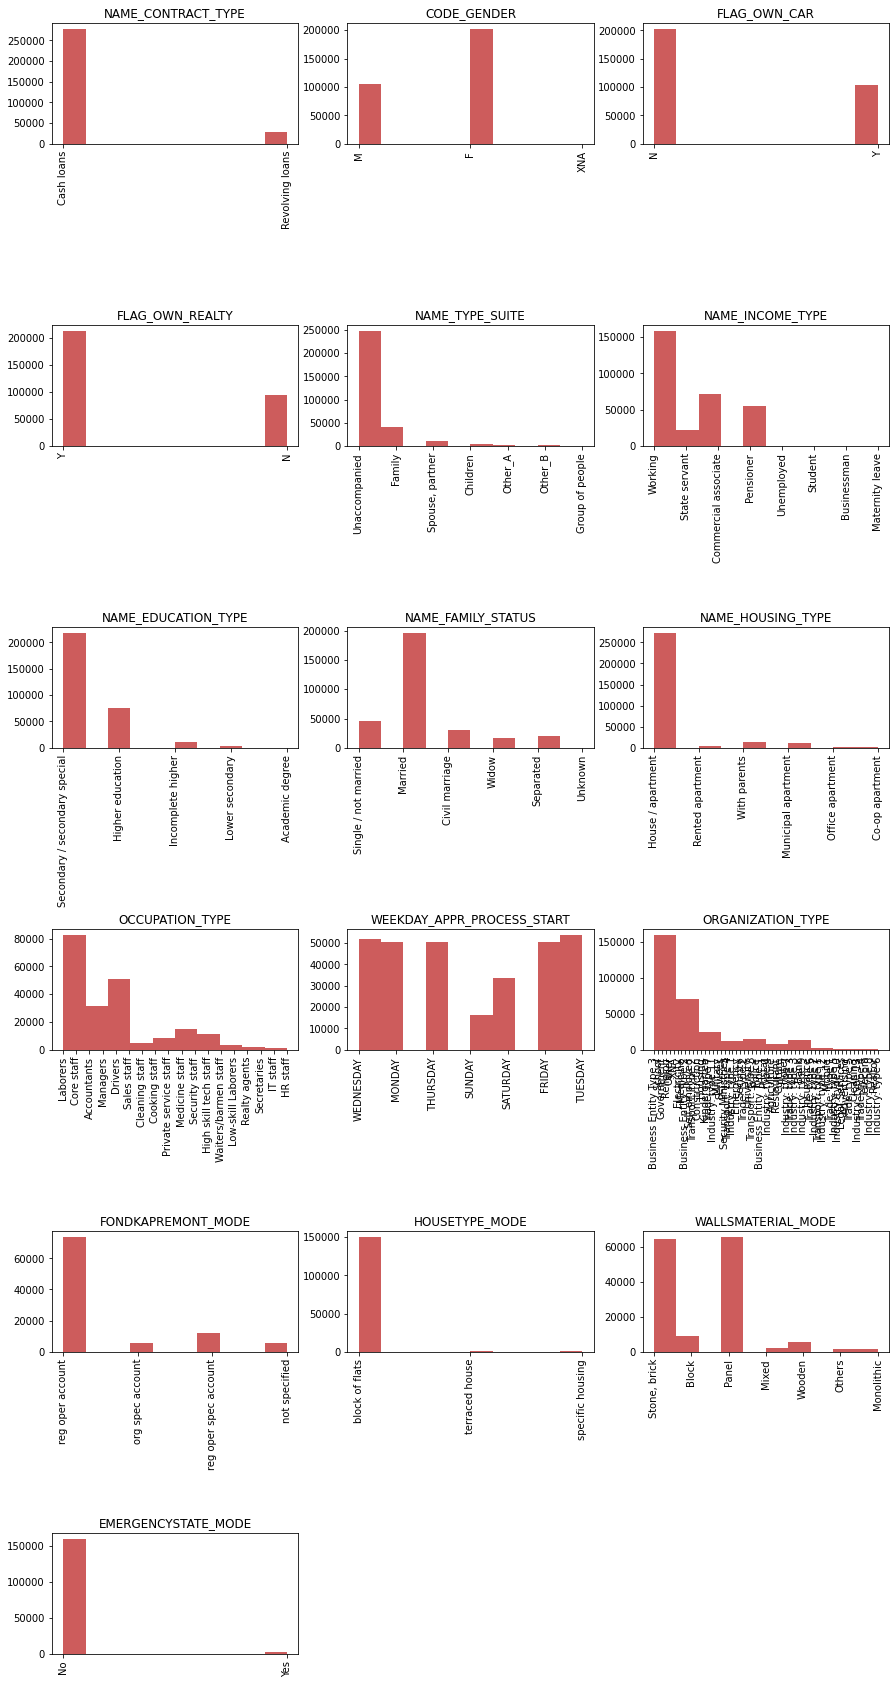

In [ ]:
# Draw histogram for categorical variables
draw_histograms(data_c, data_c.columns, 6, 3, [15, 30], 'indianred')

Multiple levels of some categorical variable needs to be combined

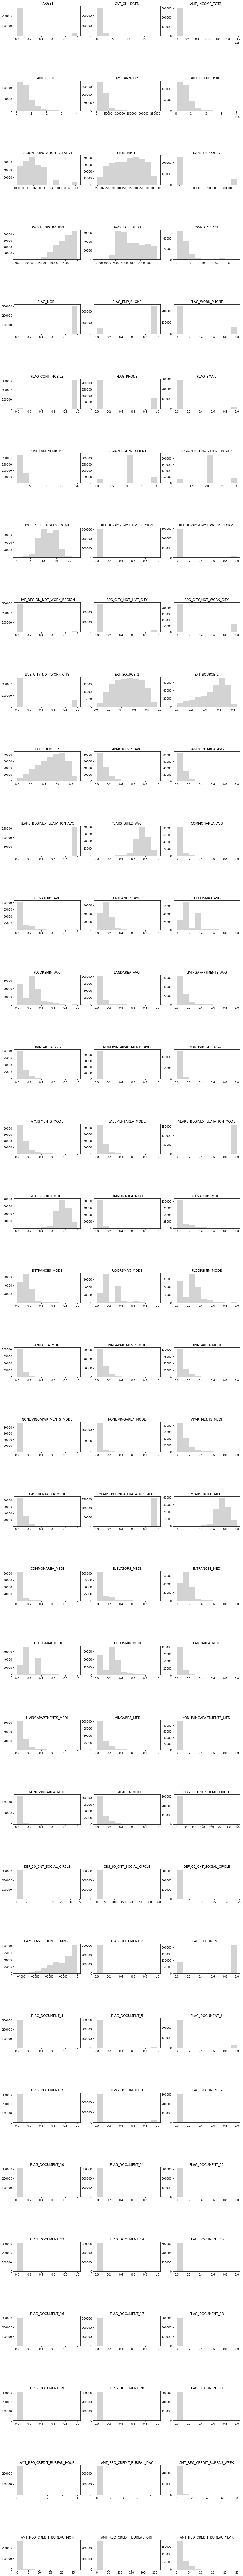

In [ ]:
# Draw histogram for numerical variable
draw_histograms(data_num, data_num.columns, 37, 3, [15, 185], 'lightgray')

### Bivariate Analysis

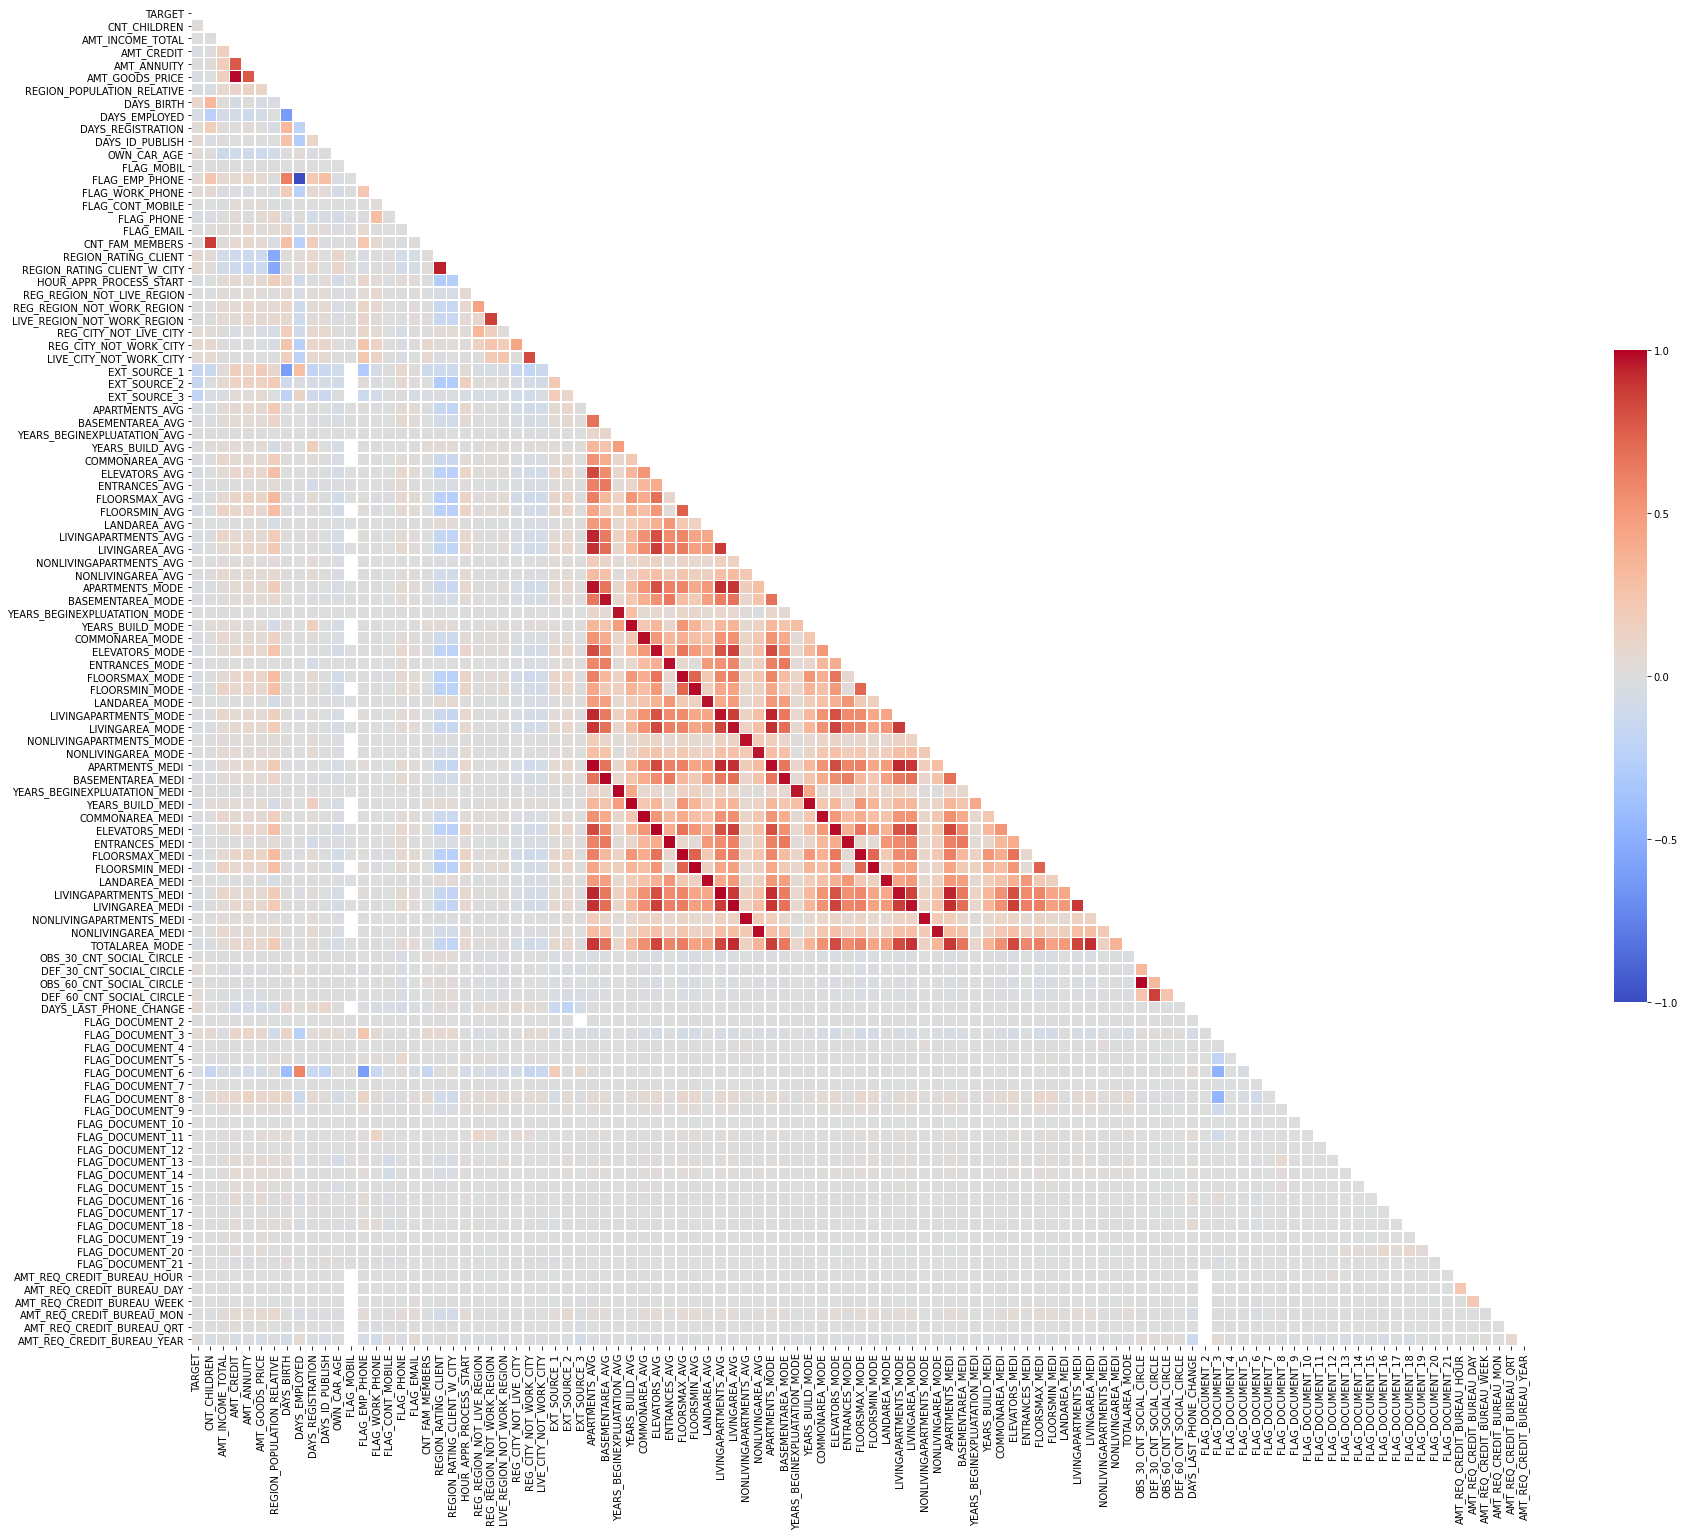

In [ ]:
correlation = data.corr()

mask = np.zeros_like(correlation.iloc[:121,:121], dtype=np.bool)              # Create an array of zeros with the same shape and type as a given array.
mask[np.triu_indices_from(mask)] = True                                       # Set the indices for the upper-triangle of array to be True

f, ax = plt.subplots(figsize=(30, 30))

heatmap = sns.heatmap(correlation.iloc[:121,:121],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(correlation.iloc[:121,:121].columns, rotation = 0)
ax.set_xticklabels(correlation.iloc[:121,:121].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

It seems like some features are highly correlated. We will explore later to decide which feature to drop

### Missing Values

In [ ]:
# Check missing values for each columns
missing_values = pd.DataFrame(data.isnull().sum()/len(data), columns =['missing value rate'])

# Display all the missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(missing_values.sort_values(ascending = False, by = 'missing value rate'))

,missing value rate
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MODE,0.683550


#### Check columns with missing value rate > 0.15

In [ ]:
# Columns with missing value rate above 0.3
missing_values[missing_values['missing value rate'] > 0.15].index

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

##### Column: 'OWN_CAR_AGE'

In [ ]:
# Check missing values in column car age
print("Missing values:", data['OWN_CAR_AGE'].isna().sum(axis = 0))

# Check how many of the missing values has N in the column FLAG_OWN_CAR
car = data.loc[data['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE']
print("Missing values with N in the column FLAG_OWN_CAR:", car.shape[0])

Missing values: 202929
Missing values with N in the column FLAG_OWN_CAR: 202924


We can see most na in column OWN_CAR_AGE is because people don't have cars, total 202924 rows. We will just keep this column and encode those na values

##### Column: OCCUPATION TYPE

In [ ]:
# Deal with OCCUPATION TYPE
# Choose the subset where columns OCCUPATION TYPE contains na
ocp = data.loc[data['OCCUPATION_TYPE'].isna()]
ocp.shape

(96391, 121)

In [ ]:
# Separate data into categorical and numerical variables
categorical = ocp.dtypes[ocp.dtypes == 'object'].index
ocp_c = ocp[categorical]

numerical = ocp.dtypes[ocp.dtypes != 'object'].index
ocp_num = ocp[numerical]

In [ ]:
# Plot histogram for categorical variables
# draw_histograms(ocp_c, ocp_c.columns, 4, 4, [20, 20])

In [ ]:
# draw_histograms(ocp_num, ocp_num.columns, 22, 5, [20, 50])

In [ ]:
# We can see many Pensioner left this column na, total 55357 rows
ocp['NAME_INCOME_TYPE'].value_counts()

Pensioner               55357
Working                 24920
Commercial associate    12297
State servant            3787
Unemployed                 22
Student                     5
Businessman                 2
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
# How many missing values left, if we fill OCCUPATION_TYPE with Retired for Pensioner
ocp.loc[ocp['NAME_INCOME_TYPE'] != 'Pensioner'].shape[0]/len(data)

0.13343912900676724

There will be only 13% missing value in this column if we fill this column with 'Retired' for pensioner. The ratio is below our threshold. So we will keep this column as well.

##### Column: EXT_SOURCE_1

In [ ]:
# Deal with 'EXT_SOURCE_1'
# Choose the subset where columns 'EXT_SOURCE_1' contains na
ext1 = data.loc[data['EXT_SOURCE_1'].isna()]
ext1.shape

(173378, 121)

In [ ]:
# Separate data into categorical and numerical variables and plot histogram
categorical = ext1.dtypes[ext1.dtypes == 'object'].index
ext1_c = ext1[categorical]

numerical = ext1.dtypes[ext1.dtypes != 'object'].index
ext1_num = ext1[numerical]

In [ ]:
# draw_histograms(ext1_c, ext1_c.columns, 4, 4, [20, 20])

In [ ]:
# draw_histograms(ext1_num, ext1_num.columns, 22, 5, [20, 50])

From the histograms, We did not see any structural defficiency and particular pattern in the missing values. Assume the missing value in this column is missing at random and will drop it later.

##### Column: EXT_SOURCE_3

In [ ]:
# Deal with 'EXT_SOURCE_3'
# Choose the subset where columns 'EXT_SOURCE_3' contains na
ext3 = data.loc[data['EXT_SOURCE_3'].isna()]
ext3.shape

(60965, 121)

In [ ]:
# Separate data into categorical and numerical variables and plot histogram
categorical = ext3.dtypes[ext3.dtypes == 'object'].index
ext3_c = ext3[categorical]

numerical = ext3.dtypes[ext3.dtypes != 'object'].index
ext3_num = ext3[numerical]

In [ ]:
# draw_histograms(ext3_c, ext3_c.columns, 4, 4, [20, 20])

In [ ]:
# draw_histograms(ext3_num, ext3_num.columns, 22, 5, [20, 50])

The same reason for EXT_SOURCE_3, and we will drop it later

##### Columns related to house / apartment

In [ ]:
# All the columns related to house
col_lst = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 
'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

In [ ]:
# Get the index of rows that have at least one missing value in those columns
na_val = data.isna()
na_idx = na_val[na_val[col_lst].sum(axis = 1)>0].index

In [ ]:
# Get all the data that have at least one missing value in those house related columns
house = data.loc[na_idx]

In [ ]:
# Separate data into categorical and numerical variables and plot histogram
categorical = house.dtypes[house.dtypes == 'object'].index
hse_c = house[categorical]

numerical = house.dtypes[house.dtypes != 'object'].index
hse_num = house[numerical]

In [ ]:
# draw_histograms(hse_c, hse_c.columns, 4, 4, [20, 20])
# draw_histograms(hse_num, hse_num.columns, 22, 5, [20, 50])

We did not see any structural deficiency and specific causes. So let's assume the missing value in those columns are missing at random

### Outliers

In [ ]:
# Define function to conduct univariate analysis
def draw_boxplot(df, variables, n_rows, n_cols, size, color):
  fig = plt.figure(figsize=size)
  for i, var_name in enumerate(variables):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    df[var_name].plot.box(ax = ax, grid = False, color = color)
    ax.set_title(var_name)
    if df[var_name].dtypes == 'object':
      plt.xticks(rotation = 90)
  plt.subplots_adjust(hspace = 1.5)
  plt.show()

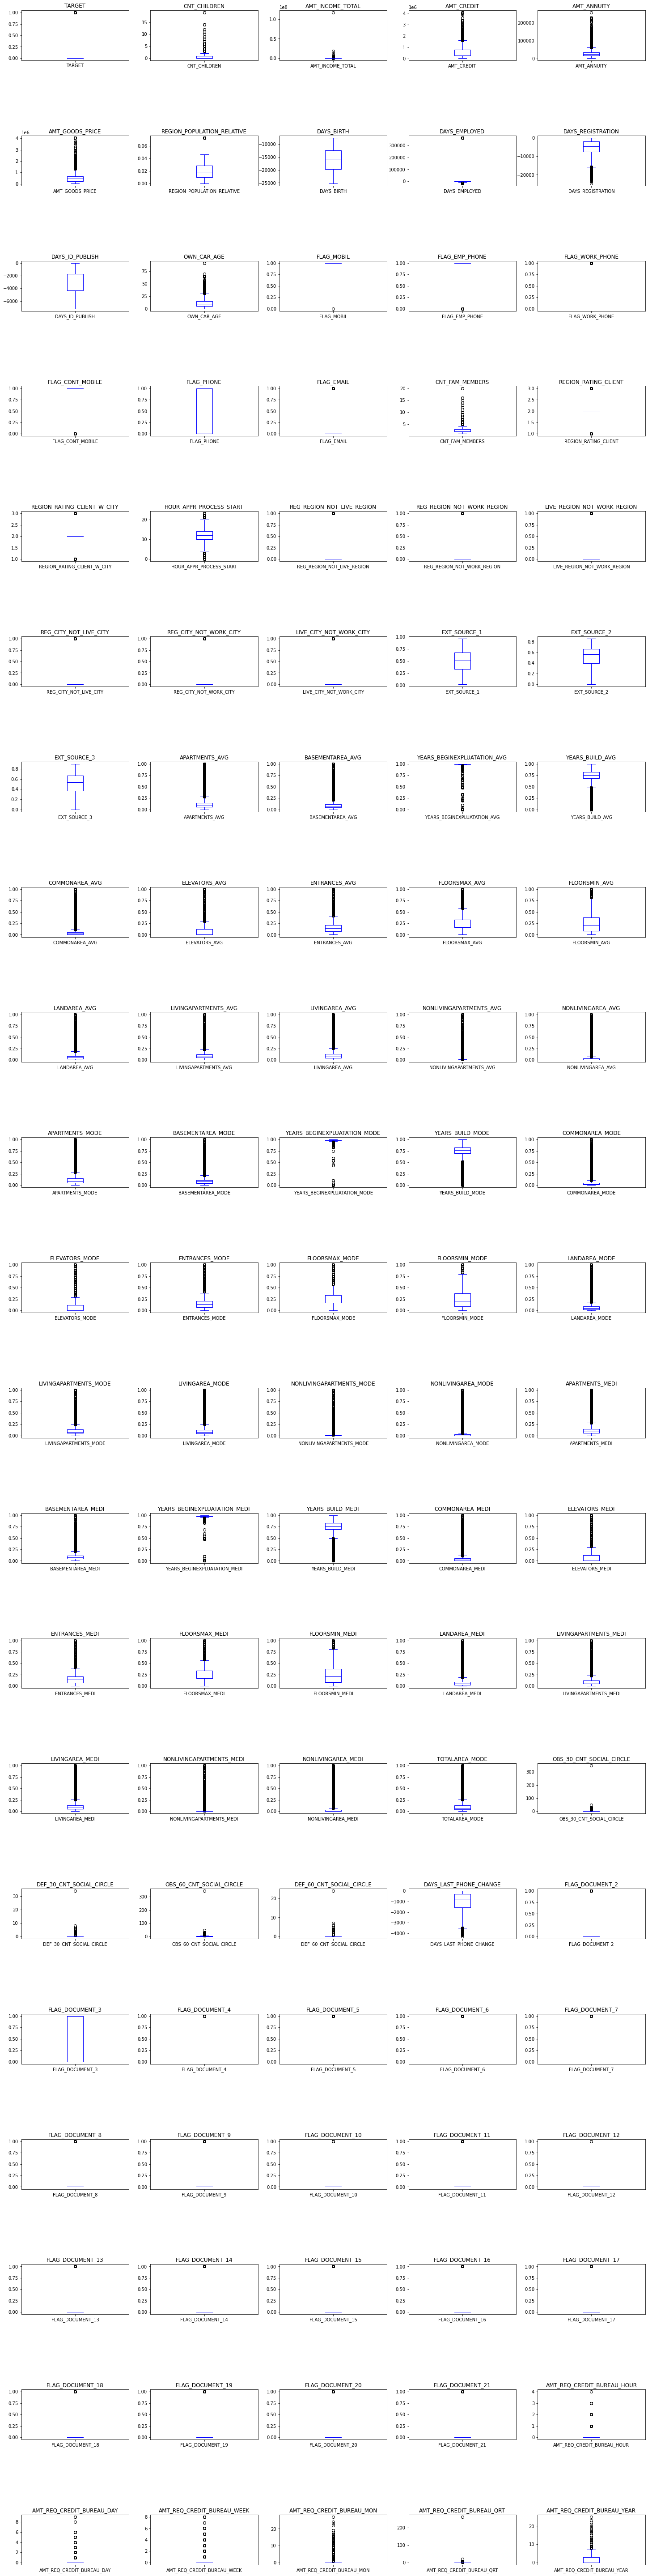

In [ ]:
draw_boxplot(data_num, data_num.columns, 21, 5, [25, 105], 'blue')

## Feature Engineering

### Drop Columns

#### Drop columns with missing value rate greater than 0.15

In [ ]:
# Compile the columns that need to be dropped
col_lst.append('EXT_SOURCE_1')
col_lst.append('EXT_SOURCE_3')

In [ ]:
new_data = data.drop(col_lst, axis = 1)

In [ ]:
# Check missing values for each columns, and also notice that we need to keep columns OWN_CAR_AGE and OCCUPATION_TYPE
missing_values1 = pd.DataFrame(new_data.isnull().sum()/len(new_data), columns =['missing value rate'])
missing_values1.sort_values(ascending = False, by = 'missing value rate')[0:5]

,missing value rate
OWN_CAR_AGE,0.659908
OCCUPATION_TYPE,0.313455
AMT_REQ_CREDIT_BUREAU_YEAR,0.135016
AMT_REQ_CREDIT_BUREAU_QRT,0.135016
AMT_REQ_CREDIT_BUREAU_MON,0.135016


#### Drop columns with too many missing values while the related target is 1 

In [ ]:
# Create subset of new_data with TARGET = 1
minor = new_data[new_data['TARGET'] == 1]

In [ ]:
# Check the missing values for each columns
minor.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                   17249
OCCUPATION_TYPE                6278
AMT_REQ_CREDIT_BUREAU_HOUR     4292
AMT_REQ_CREDIT_BUREAU_QRT      4292
AMT_REQ_CREDIT_BUREAU_YEAR     4292
AMT_REQ_CREDIT_BUREAU_DAY      4292
AMT_REQ_CREDIT_BUREAU_WEEK     4292
AMT_REQ_CREDIT_BUREAU_MON      4292
NAME_TYPE_SUITE                  70
EXT_SOURCE_2                     52
DEF_60_CNT_SOCIAL_CIRCLE         36
OBS_60_CNT_SOCIAL_CIRCLE         36
DEF_30_CNT_SOCIAL_CIRCLE         36
OBS_30_CNT_SOCIAL_CIRCLE         36
AMT_GOODS_PRICE                  21
dtype: int64

In [ ]:
# Check the missing value rate of column AMT_REQ_CREDIT_BUREAU_HOUR for TARGET = 1
minor['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()/len(minor)

0.17289023162134945

In [ ]:
# Check the missing value rate of column AMT_REQ_CREDIT_BUREAU_HOUR for TARGET = 0
data[data['TARGET'] == 0]['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()/len(data[data['TARGET'] == 0])

0.1316902853342578

There is no significant difference in the missing value rate between TARGET 1 and TARGET 0, so we will drop those columns.

In [ ]:
# Drop columns
cols_lst2 = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_DAY', 
             'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_QRT']

new_data = new_data.drop(cols_lst2, axis = 1)

In [ ]:
new_data.isna().sum(axis = 0).sort_values(ascending = False)[0:10]

OWN_CAR_AGE                 202929
OCCUPATION_TYPE              96391
NAME_TYPE_SUITE               1292
DEF_60_CNT_SOCIAL_CIRCLE      1021
OBS_60_CNT_SOCIAL_CIRCLE      1021
DEF_30_CNT_SOCIAL_CIRCLE      1021
OBS_30_CNT_SOCIAL_CIRCLE      1021
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
dtype: int64

#### Drop columns that are highly correlated

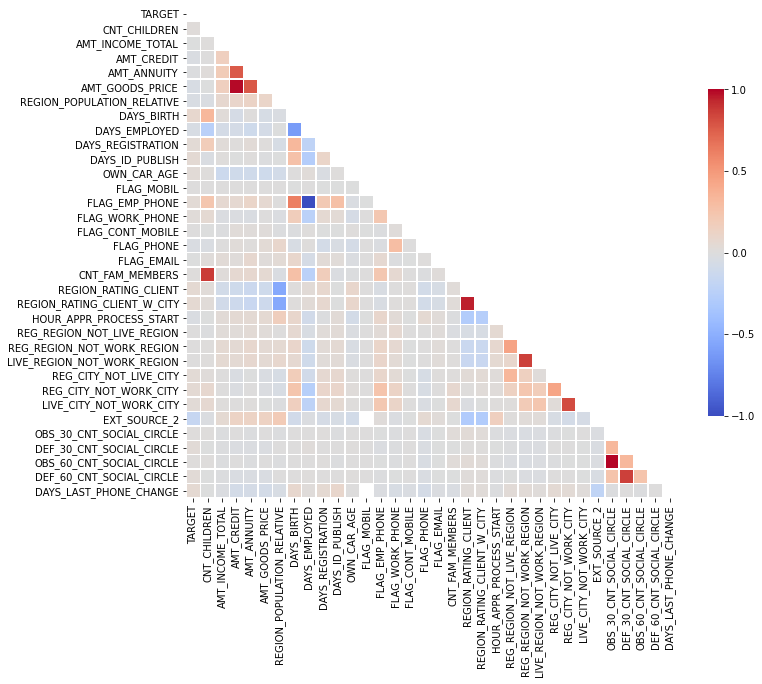

In [ ]:
corr_score_new = new_data.corr()

mask = np.zeros_like(corr_score_new.iloc[:34,:34], dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_score_new.iloc[:34,:34],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_score_new.iloc[:34,:34].columns, rotation = 0)
ax.set_xticklabels(corr_score_new.iloc[:34,:34].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [ ]:
# Define function to print out the top 5 positive correlated features and 5 negative correlated features
def corr_top5(x):
  pos_corr = x.sort_values(ascending = False)[0:5]
  neg_corr = x.sort_values()[0:5]
  print("Positive Correlation:")
  print(pos_corr)
  print("\nNegative Correlation:")
  print(neg_corr)

In [ ]:
corr_top5(corr_score_new['AMT_CREDIT'])

Positive Correlation:
AMT_CREDIT          1.000000
AMT_GOODS_PRICE     0.986968
AMT_ANNUITY         0.770138
AMT_INCOME_TOTAL    0.156870
EXT_SOURCE_2        0.131228
Name: AMT_CREDIT, dtype: float64

Negative Correlation:
REGION_RATING_CLIENT_W_CITY   -0.110915
REGION_RATING_CLIENT          -0.101776
OWN_CAR_AGE                   -0.094191
DAYS_LAST_PHONE_CHANGE        -0.073701
DAYS_EMPLOYED                 -0.066838
Name: AMT_CREDIT, dtype: float64


In [ ]:
corr_top5(corr_score_new['CNT_FAM_MEMBERS'])

Positive Correlation:
CNT_FAM_MEMBERS      1.000000
CNT_CHILDREN         0.879161
DAYS_BIRTH           0.278894
FLAG_EMP_PHONE       0.233950
DAYS_REGISTRATION    0.173416
Name: CNT_FAM_MEMBERS, dtype: float64

Negative Correlation:
DAYS_EMPLOYED                -0.233549
FLAG_DOCUMENT_6              -0.156682
DAYS_LAST_PHONE_CHANGE       -0.027108
REGION_POPULATION_RELATIVE   -0.024209
DAYS_ID_PUBLISH              -0.020912
Name: CNT_FAM_MEMBERS, dtype: float64


In [ ]:
corr_top5(corr_score_new['FLAG_EMP_PHONE'])

Positive Correlation:
FLAG_EMP_PHONE            1.000000
DAYS_BIRTH                0.619888
DAYS_ID_PUBLISH           0.273611
REG_CITY_NOT_WORK_CITY    0.256427
FLAG_DOCUMENT_3           0.248534
Name: FLAG_EMP_PHONE, dtype: float64

Negative Correlation:
DAYS_EMPLOYED                 -0.999755
FLAG_DOCUMENT_6               -0.597732
REGION_RATING_CLIENT_W_CITY   -0.034712
REGION_RATING_CLIENT          -0.032871
OWN_CAR_AGE                   -0.028282
Name: FLAG_EMP_PHONE, dtype: float64


In [ ]:
corr_top5(corr_score_new['REGION_RATING_CLIENT_W_CITY'])

Positive Correlation:
REGION_RATING_CLIENT_W_CITY    1.000000
REGION_RATING_CLIENT           0.950842
OWN_CAR_AGE                    0.088820
DAYS_REGISTRATION              0.074038
FLAG_DOCUMENT_3                0.067083
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

Negative Correlation:
REGION_POPULATION_RELATIVE    -0.531535
EXT_SOURCE_2                  -0.288299
HOUR_APPR_PROCESS_START       -0.264815
AMT_ANNUITY                   -0.141682
LIVE_REGION_NOT_WORK_REGION   -0.140771
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


In [ ]:
corr_top5(corr_score_new['LIVE_REGION_NOT_WORK_REGION'])

Positive Correlation:
LIVE_REGION_NOT_WORK_REGION    1.000000
REG_REGION_NOT_WORK_REGION     0.860627
LIVE_CITY_NOT_WORK_CITY        0.236635
REG_CITY_NOT_WORK_CITY         0.185863
FLAG_EMP_PHONE                 0.096447
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

Negative Correlation:
REGION_RATING_CLIENT          -0.146561
REGION_RATING_CLIENT_W_CITY   -0.140771
DAYS_EMPLOYED                 -0.095539
FLAG_DOCUMENT_6               -0.059148
OWN_CAR_AGE                   -0.028980
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64


In [ ]:
corr_top5(corr_score_new['LIVE_CITY_NOT_WORK_CITY'])

Positive Correlation:
LIVE_CITY_NOT_WORK_CITY        1.000000
REG_CITY_NOT_WORK_CITY         0.825575
LIVE_REGION_NOT_WORK_REGION    0.236635
FLAG_EMP_PHONE                 0.219219
REG_REGION_NOT_WORK_REGION     0.197097
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64

Negative Correlation:
DAYS_EMPLOYED          -0.218101
FLAG_DOCUMENT_6        -0.133229
EXT_SOURCE_2           -0.058900
FLAG_PHONE             -0.023580
REGION_RATING_CLIENT   -0.019154
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64


In [ ]:
corr_top5(corr_score_new['OBS_30_CNT_SOCIAL_CIRCLE'])

Positive Correlation:
OBS_30_CNT_SOCIAL_CIRCLE    1.000000
OBS_60_CNT_SOCIAL_CIRCLE    0.998490
DEF_30_CNT_SOCIAL_CIRCLE    0.329338
DEF_60_CNT_SOCIAL_CIRCLE    0.253499
REGION_RATING_CLIENT        0.034330
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Negative Correlation:
FLAG_PHONE                    -0.033484
REG_REGION_NOT_WORK_REGION    -0.028855
FLAG_DOCUMENT_8               -0.023339
LIVE_REGION_NOT_WORK_REGION   -0.023147
REG_REGION_NOT_LIVE_REGION    -0.020641
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64


In [ ]:
corr_top5(corr_score_new['DEF_30_CNT_SOCIAL_CIRCLE'])

Positive Correlation:
DEF_30_CNT_SOCIAL_CIRCLE    1.000000
DEF_60_CNT_SOCIAL_CIRCLE    0.860517
OBS_60_CNT_SOCIAL_CIRCLE    0.331571
OBS_30_CNT_SOCIAL_CIRCLE    0.329338
TARGET                      0.032248
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

Negative Correlation:
EXT_SOURCE_2      -0.030406
FLAG_PHONE        -0.029758
AMT_ANNUITY       -0.022833
AMT_GOODS_PRICE   -0.022244
AMT_CREDIT        -0.021229
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64


##### Define the magnitude of correlation:
The absolute value of correlation:
Weak: 0.0 ~ 0.3, Medium: 0.3 ~ 0.7, Strong: 0.7 ~ 1.0

We will drop columns that have strong correlations.

In [ ]:
# Drop highly correlated columns
cols_lst3 = ['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT', 'REG_REGION_NOT_WORK_REGION',
            'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'REG_CITY_NOT_WORK_CITY']

new_data = new_data.drop(cols_lst3, axis = 1)

In [ ]:
new_data.shape

(307511, 57)

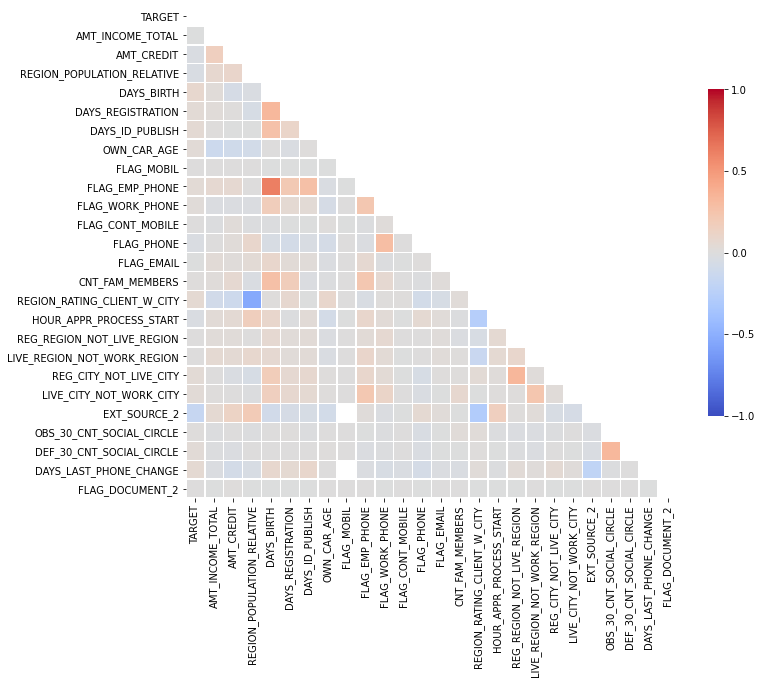

In [ ]:
corr_score_new1 = new_data.corr()

mask = np.zeros_like(corr_score_new1.iloc[:26,:26], dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_score_new1.iloc[:26,:26],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_score_new1.iloc[:26,:26].columns, rotation = 0)
ax.set_xticklabels(corr_score_new1.iloc[:26,:26].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Drop Rows

#### Drop rows, which target = 0 and have missing values in columns

In [ ]:
# Create subset of new_data with TARGET = 0
major = new_data[new_data['TARGET'] == 0]

In [ ]:
# Check the missing values for each columns
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                 185680
OCCUPATION_TYPE              90113
NAME_TYPE_SUITE               1222
OBS_30_CNT_SOCIAL_CIRCLE       985
DEF_30_CNT_SOCIAL_CIRCLE       985
EXT_SOURCE_2                   608
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
DAYS_ID_PUBLISH                  0
FLAG_EMAIL                       0
FLAG_PHONE                       0
FLAG_CONT_MOBILE                 0
FLAG_WORK_PHONE                  0
FLAG_EMP_PHONE                   0
FLAG_MOBIL                       0
dtype: int64

In [ ]:
# Drop rows with missing values in NAME_TYPE_SUITE 
drop_idx0 = major[major['NAME_TYPE_SUITE'].isna()].index
new_data = new_data.drop(drop_idx0, axis = 0)

In [ ]:
# Drop rows with missing values in OBS_30_CNT_SOCIAL_CIRCLE
drop_idx1 = major[major['OBS_30_CNT_SOCIAL_CIRCLE'].isna()].index
new_data = new_data.drop(drop_idx1, axis = 0)

In [ ]:
# Re-run those code to update the major
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE               184218
OCCUPATION_TYPE            89433
EXT_SOURCE_2                 603
DAYS_LAST_PHONE_CHANGE         1
FLAG_DOCUMENT_21               0
DAYS_REGISTRATION              0
CNT_FAM_MEMBERS                0
FLAG_EMAIL                     0
FLAG_PHONE                     0
FLAG_CONT_MOBILE               0
FLAG_WORK_PHONE                0
FLAG_EMP_PHONE                 0
FLAG_MOBIL                     0
DAYS_ID_PUBLISH                0
DAYS_BIRTH                     0
dtype: int64

In [ ]:
# Drop rows with missing values in EXT_SOURCE_2
drop_idx2 = major[major['EXT_SOURCE_2'].isna()].index
new_data = new_data.drop(drop_idx2, axis = 0)

In [ ]:
# Re-run those code to update the major
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                    183789
OCCUPATION_TYPE                 89199
FLAG_DOCUMENT_21                    0
HOUR_APPR_PROCESS_START             0
REGION_RATING_CLIENT_W_CITY         0
CNT_FAM_MEMBERS                     0
FLAG_EMAIL                          0
FLAG_PHONE                          0
FLAG_CONT_MOBILE                    0
FLAG_WORK_PHONE                     0
FLAG_EMP_PHONE                      0
FLAG_MOBIL                          0
DAYS_ID_PUBLISH                     0
DAYS_REGISTRATION                   0
DAYS_BIRTH                          0
dtype: int64

In [ ]:
# Drop rows with missing values in EXT_SOURCE_2
drop_idx2 = major[major['EXT_SOURCE_2'].isna()].index
new_data = new_data.drop(drop_idx2, axis = 0)

In [ ]:
# OWN_CAR_AGE and OCCUPATION_TYPE are columns we need to impute
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                    183789
OCCUPATION_TYPE                 89199
FLAG_DOCUMENT_21                    0
HOUR_APPR_PROCESS_START             0
REGION_RATING_CLIENT_W_CITY         0
CNT_FAM_MEMBERS                     0
FLAG_EMAIL                          0
FLAG_PHONE                          0
FLAG_CONT_MOBILE                    0
FLAG_WORK_PHONE                     0
FLAG_EMP_PHONE                      0
FLAG_MOBIL                          0
DAYS_ID_PUBLISH                     0
DAYS_REGISTRATION                   0
DAYS_BIRTH                          0
dtype: int64

##### Except the columns (OWN_CAR_AGE, OCCUPATION_TYPE) we want to keep, there is no missing value in other columns, where the related targets are 0s

### Train Test Split

In [ ]:
# Divide train and validation following same distribution 
train0, validation0 = train_test_split(new_data, test_size = 0.2, random_state = 23, stratify = new_data['TARGET'])

In [ ]:
# Define a function to get the class proportions
def get_class_proportions(df):
  minor_prop = df[df['TARGET'] == 1].shape[0]/len(df)
  major_prop = df[df['TARGET'] == 0].shape[0]/len(df)
  return {'Target(1)': minor_prop, 'Target(0)': major_prop}

In [ ]:
# Print out the class proportion for train and validation
train_class_proportions = get_class_proportions(train0)
validation_class_proportions = get_class_proportions(validation0)

print("Train data class proportions:", train_class_proportions)
print("Validation data class proportions:", validation_class_proportions)

Train data class proportions: {'Target(1)': 0.0814735805710535, 'Target(0)': 0.9185264194289465}
Validation data class proportions: {'Target(1)': 0.08147224364549319, 'Target(0)': 0.9185277563545068}


In [ ]:
# Make a copy
train = train0.copy()
validation = validation0.copy()

print(train.shape)
print(validation.shape)

(243760, 57)
(60941, 57)


In [ ]:
# Save train and validation csv
train.to_csv('train.csv', index = True)
!cp train.csv "drive/My Drive/"

In [ ]:
validation.to_csv('validation.csv', index = True)
!cp validation.csv "drive/My Drive/"

In [ ]:
# Reload train and validation
train = pd.read_csv('train.csv', index_col = 0)
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
425016,0,Cash loans,M,N,Y,112500.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.009630,-13672,-7552.0,-4481,NaN,1,1,1,1,1,0,Laborers,2.0,2,THURSDAY,17,0,1,0,1,Business Entity Type 3,0.185145,0.0,0.0,-620.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116242,0,Cash loans,M,N,Y,270000.0,203760.0,Unaccompanied,State servant,Higher education,Civil marriage,House / apartment,0.046220,-11326,-5468.0,-3832,NaN,1,1,0,1,1,0,High skill tech staff,2.0,1,FRIDAY,13,0,0,0,0,Military,0.283480,0.0,0.0,-14.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112522,0,Cash loans,F,Y,N,157500.0,781920.0,Other_A,State servant,Higher education,Married,House / apartment,0.022800,-9490,-4155.0,-1922,0.0,1,1,0,1,0,0,Core staff,2.0,2,SATURDAY,10,0,0,0,0,University,0.590467,2.0,1.0,-610.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
401317,0,Cash loans,F,N,Y,49500.0,540000.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.031329,-22595,-10137.0,-4618,NaN,1,0,0,1,1,0,NaN,2.0,2,SATURDAY,9,0,0,0,0,XNA,0.659662,0.0,0.0,-2402.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
440895,0,Cash loans,M,N,N,225000.0,1762110.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.046220,-12034,-5469.0,-2788,NaN,1,1,0,1,1,0,Laborers,2.0,1,WEDNESDAY,21,0,1,0,1,Telecom,0.696256,0.0,0.0,-1230.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
validation = pd.read_csv('validation.csv', index_col = 0)
validation.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420412,0,Cash loans,F,N,N,121500.0,592560.0,Unaccompanied,Working,Secondary / secondary special,Widow,Municipal apartment,0.007114,-16706,-7222.0,-244,NaN,1,1,0,1,1,0,Cleaning staff,1.0,2,WEDNESDAY,17,0,0,0,0,Other,0.780284,0.0,0.0,-852.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400448,1,Revolving loans,M,Y,Y,315000.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008866,-12493,-6529.0,-4461,6.0,1,1,0,0,0,0,Laborers,4.0,2,WEDNESDAY,12,0,0,0,0,Transport: type 2,0.325944,2.0,0.0,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
389953,0,Cash loans,F,Y,Y,180000.0,808650.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.005313,-19513,-11742.0,-2388,26.0,1,0,0,1,1,0,NaN,2.0,2,FRIDAY,11,0,0,0,0,XNA,0.639844,0.0,0.0,-547.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
381118,0,Cash loans,F,Y,N,90000.0,1005120.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006852,-11200,-40.0,-1731,13.0,1,1,0,1,0,0,Laborers,2.0,3,SUNDAY,7,0,0,0,1,Business Entity Type 3,0.224186,0.0,0.0,-427.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
314845,0,Cash loans,F,N,Y,153000.0,269550.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.010032,-14855,-957.0,-4659,NaN,1,1,1,1,1,0,Core staff,4.0,2,TUESDAY,11,0,0,0,0,School,0.561105,1.0,0.0,-2578.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check the shape of train and validation set
print("Train shape:", train.shape)
print("Validation shape:", validation.shape)

Train shape: (243760, 57)
Validation shape: (60941, 57)


### Impute Missing Values

#### Input columns: OWN_CAR_AGE, OCCUPATION_TYPE

##### Columns: ONW_CAR_AGE

In [ ]:
# Calculate the mean value of car age when 'FLAG_OWN_CAR' = Y for train and validation
mean_train = train['OWN_CAR_AGE'].mean()
mean_validation = validation['OWN_CAR_AGE'].mean()
print("Car age for train:", mean_train)
print("Car age for validation:", mean_validation)

Car age for train: 12.099066321305946
Car age for validation: 11.959967082970278


In [ ]:
# Fill values of OWN_CAR_AGE based on the values in FLAG_OWN_CAR for train and validation
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(data['FLAG_OWN_CAR'])
train['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

validation['OWN_CAR_AGE'] = validation['OWN_CAR_AGE'].fillna(data['FLAG_OWN_CAR'])
validation['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

In [ ]:
# Check the missing value rate of column OWN_CAR_AGE
print("Missing values rate for train:", train['OWN_CAR_AGE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OWN_CAR_AGE'].isna().sum()/len(validation))

Missing values rate for train: 0.0
Missing values rate for validation: 0.0


##### Column OCCUPATION_TYPE

In [ ]:
# If NAME_INCOME_TYPE == Pensioner, fill na in OCCUPATION_TYPE with Retired for train and validation
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'
validation.loc[validation['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'

In [ ]:
# Check the missing values rate in OCCUPATION_TYPE
print("Missing values rate for train:", train['OCCUPATION_TYPE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OCCUPATION_TYPE'].isna().sum()/len(validation))

Missing values rate for train: 0.13313915326550704
Missing values rate for validation: 0.13391641095485798


In [ ]:
# Most common occupation type in train and validation
print("Most common occupation type for train:", train['OCCUPATION_TYPE'].value_counts().index[0])
print("Most common occupation type for validation:", validation['OCCUPATION_TYPE'].value_counts().index[0])

Most common occupation type for train: Retired
Most common occupation type for validation: Retired


In [ ]:
# Fill the na in train and validation
train['OCCUPATION_TYPE'].fillna('Retired', inplace = True)
validation['OCCUPATION_TYPE'].fillna('Retired', inplace = True)

# Checking missing values
print("Missing values for train:", train['OCCUPATION_TYPE'].isna().sum())
print("Missing values for validation:", validation['OCCUPATION_TYPE'].isna().sum())

Missing values for train: 0
Missing values for validation: 0


#### Inpute other columns

In [ ]:
missing_train = pd.DataFrame(train.isnull().sum(), columns =['missing value rate'])
print(missing_train.sort_values(ascending = False, by = 'missing value rate')[0:12])

missing_validation = pd.DataFrame(validation.isnull().sum(), columns =['missing value rate'])
print(missing_validation.sort_values(ascending = False, by = 'missing value rate')[0:10])

                          missing value rate
NAME_TYPE_SUITE                           57
EXT_SOURCE_2                              42
OBS_30_CNT_SOCIAL_CIRCLE                  33
DEF_30_CNT_SOCIAL_CIRCLE                  33
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_PHONE_CHANGE                     0
FLAG_DOCUMENT_2                            0
FLAG_DOCUMENT_3                            0
FLAG_DOCUMENT_4                            0
                          missing value rate
NAME_TYPE_SUITE                           13
EXT_SOURCE_2                              10
OBS_30_CNT_SOCIAL_CIRCLE                   3
DEF_30_CNT_SOCIAL_CIRCLE                   3
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_

In [ ]:
# Define functions to fill missing values in categorical variables and numerical variables
def fill_missing(x, categorical = False):
  if categorical == True:
    val_train = train[x].value_counts().index[0]
    val_validation = validation[x].value_counts().index[0]
    
    print("For column {}:".format(x))
    print("Most common values for train:", val_train)
    print("Most common values for test:", val_validation)
    
    # Fill the na in train and validation
    train[x].fillna(val_train, inplace = True)
    validation[x].fillna(val_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())
  
  else:
    median_train = train[x].median()
    median_validation = validation[x].median()

    print("For column {}:".format(x))
    print("Median value for train:", median_train)
    print("Median value for validation:", median_validation)

    # Fill missing value for train and validation
    train[x].fillna(median_train, inplace = True)
    validation[x].fillna(median_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())

##### Column: NAME_TYPE_SUITE

In [ ]:
# Fill column NAME_TYPE_SUITE
fill_missing('NAME_TYPE_SUITE', categorical = True)

For column NAME_TYPE_SUITE:
Most common values for train: Unaccompanied
Most common values for test: Unaccompanied
Missing values left in train: 0
Missing values left in validation: 0


##### Column: EXT_SOURCE_2 

In [ ]:
# Fill column EXT_SOURCE_2
fill_missing('EXT_SOURCE_2')

For column EXT_SOURCE_2:
Median value for train: 0.5657357988357584
Median value for validation: 0.5660312575232652
Missing values left in train: 0
Missing values left in validation: 0


##### Column: OBS_30_CNT_SOCIAL_CIRCLE

In [ ]:
# Fill column OBS_30_CNT_SOCIAL_CIRCLE
fill_missing('OBS_30_CNT_SOCIAL_CIRCLE')

For column OBS_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


##### Column: DEF_30_CNT_SOCIAL_CIRCLE

In [ ]:
# Fill column DEF_30_CNT_SOCIAL_CIRCLE
fill_missing('DEF_30_CNT_SOCIAL_CIRCLE')

For column DEF_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


In [ ]:
print("Check missing values in train:", train.isna().values.any())
print("Check missing values in validation:", validation.isna().values.any())

Check missing values in train: False
Check missing values in validation: False


### Deal with Categorical Variable

#### Reduce levels in some categorical variables

In [ ]:
# Columns that are categorical variables
cat_train_idx = train.dtypes[train.dtypes == 'object'].index
cat_train_idx

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

##### Categorical variable: OCCUPATION_TYPE

In [ ]:
train['OCCUPATION_TYPE'].value_counts()

Retired                  76312
Laborers                 43794
Sales staff              25489
Core staff               21914
Managers                 16895
Drivers                  14865
High skill tech staff     9016
Accountants               7705
Medicine staff            6757
Security staff            5343
Cooking staff             4692
Cleaning staff            3693
Private service staff     2076
Low-skill Laborers        1676
Waiters/barmen staff      1068
Secretaries               1007
Realty agents              584
HR staff                   447
IT staff                   427
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
# Deal with the levels in data
train.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [ ]:
train['OCCUPATION_TYPE'].value_counts()

White collar    90241
Retired         76312
Laborers        43794
Blue collar     33413
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
# Deal with the values in validation
validation.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [ ]:
validation['OCCUPATION_TYPE'].value_counts()

White collar    22517
Retired         19167
Laborers        10970
Blue collar      8287
Name: OCCUPATION_TYPE, dtype: int64

##### Categorical Variable: NAME_INCOME_TYPE

In [ ]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Unemployed                  15
Student                     14
Businessman                  8
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Group unemployed, student, businessman and maternity leave in a small group - other.
<br> The reason to group these four levels is that only a few records are in those levels. It always happens that only train set contains some levels. For instance, Maternity leave only has 5 records. When doing train test split, only train set contains this 5 records. After doing one hot encoding, this results in the train and validation set in different shape.  

In [ ]:
# Deal with train
train.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                   'Student': 'Other',
                                   'Businessman': 'Other',
                                   'Maternity leave': 'Other'}}, inplace = True)

In [ ]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Other                       42
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
# Deal with validation
validation.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                        'Student': 'Other',
                                        'Businessman': 'Other',
                                        'Maternity leave': 'Other'}}, inplace = True)

In [ ]:
validation['NAME_INCOME_TYPE'].value_counts()

Working                 31387
Commercial associate    14243
Pensioner               11006
State servant            4296
Other                       9
Name: NAME_INCOME_TYPE, dtype: int64

##### Categorical variable: ORGANIZATION_TYPE

In [ ]:
train['ORGANIZATION_TYPE'].value_counts()[0:20]

Business Entity Type 3    53886
XNA                       43865
Self-employed             30488
Other                     13161
Medicine                   8825
Business Entity Type 2     8364
Government                 8333
School                     7037
Trade: type 7              6169
Kindergarten               5529
Construction               5286
Business Entity Type 1     4731
Transport: type 4          4316
Trade: type 3              2757
Industry: type 9           2674
Industry: type 3           2638
Security                   2596
Housing                    2318
Industry: type 11          2155
Military                   2090
Name: ORGANIZATION_TYPE, dtype: int64

The categorical information in this column is messy, we will consider drop this column at this moment

In [ ]:
# Drop columns ORGANIZATION_TYPE
train = train.drop('ORGANIZATION_TYPE', axis = 1)
validation = validation.drop('ORGANIZATION_TYPE', axis = 1)

#### One-Hot Encoding

In [ ]:
# Conduct one-hot encoding, drop_first should be True to get the dummy variables
train = pd.get_dummies(train, drop_first = True)
validation = pd.get_dummies(validation, drop_first = True)

In [ ]:
print("Train shape:", train.shape)
print("validation shape:", validation.shape)

Train shape: (243760, 82)
validation shape: (60941, 81)


In [ ]:
# We have one column missing for validation. Match columns in train and validation
col_train = pd.Series(train.columns.value_counts(), name = 'train')
col_validation = pd.Series(validation.columns.value_counts(), name = 'validation')

In [ ]:
# Find the column that is included in train but not validation
col_train_validation = pd.concat([col_train, col_validation], axis = 1)
col_train_validation[col_train_validation['validation'].isna()]

,train,validation
CODE_GENDER_XNA,1,NaN


After further exploration, we find that 'CODE_GENDER_XNA' only has four records, we can drop this column as well.

In [ ]:
train['CODE_GENDER_XNA'].sort_values(ascending = False)[0:5]

SK_ID_CURR
319880    1
144669    1
196708    1
141289    1
166591    0
Name: CODE_GENDER_XNA, dtype: uint8

In [ ]:
# Drop the two rows
train.drop([319880, 144669, 196708, 141289], inplace = True)

In [ ]:
# Then drop the column CODE_GENDER_XNA' in train
train.drop('CODE_GENDER_XNA', axis = 1, inplace = True)

In [ ]:
print(train.shape)
print(validation.shape)

(243756, 81)
(60941, 81)


Now that train and validation are in the same shape, we can go ahead do the normalization

### Normalize the data

In [ ]:
# Prepare X_train, X_validation, y_train, y_validation
X_train_rw = train.drop('TARGET', axis = 1)
X_validation_rw = validation.drop('TARGET', axis = 1)

y_train = train['TARGET']
y_validation = validation['TARGET']

print("X_train shape:", X_train_rw.shape, "y_train shape:", y_train.shape)
print("X_validation shape:", X_validation_rw.shape, "y_validation shape:", y_validation.shape)

X_train shape: (243756, 80) y_train shape: (243756,)
X_validation shape: (60941, 80) y_validation shape: (60941,)


In [ ]:
# Standardize the train and validation data
scaler = StandardScaler()
scaler.fit(X_train_rw, y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
X_train = scaler.transform(X_train_rw)
X_validation = scaler.transform(X_validation_rw)

In [ ]:
X_test = X_validation 
y_test = y_validation

## Baseline Models with Regularization

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as skm

### Logistic Regression

In [ ]:
# Run Regularized Logistic Regression
lr = LogisticRegression(random_state = 23)

lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

y_train_proba_lr = lr.predict_proba(X_train)
y_test_proba_lr = lr.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_lr))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_lr))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_lr))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_lr))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_lr[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_lr))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_lr))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_lr))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_lr))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_lr[:,1]))

Train Confusion Matrix: 
 [[223883     13]
 [ 19848     12]]
Accuracy Train: 0.9185209799963898
Precision Train: 0.48
Recall Train: 0.0006042296072507553
AUC score 0.6998061444852958

 Test Confusion Matrix: 
 [[55976     0]
 [ 4962     3]]
Accuracy Test: 0.9185769842962865
Precision Test: 1.0
Recall Test: 0.0006042296072507553
AUC score 0.7040026613333494


### Random Forest

In [ ]:
# Run Random Forest Classifier
rf = RandomForestClassifier(max_depth = 20, random_state = 23)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

y_train_proba_rf= rf.predict_proba(X_train)
y_test_proba_rf= rf.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_rf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_rf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_rf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_rf))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_rf[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_rf))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_rf))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_rf))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_rf))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_rf[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [ 16909   2951]]
Accuracy Train: 0.9306314511232544
Precision Train: 1.0
Recall Train: 0.1485901309164149
AUC score 0.9944628487237152

 Test Confusion Matrix: 
 [[55976     0]
 [ 4964     1]]
Accuracy Test: 0.9185441656684334
Precision Test: 1.0
Recall Test: 0.0002014098690835851
AUC score 0.6882309617371624


### Naive Bayes Classifier

In [ ]:
# Run Naive Bayes Classifier
gnb = GaussianNB()

gnb.fit(X_train, y_train)

y_train_pred_gnb = gnb.predict(X_train)
y_test_pred_gnb = gnb.predict(X_test)

y_train_proba_gnb = gnb.predict_proba(X_train)
y_test_proba_gnb = gnb.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_gnb))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_gnb))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_gnb))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_gnb))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_gnb[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_gnb))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_gnb))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_gnb))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_gnb))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_gnb[:,1]))

Train Confusion Matrix: 
 [[  4906 218990]
 [   233  19627]]
Accuracy Train: 0.10064572769490802
Precision Train: 0.0822531504461124
Recall Train: 0.9882678751258812
AUC score 0.6425088491038369

 Test Confusion Matrix: 
 [[ 1207 54769]
 [   63  4902]]
Accuracy Test: 0.10024449877750612
Precision Test: 0.08215045834660052
Recall Test: 0.9873111782477342
AUC score 0.6430602559347475


## Model Performance Improvement

### SMOTE + Random Under-sampling

#### Oversampling minority class using SMOTE and Undersampling Majority Class using Randomundersampling (USM)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import metrics as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#### We first oversample the minority class to the same size of majority class and check AUC Score

In [ ]:
smote = SMOTE(sampling_strategy=1)
X_train_smote, y_train_smote = smote.fit_sample(X_train.astype('float'), y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Before usm: ", Counter(y_train))
print("After usm: ", Counter(y_train_smote))

Before usm:  Counter({0: 223896, 1: 19860})
After usm:  Counter({0: 223896, 1: 223896})


##### Logistic Regression

In [ ]:
# Run Regularized Logistic Regression
lr1 = LogisticRegression(random_state = 23)

lr1.fit(X_train_smote, y_train_smote)

y_train_pred_lr_smote = lr1.predict(X_train_smote)
y_test_pred_lr_smote = lr1.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
y_test_proba_lr_smote = lr1.predict_proba(X_test)

In [ ]:
print("Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_lr_smote))
print("Accuracy Train:", skm.accuracy_score(y_train_smote, y_train_pred_lr_smote))
print("Precision Train:", skm.precision_score(y_train_smote, y_train_pred_lr_smote))
print("Recall Train:", skm.recall_score(y_train_smote, y_train_pred_lr_smote))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_lr_smote))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_lr_smote))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_lr_smote))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_lr_smote[:,1]))

Test Confusion Matrix: 
 [[37251 18725]
 [ 1883  3082]]
Accuracy Train: 0.659545056633437
Precision Train: 0.6608272440356399
Recall Train: 0.6555588308857684
Accuracy Test: 0.6618368586009419
Precision Test: 0.1413307653505755
Recall Test: 0.6207452165156092
AUC score 0.6972187260228488


##### Random Forest

In [ ]:
# run rf with oversampling only
rf1 = RandomForestClassifier()

rf1.fit(X_train_smote, y_train_smote)

y_train_pred_rf_smote = rf1.predict(X_train_smote)
y_test_pred_rf_smote = rf1.predict(X_test)
y_test_proba_rf_smote = rf1.predict_proba(X_test)

In [ ]:
print("Accuracy Train:", skm.accuracy_score(y_train_smote, y_train_pred_rf_smote))
print("Precision Train:", skm.precision_score(y_train_smote, y_train_pred_rf_smote))
print("Recall Train:", skm.recall_score(y_train_smote, y_train_pred_rf_smote))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_rf_smote))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_rf_smote))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_rf_smote))
print(skm.roc_auc_score(y_test, y_test_proba_rf_smote[:,1]))

Accuracy Train: 0.9999977668203094
Precision Train: 1.0
Recall Train: 0.9999955336406189
Accuracy Test: 0.9156561264173545
Precision Test: 0.23564954682779457
Recall Test: 0.01570996978851964
0.6753315764301807


##### Naive Bayes

In [ ]:
# Run Naive Bayes Classifier
gnb1 = GaussianNB()

gnb1.fit(X_train_smote, y_train_smote)

y_train_pred_gnb1 = gnb1.predict(X_train_smote)
y_test_pred_gnb1 = gnb1.predict(X_test)
y_test_proba_gnb1_smote = gnb1.predict_proba(X_test)

In [ ]:
print("Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_gnb1))
print("Accuracy Train:", skm.accuracy_score(y_train_smote, y_train_pred_gnb1))
print("Precision Train:", skm.precision_score(y_train_smote, y_train_pred_gnb1))
print("Recall Train:", skm.recall_score(y_train_smote, y_train_pred_gnb1))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_gnb1))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_gnb1))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_gnb1))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_gnb1_smote[:,1]))

Test Confusion Matrix: 
 [[ 1331 54645]
 [   66  4899]]
Accuracy Train: 0.5063042662664808
Precision Train: 0.5032078160261262
Recall Train: 0.9889457605316754
Accuracy Test: 0.10223002576262287
Precision Test: 0.08227529222087868
Recall Test: 0.9867069486404834
AUC score 0.6354473795487953


#### Now we undersample the majority class to the same size of minority class and check AUC Score

In [ ]:
# extreme undersampling major class 
under = RandomUnderSampler(sampling_strategy=1)
X_train_usm, y_train_usm = under.fit_sample(X_train.astype('float'), y_train)
print("Before usm: ", Counter(y_train))
print("After usm: ", Counter(y_train_usm))

Before usm:  Counter({0: 223896, 1: 19860})
After usm:  Counter({0: 19860, 1: 19860})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


##### Logistic Regression

In [ ]:
# Run Regularized Logistic Regression
lr2 = LogisticRegression(random_state = 23)

lr2.fit(X_train_usm, y_train_usm)

y_train_pred_lr_usm = lr2.predict(X_train_usm)
y_test_pred_lr_usm = lr2.predict(X_test)

y_train_proba_lr_usm = lr2.predict_proba(X_train_usm)
y_test_proba_lr_usm = lr2.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_pred_lr_usm))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_pred_lr_usm))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_pred_lr_usm))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_pred_lr_usm))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_proba_lr_usm[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_lr_usm))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_lr_usm))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_lr_usm))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_lr_usm))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_lr_usm[:,1]))

Train Confusion Matrix: 
 [[13197  6663]
 [ 7327 12533]]
Accuracy Train: 0.6477844914400805
Precision Train: 0.6528964367576578
Recall Train: 0.631067472306143
AUC score 0.7021293591900606

 Test Confusion Matrix: 
 [[37098 18878]
 [ 1797  3168]]
Accuracy Test: 0.6607374345678607
Precision Test: 0.1436995373310351
Recall Test: 0.6380664652567976
AUC score 0.7042362782150486


##### Random Forest

In [ ]:
# run rf with extreme undersampling only
rf2 = RandomForestClassifier()

rf2.fit(X_train_usm, y_train_usm)

y_train_pred_rf_usm = rf2.predict(X_train_usm)
y_test_pred_rf_usm = rf2.predict(X_test)

y_train_proba_rf_usm = rf2.predict_proba(X_train_usm)
y_test_proba_rf_usm = rf2.predict_proba(X_test)

In [ ]:
print("\n Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_pred_rf_usm))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_pred_rf_usm))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_pred_rf_usm))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_pred_rf_usm))
print("AUC score:", skm.roc_auc_score(y_train_usm, y_train_proba_rf_usm[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_rf_usm))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_rf_usm))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_rf_usm))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_rf_usm))
print("AUC score:", skm.roc_auc_score(y_test, y_test_proba_rf_usm[:,1]))


 Train Confusion Matrix: 
 [[19860     0]
 [    0 19860]]
Accuracy Train: 1.0
Precision Train: 1.0
Recall Train: 1.0
AUC score: 1.0

 Test Confusion Matrix: 
 [[37196 18780]
 [ 1853  3112]]
Accuracy Test: 0.6614266257527773
Precision Test: 0.14215238443266948
Recall Test: 0.6267875125881168
AUC score: 0.6982401499650045


##### Naive Bayes

In [ ]:
# Run Naive Bayes Classifier
gnb2 = GaussianNB()

gnb2.fit(X_train_usm, y_train_usm)

y_train_pred_gnb_usm = gnb2.predict(X_train_usm)
y_test_pred_gnb_usm = gnb2.predict(X_test)

y_train_proba_gnb_usm = gnb2.predict_proba(X_train_usm)
y_test_proba_gnb_usm = gnb2.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_pred_gnb_usm))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_pred_gnb_usm))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_pred_gnb_usm))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_pred_gnb_usm))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_proba_gnb_usm[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_gnb_usm))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_gnb_usm))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_gnb_usm))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_gnb_usm))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_gnb_usm[:,1]))

Train Confusion Matrix: 
 [[ 1738 18122]
 [  945 18915]]
Accuracy Train: 0.5199647532729104
Precision Train: 0.5107055107055107
Recall Train: 0.952416918429003
AUC score 0.6433722322622912

 Test Confusion Matrix: 
 [[ 4840 51136]
 [  228  4737]]
Accuracy Test: 0.15715199947490197
Precision Test: 0.08478155817657902
Recall Test: 0.9540785498489426
AUC score 0.6427949591689489


### Finally let us explore different combinations with majority class from undersampling and minority class from oversampling

### Duo Zhou

In [ ]:
# define different parameters
mj_minor_ratio= 1 # This is a parameter which defines what is the ratio between majority and minority class size in the combined data. 1 means they are equal
# What is the size of the majority that we undersample to? 0.2 means we undersample the majority class to 20% of its original size   
mj_size_pct=np.round(np.arange(0.2, 1.0, 0.1),2) 
omj_size=223896 # the original majority size
omn_size=19860# the original minority size

In [ ]:
def combine_smote_usm(X,y,mj_size_pct,mj_minor_ratio,omj_size,omn_size):
  underf = RandomUnderSampler(sampling_strategy=(omn_size/(omj_size*mj_size_pct)))
  print('ss_usm',(omn_size/(omj_size*mj_size_pct)))
  smotef = SMOTE(sampling_strategy=mj_size_pct*mj_minor_ratio)
  print('ss_smote',(mj_size_pct*mj_minor_ratio))
  X_usmf,y_usmf =underf.fit_sample(X.astype('float'), y)
  X_smotef,y_smotef =smotef.fit_sample(X.astype('float'), y)
  print("After usm: ", Counter(y_usmf))
  print("After smote: ", Counter(y_smotef))
  Xy_usmf=np.column_stack((X_usmf,y_usmf))
  Xy_smotef=np.column_stack((X_smotef,y_smotef))
  col_indx=X.shape[1]
  X_usmf_mj=Xy_usmf[(Xy_usmf[:,col_indx]== 0),0:col_indx]
  y_usmf_mj=Xy_usmf[(Xy_usmf[:,col_indx]== 0),col_indx]
  X_smotef_mn=Xy_smotef[(Xy_smotef[:,col_indx]== 1),0:col_indx]
  y_smotef_mn=Xy_smotef[(Xy_smotef[:,col_indx]== 1),col_indx]
  X_smote_usm=np.row_stack((X_usmf_mj,X_smotef_mn))
  y_smote_usm=np.concatenate((y_usmf_mj,y_smotef_mn))
  return X_smote_usm, y_smote_usm

In [ ]:
X_combine, y_combine = combine_smote_usm(X_train.astype('float'),y_train,0.5,mj_minor_ratio,omj_size,omn_size)

ss_usm 0.17740379461893022
ss_smote 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 111948})


In [ ]:
print(X_combine.shape, y_combine.shape)
print(np.unique(y_combine))

(223896, 80) (223896,)
[0. 1.]


In [ ]:
rff = RandomForestClassifier()
# define different parameters
mj_minor_ratio= [0.5,0.75,1.0] # This is a parameter which defines what is the ratio between majority and minority class size in the combined data. 1 means they are equal
# What is the size of the majority that we undersample to? 0.2 means we undersample the majority class to 20% of its original size   
mj_size_pct=np.round(np.arange(0.2, 1.0, 0.1),2) 
omj_size=223896 # the original majority size
omn_size=19860# the original minority size
table = pd.DataFrame(columns =['mj_minor_ratio','mj_size_pct', 'Accuracy train', 'Precision train','Recall train',
                               'Accuracy test', 'Precision test','Recall test','AUC Score Test'])

for j in mj_minor_ratio:
    for i in mj_size_pct:
      X_combine, y_combine =combine_smote_usm(X_train.astype('float'),y_train,i,j,omj_size,omn_size)
      rff.fit(X_combine, y_combine)
      y_train_pred_rf_combine = rff.predict(X_combine)
      y_test_pred_rf_combine = rff.predict(X_test)
      y_test_proba_rf_combine = rff.predict_proba(X_test)
      accu_tr=skm.accuracy_score(y_combine, y_train_pred_rf_combine)
      preci_tr=skm.precision_score(y_combine, y_train_pred_rf_combine)
      recall_tr=skm.recall_score(y_combine, y_train_pred_rf_combine)
      accu_te=skm.accuracy_score(y_test, y_test_pred_rf_combine)
      preci_te=skm.precision_score(y_test, y_test_pred_rf_combine)
      recall_te=skm.recall_score(y_test, y_test_pred_rf_combine)
      auc_te=skm.roc_auc_score(y_test, y_test_proba_rf_combine[:,1])
      row=pd.DataFrame([[j,i,accu_tr,preci_tr,recall_tr,accu_te,preci_te,recall_te,auc_te]],
      columns =['mj_minor_ratio','mj_size_pct', 'Accuracy train', 'Precision train','Recall train',
                'Accuracy test', 'Precision test','Recall test','AUC Score Test'])
      table=table.append(row)

ss_usm 0.4435094865473255
ss_smote 0.1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 44779, 1: 19860})
After smote:  Counter({0: 223896, 1: 22389})
ss_usm 0.29567299103155037
ss_smote 0.15


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 67168, 1: 19860})
After smote:  Counter({0: 223896, 1: 33584})
ss_usm 0.22175474327366276
ss_smote 0.2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 89558, 1: 19860})
After smote:  Counter({0: 223896, 1: 44779})
ss_usm 0.17740379461893022
ss_smote 0.25


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 55974})
ss_usm 0.14783649551577518
ss_smote 0.3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 134337, 1: 19860})
After smote:  Counter({0: 223896, 1: 67168})
ss_usm 0.12671699615637874
ss_smote 0.35


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 156727, 1: 19860})
After smote:  Counter({0: 223896, 1: 78363})
ss_usm 0.11087737163683138
ss_smote 0.4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 179116, 1: 19860})
After smote:  Counter({0: 223896, 1: 89558})
ss_usm 0.09855766367718345
ss_smote 0.45


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 201506, 1: 19860})
After smote:  Counter({0: 223896, 1: 100753})
ss_usm 0.4435094865473255
ss_smote 0.15000000000000002


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 44779, 1: 19860})
After smote:  Counter({0: 223896, 1: 33584})
ss_usm 0.29567299103155037
ss_smote 0.22499999999999998


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 67168, 1: 19860})
After smote:  Counter({0: 223896, 1: 50376})
ss_usm 0.22175474327366276
ss_smote 0.30000000000000004


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 89558, 1: 19860})
After smote:  Counter({0: 223896, 1: 67168})
ss_usm 0.17740379461893022
ss_smote 0.375


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 83961})
ss_usm 0.14783649551577518
ss_smote 0.44999999999999996


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 134337, 1: 19860})
After smote:  Counter({0: 223896, 1: 100753})
ss_usm 0.12671699615637874
ss_smote 0.5249999999999999


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 156727, 1: 19860})
After smote:  Counter({0: 223896, 1: 117545})
ss_usm 0.11087737163683138
ss_smote 0.6000000000000001


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 179116, 1: 19860})
After smote:  Counter({0: 223896, 1: 134337})
ss_usm 0.09855766367718345
ss_smote 0.675


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 201506, 1: 19860})
After smote:  Counter({0: 223896, 1: 151129})
ss_usm 0.4435094865473255
ss_smote 0.2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 44779, 1: 19860})
After smote:  Counter({0: 223896, 1: 44779})
ss_usm 0.29567299103155037
ss_smote 0.3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 67168, 1: 19860})
After smote:  Counter({0: 223896, 1: 67168})
ss_usm 0.22175474327366276
ss_smote 0.4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 89558, 1: 19860})
After smote:  Counter({0: 223896, 1: 89558})
ss_usm 0.17740379461893022
ss_smote 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 111948})
ss_usm 0.14783649551577518
ss_smote 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 134337, 1: 19860})
After smote:  Counter({0: 223896, 1: 134337})
ss_usm 0.12671699615637874
ss_smote 0.7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 156727, 1: 19860})
After smote:  Counter({0: 223896, 1: 156727})
ss_usm 0.11087737163683138
ss_smote 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 179116, 1: 19860})
After smote:  Counter({0: 223896, 1: 179116})
ss_usm 0.09855766367718345
ss_smote 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 201506, 1: 19860})
After smote:  Counter({0: 223896, 1: 201506})


In [ ]:
table

,mj_minor_ratio,mj_size_pct,Accuracy train,Precision train,Recall train,Accuracy test,Precision test,Recall test,AUC Score Test
0,0.50,0.2,0.999985,1.0,0.999955,0.870908,0.226226,0.241490,0.694157
0,0.50,0.3,1.000000,1.0,1.000000,0.898492,0.253731,0.126687,0.693768
0,0.50,0.4,0.999993,1.0,0.999978,0.909240,0.275397,0.069889,0.688340
0,0.50,0.5,0.999994,1.0,0.999982,0.913654,0.308880,0.048338,0.688802
0,0.50,0.6,1.000000,1.0,1.000000,0.915984,0.305764,0.024572,0.685985
0,0.50,0.7,0.999996,1.0,0.999987,0.916952,0.316794,0.016717,0.683444
0,0.50,0.8,0.999996,1.0,0.999989,0.917346,0.302198,0.011078,0.682837
0,0.50,0.9,0.999997,1.0,0.999990,0.917904,0.364286,0.010272,0.681329
0,0.75,0.2,1.000000,1.0,1.000000,0.849264,0.206834,0.299899,0.693619
0,0.75,0.3,1.000000,1.0,1.000000,0.887727,0.232849,0.164753,0.691653


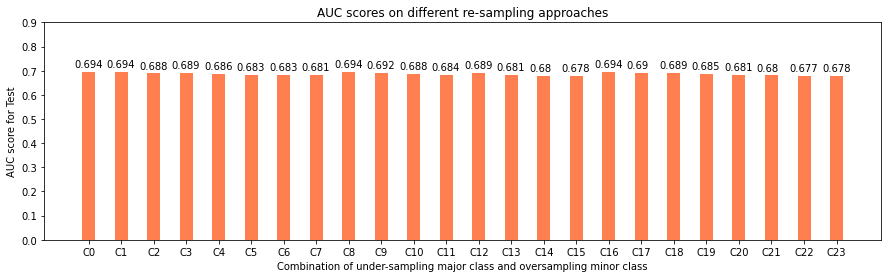

In [ ]:
comb = ['C' + str(i) for i in np.arange(0, 24, 1)]
table['Combination'] = comb

fig = plt.figure(figsize = [15, 4])
plt.bar(table['Combination'], table['AUC Score Test'], color = 'coral', width=0.4)
plt.xlabel('Combination of under-sampling major class and oversampling minor class')
plt.ylabel('AUC score for Test')
plt.title('AUC scores on different re-sampling approaches')
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(table['AUC Score Test']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

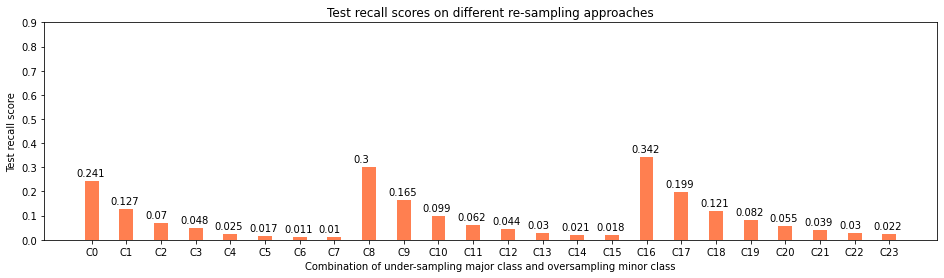

In [ ]:
comb = ['C' + str(i) for i in np.arange(0, 24, 1)]
table['Combination'] = comb

fig = plt.figure(figsize = [16, 4])
plt.bar(table['Combination'], table['Recall test'], color = 'coral', width=0.4)
plt.xlabel('Combination of under-sampling major class and oversampling minor class')
plt.ylabel('Test recall score')
plt.title('Test recall scores on different re-sampling approaches')
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(table['Recall test']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

In [ ]:
lrr = LogisticRegression()
# define different parameters
mj_minor_ratio = [0.5,0.75,1.0] # This is a parameter which defines what is the ratio between majority and minority class size in the combined data. 1 means they are equal
# What is the size of the majority that we undersample to? 0.2 means we undersample the majority class to 20% of its original size   
mj_size_pct=np.round(np.arange(0.2, 1.0, 0.1),2) 
omj_size = 223896 # the original majority size
omn_size = 19860  # the original minority size
table1 = pd.DataFrame(columns =['mj_minor_ratio','mj_size_pct', 'Accuracy train', 'Precision train','Recall train',
                               'Accuracy test', 'Precision test','Recall test','AUC Score Test'])

for j in mj_minor_ratio:
    for i in mj_size_pct:
      X_combine, y_combine =combine_smote_usm(X_train.astype('float'),y_train,i,j,omj_size,omn_size)
      lrr.fit(X_combine, y_combine)
      y_train_pred_lr_combine = lrr.predict(X_combine)
      y_test_pred_lr_combine = lrr.predict(X_test)
      y_test_proba_lr_combine = lrr.predict_proba(X_test)
      accu_tr=skm.accuracy_score(y_combine, y_train_pred_lr_combine)
      preci_tr=skm.precision_score(y_combine, y_train_pred_lr_combine)
      recall_tr=skm.recall_score(y_combine, y_train_pred_lr_combine)
      accu_te=skm.accuracy_score(y_test, y_test_pred_lr_combine)
      preci_te=skm.precision_score(y_test, y_test_pred_lr_combine)
      recall_te=skm.recall_score(y_test, y_test_pred_lr_combine)
      auc_te=skm.roc_auc_score(y_test, y_test_proba_lr_combine[:,1])
      row=pd.DataFrame([[j,i,accu_tr,preci_tr,recall_tr,accu_te,preci_te,recall_te,auc_te]],
      columns =['mj_minor_ratio','mj_size_pct', 'Accuracy train', 'Precision train','Recall train',
                'Accuracy test', 'Precision test','Recall test','AUC Score Test'])
      table1=table1.append(row)

ss_usm 0.4435094865473255
ss_smote 0.1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 44779, 1: 19860})
After smote:  Counter({0: 223896, 1: 22389})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.29567299103155037
ss_smote 0.15


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 67168, 1: 19860})
After smote:  Counter({0: 223896, 1: 33584})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.22175474327366276
ss_smote 0.2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 89558, 1: 19860})
After smote:  Counter({0: 223896, 1: 44779})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.17740379461893022
ss_smote 0.25


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 55974})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.14783649551577518
ss_smote 0.3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 134337, 1: 19860})
After smote:  Counter({0: 223896, 1: 67168})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.12671699615637874
ss_smote 0.35


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 156727, 1: 19860})
After smote:  Counter({0: 223896, 1: 78363})
ss_usm 0.11087737163683138
ss_smote 0.4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 179116, 1: 19860})
After smote:  Counter({0: 223896, 1: 89558})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.09855766367718345
ss_smote 0.45


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 201506, 1: 19860})
After smote:  Counter({0: 223896, 1: 100753})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.4435094865473255
ss_smote 0.15000000000000002


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 44779, 1: 19860})
After smote:  Counter({0: 223896, 1: 33584})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.29567299103155037
ss_smote 0.22499999999999998


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 67168, 1: 19860})
After smote:  Counter({0: 223896, 1: 50376})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.22175474327366276
ss_smote 0.30000000000000004


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 89558, 1: 19860})
After smote:  Counter({0: 223896, 1: 67168})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.17740379461893022
ss_smote 0.375


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 83961})
ss_usm 0.14783649551577518
ss_smote 0.44999999999999996


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 134337, 1: 19860})
After smote:  Counter({0: 223896, 1: 100753})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.12671699615637874
ss_smote 0.5249999999999999


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 156727, 1: 19860})
After smote:  Counter({0: 223896, 1: 117545})
ss_usm 0.11087737163683138
ss_smote 0.6000000000000001


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 179116, 1: 19860})
After smote:  Counter({0: 223896, 1: 134337})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.09855766367718345
ss_smote 0.675


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 201506, 1: 19860})
After smote:  Counter({0: 223896, 1: 151129})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.4435094865473255
ss_smote 0.2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 44779, 1: 19860})
After smote:  Counter({0: 223896, 1: 44779})
ss_usm 0.29567299103155037
ss_smote 0.3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 67168, 1: 19860})
After smote:  Counter({0: 223896, 1: 67168})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.22175474327366276
ss_smote 0.4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 89558, 1: 19860})
After smote:  Counter({0: 223896, 1: 89558})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.17740379461893022
ss_smote 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 111948, 1: 19860})
After smote:  Counter({0: 223896, 1: 111948})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.14783649551577518
ss_smote 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 134337, 1: 19860})
After smote:  Counter({0: 223896, 1: 134337})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.12671699615637874
ss_smote 0.7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 156727, 1: 19860})
After smote:  Counter({0: 223896, 1: 156727})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.11087737163683138
ss_smote 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 179116, 1: 19860})
After smote:  Counter({0: 223896, 1: 179116})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ss_usm 0.09855766367718345
ss_smote 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After usm:  Counter({0: 201506, 1: 19860})
After smote:  Counter({0: 223896, 1: 201506})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
table1

,mj_minor_ratio,mj_size_pct,Accuracy train,Precision train,Recall train,Accuracy test,Precision test,Recall test,AUC Score Test
0,0.50,0.2,0.698994,0.598565,0.294430,0.854663,0.217644,0.302115,0.703994
0,0.50,0.3,0.698517,0.594432,0.300738,0.850593,0.214167,0.312387,0.702555
0,0.50,0.4,0.696644,0.587738,0.301213,0.850249,0.213627,0.312588,0.701335
0,0.50,0.5,0.697818,0.589870,0.306696,0.848805,0.212478,0.316213,0.700374
0,0.50,0.6,0.699025,0.592835,0.309939,0.848033,0.210590,0.314804,0.699888
0,0.50,0.7,0.698907,0.592070,0.310976,0.847361,0.210287,0.317019,0.699376
0,0.50,0.8,0.698229,0.590159,0.309900,0.847574,0.210343,0.316213,0.698875
0,0.50,0.9,0.698530,0.590980,0.310462,0.847065,0.208540,0.313797,0.697734
0,0.75,0.2,0.659712,0.630597,0.497320,0.759800,0.170246,0.502920,0.702380
0,0.75,0.3,0.661080,0.631102,0.503494,0.757979,0.168429,0.500504,0.700567


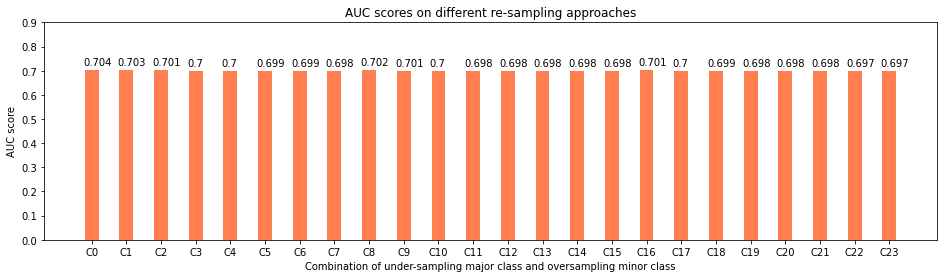

In [ ]:
comb = ['C' + str(i) for i in np.arange(0, 24, 1)]
table1['Combination'] = comb

fig = plt.figure(figsize = [10, 4])
plt.bar(table1['Combination'], table1['AUC Score Test'], color = 'coral', width=0.4)
plt.xlabel('Combination of under-sampling major class and oversampling minor class')
plt.ylabel('AUC score')
plt.title('AUC scores on different re-sampling approaches')
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(table1['AUC Score Test']):
  plt.text(i-0.25, v+0.02, str(round(v, 3)))

plt.show()

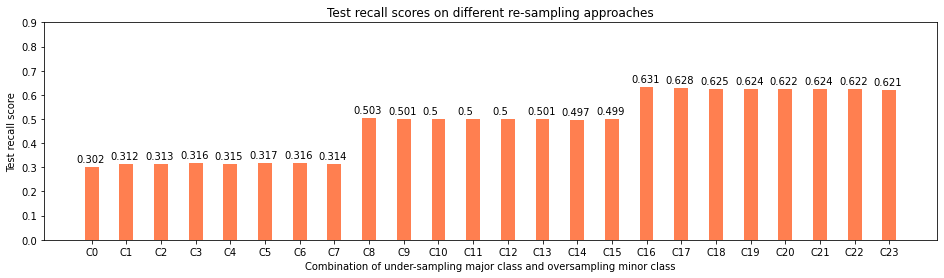

In [ ]:
comb = ['C' + str(i) for i in np.arange(0, 24, 1)]
table1['Combination'] = comb

fig = plt.figure(figsize = [10, 4])
plt.bar(table1['Combination'], table1['Recall test'], color = 'coral')
plt.xlabel('Combination of under-sampling major class and oversampling minor class')
plt.ylabel('Test recall score')
plt.title('Test recall scores on different re-sampling approaches')
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(table1['Recall test']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

### Cost-sensitive learning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
# Calculate the weights for TARGET 0 and TARGET 1
num_0 = train[train["TARGET"] == 0].shape[0]
num_1 = train[train["TARGET"] == 1].shape[0]

print(num_0/num_1)

# The inverse ratio of data distribution for TARGET 1
weight_0 = 1.0
weight_1 = 1/(num_1/num_0)

print("Weight for TARGET 0:", weight_0)
print("Weight for TARGET 1:", weight_1)

11.273716012084591
Weight for TARGET 0: 1.0
Weight for TARGET 1: 11.273716012084591


In [ ]:
# Prepare weights for algorithms
weights = {0:weight_0, 1:weight_1}

#### Cost-Sensitive Logistic Regression

In [ ]:
# Conduct Grid Search for weights
balance = [{0:1, 1:6}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}]
params = dict(class_weight = balance)

grid_lr = LogisticRegression(max_iter = 500)
grid = GridSearchCV(grid_lr, param_grid=params, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result.best_score_)
print("Best parameter:", grid_result.best_params_)

Best score: 0.6985564521526829
Best parameter: {'class_weight': {0: 1, 1: 8}}


The best parameter: {'class_weight': {0: 1, 1: 8}}
<br>The AUC score for best parameter is not as good as the AUC score for {'class_weight': {0: 1, 1: 11.273716012084591}}

balance = [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}, {0:1, 1:200}] has been used to do gridsearch, the best parameter is still: {'class_weight': {0: 1, 1: 10}}

In [ ]:
# Weighted Logistic Regression
wlr = LogisticRegression(random_state = 23, class_weight=weights, max_iter = 500)

wlr.fit(X_train, y_train)

y_train_pred_wlr = wlr.predict(X_train)
y_test_pred_wlr = wlr.predict(X_test)

y_train_proba_wlr = wlr.predict_proba(X_train)
y_test_proba_wlr = wlr.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wlr))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wlr))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wlr))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wlr))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_wlr[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_wlr))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_wlr))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_wlr))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_wlr))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_wlr[:,1]))

Train Confusion Matrix: 
 [[148276  75620]
 [  7359  12501]]
Accuracy Train: 0.6595817128604013
Precision Train: 0.1418617582642049
Recall Train: 0.6294561933534744
AUC score 0.7000718881457371

 Test Confusion Matrix: 
 [[37274 18702]
 [ 1818  3147]]
Accuracy Test: 0.6632808782264813
Precision Test: 0.14403405190168886
Recall Test: 0.6338368580060423
AUC score 0.7044255803199213


#### Cost-Sensitive Random Forest

In [ ]:
# Conduct Grid Search for weights
balance = [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}, {0:1, 1:200}]
params = dict(class_weight = balance)

grid_rf = RandomForestClassifier(random_state = 23)
grid1 = GridSearchCV(grid_rf, param_grid=params, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result1 = grid1.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result1.best_score_)
print("Best parameter:", grid_result1.best_params_)

Best score: 0.6758618296385793
Best parameter: {'class_weight': {0: 1, 1: 10}}


In [ ]:
# Conduct Grid Search for weights
balance2 = [{0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}]
params2 = dict(class_weight = balance2)

grid_rf2 = RandomForestClassifier(random_state = 23)
grid2 = GridSearchCV(grid_rf2, param_grid=params2, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result2 = grid2.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result2.best_score_)
print("Best parameter:", grid_result2.best_params_)

Best score: 0.6782121650932318
Best parameter: {'class_weight': {0: 1, 1: 12}}


In [ ]:
wrf2 = grid_result2.best_estimator_

In [ ]:
y_train_pred_wrf2 = wrf2.predict(X_train)
y_test_pred_wrf2 = wrf2.predict(X_test)

y_train_proba_wrf2 = wrf2.predict_proba(X_train)
y_test_proba_wrf2 = wrf2.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wrf2))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wrf2))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wrf2))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wrf2))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_wrf2[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_wrf2))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_wrf2))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_wrf2))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_wrf2))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_wrf2[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [    13  19847]]
Accuracy Train: 0.9999466679794549
Precision Train: 1.0
Recall Train: 0.9993454179254784
AUC score 1.0

 Test Confusion Matrix: 
 [[55976     0]
 [ 4964     1]]
Accuracy Test: 0.9185441656684334
Precision Test: 1.0
Recall Test: 0.0002014098690835851
AUC score 0.6830268054025743


In [ ]:
# Weighted Random Forest
wrf = RandomForestClassifier(random_state = 23, class_weight=weights)

wrf.fit(X_train, y_train)

y_train_pred_wrf = wrf.predict(X_train)
y_test_pred_wrf = wrf.predict(X_test)
y_test_proba_wrf= wrf.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wrf))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_wrf))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_wrf))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_wrf))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_wrf))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_wrf[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [     6  19854]]
Accuracy Train: 0.9999753852212868
Precision Train: 1.0
Recall Train: 0.9996978851963746

 Test Confusion Matrix: 
 [[55975     1]
 [ 4961     4]]
Accuracy Test: 0.9185769842962865
Precision Test: 0.8
Recall Test: 0.0008056394763343404
AUC score 0.6826846414252346


#### Cost-Sensitive Support Vector Machine - Take too long and did not get the result

In [ ]:
# Weighted Logistic Regression
wsvc = SVC(random_state = 23, class_weight=weights)

wsvc.fit(X_train, y_train)

y_train_pred_wsvc = wsvc.predict(X_train)
y_test_pred_wsvc = wsvc.predict(X_test)

y_train_proba_wsvc = wsvc.predict_proba(X_train)
y_test_proba_wsvc = wsvc.predict_proba(X_test)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wsvc))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wsvc))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wsvc))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wsvc))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_wsvc[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_wsvc))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_wsvc))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_wsvc))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_wsvc))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_wsvc[:,1]))

In [ ]:
while True:
  pass

### Boosting

#### AdaBoost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

##### Original Data with AdaBoost

In [ ]:
# a) Use AdaBoost Classifier along with GridSearchCV
# Create a dictionary of parameters
param_grid = {'n_estimators': [100, 200, 300, 400],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5]}

# Create AdaBoost Classifier model
abc = AdaBoostClassifier(random_state = 42)

# Create GridSearch object with different combination of parameters
abc_grid = GridSearchCV(abc, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = 10, verbose = 5)

# Fit GridSearch object with train data
abc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 112.7min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 210.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'n_estimators': [100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

In [ ]:
# b) Use the best estimator from GridSearchCV to predict on the test data
# Identify the best performing model
abc_bt = abc_grid.best_estimator_
print(abc_bt)

# Get predicted probabilities and predicted classes for data
y_test_pred_abc = abc_bt.predict(X_test)
y_train_pred_abc = abc_bt.predict(X_train) 

y_test_proba_abc = abc_bt.predict_proba(X_test)
y_train_proba_abc = abc_bt.predict_proba(X_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=400, random_state=42)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_abc))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_abc))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_abc))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_abc))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_abc[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_abc))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_abc))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_abc))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_abc))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_abc[:,1]))

Train Confusion Matrix: 
 [[223843     53]
 [ 19783     77]]
Accuracy Train: 0.9186235415743612
Precision Train: 0.5923076923076923
Recall Train: 0.0038771399798590133
AUC score 0.7120462854669866

 Test Confusion Matrix: 
 [[55961    15]
 [ 4953    12]]
Accuracy Test: 0.918478528412727
Precision Test: 0.4444444444444444
Recall Test: 0.002416918429003021
AUC score 0.7104743710475256


##### Under-sampling with AdaBoost with different learning rate

In [ ]:
# a) Use AdaBoost Classifier along with GridSearchCV
# Create a dictionary of parameters
param_grid1 = {'n_estimators': [100, 200, 300, 400],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5]}

# Create AdaBoost Classifier model
abc1 = AdaBoostClassifier(random_state = 42)

# Create GridSearch object with different combination of parameters
abc_grid1 = GridSearchCV(abc1, param_grid1, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
abc_grid1.fit(X_train_usm, y_train_usm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'n_estimators': [100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

In [ ]:
# b) Use the best estimator from GridSearchCV to predict on the test data
# Identify the best performing model
abc_bt1 = abc_grid1.best_estimator_
print(abc_bt1)

# Get predicted probabilities and predicted classes for data
y_test_pred_abc1 = abc_bt1.predict(X_test)
y_train_pred_abc1 = abc_bt1.predict(X_train_usm) 


y_test_proba_abc1 = abc_bt1.predict_proba(X_test)
y_train_proba_abc1 = abc_bt1.predict_proba(X_train_usm)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=400, random_state=42)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_pred_abc1))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_pred_abc1))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_pred_abc1))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_pred_abc1))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_proba_abc1[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_abc1))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_abc1))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_abc1))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_abc1))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_abc1[:,1]))

Train Confusion Matrix: 
 [[13070  6790]
 [ 6972 12888]]
Accuracy Train: 0.6535246727089628
Precision Train: 0.6549446081918894
Recall Train: 0.6489425981873111
AUC score 0.7098312735979652

 Test Confusion Matrix: 
 [[36689 19287]
 [ 1744  3221]]
Accuracy Test: 0.6548957188099965
Precision Test: 0.14310467389372666
Recall Test: 0.6487411883182276
AUC score 0.7073788277266289


In [ ]:
# a) Use AdaBoost Classifier along with GridSearchCV
# Create a dictionary of parameters
param_grid2 = {'n_estimators': [300, 400, 500, 600],
              'learning_rate': [0.4, 0.5, 0.6, 0.7, 0.8]}

# Create AdaBoost Classifier model
abc2 = AdaBoostClassifier(random_state = 42)

# Create GridSearch object with different combination of parameters
abc_grid2 = GridSearchCV(abc2, param_grid2, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
abc_grid2.fit(X_train_usm, y_train_usm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 52.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'n_estimators': [300, 400, 500, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

In [ ]:
# b) Use the best estimator from GridSearchCV to predict on the test data
# Identify the best performing model
abc_bt2 = abc_grid2.best_estimator_
print(abc_bt2)

# Get predicted probabilities and predicted classes for data
y_test_pred_abc2 = abc_bt2.predict(X_test)
y_train_pred_abc2 = abc_bt2.predict(X_train_usm) 


y_test_proba_abc2 = abc_bt2.predict_proba(X_test)
y_train_proba_abc2 = abc_bt2.predict_proba(X_train_usm)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.4,
                   n_estimators=500, random_state=42)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_pred_abc2))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_pred_abc2))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_pred_abc2))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_pred_abc2))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_proba_abc2[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_abc2))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_abc2))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_abc2))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_abc2))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_abc2[:,1]))

Train Confusion Matrix: 
 [[13116  6744]
 [ 6902 12958]]
Accuracy Train: 0.6564451158106748
Precision Train: 0.6576997259161507
Recall Train: 0.6524672708962739
AUC score 0.7133951456773446

 Test Confusion Matrix: 
 [[36741 19235]
 [ 1735  3230]]
Accuracy Test: 0.6558966869595182
Precision Test: 0.14377921210772313
Recall Test: 0.6505538771399798
AUC score 0.7075325297663896


#### XGBoost

##### Original Data with XGBoost

In [ ]:
# a) Use XGBoost Classifier along with RandomizedSearchCV
# Create a dictionary of parameters
param_grid3 = {'n_estimators': np.arange(100, 1050, 50),
              'learning_rate': np.arange(0.1, 1.7, 0.1),
               'max_depth':[1,2],
               'gamma':np.arange(0, 5.25, 0.25)}

# Create XGBoost Classifier model
clf_xgb = xgb.XGBClassifier(random_state = 42)

# Create GridSearch object with different combination of parameters
xgb_grid = RandomizedSearchCV(clf_xgb, param_grid3, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 90.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, s...
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,

In [ ]:
# Use the best estimator from RandomizedSearchCV to predict on the test data
# Identify the best performing model
xgb_bt = xgb_grid.best_estimator_
print("Best estimator:", xgb_bt)

# Get predicted probabilities and predicted classes
y_test_pred_xgb = xgb_bt.predict(X_test)
y_train_pred_xgb = xgb_bt.predict(X_train)

y_test_proba_xgb = xgb_bt.predict_proba(X_test)
y_train_proba_xgb = xgb_bt.predict_proba(X_train)

Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=4.5,
              learning_rate=1.4000000000000001, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=550, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_xgb))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_xgb))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_xgb))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_xgb))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_xgb[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_xgb))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_xgb))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_xgb))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_xgb))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_xgb[:,1]))

Train Confusion Matrix: 
 [[223807     89]
 [ 19760    100]]
Accuracy Train: 0.9185702095538161
Precision Train: 0.5291005291005291
Recall Train: 0.005035246727089627
AUC score 0.7121650501459262

 Test Confusion Matrix: 
 [[55956    20]
 [ 4951    14]]
Accuracy Test: 0.9184293004709473
Precision Test: 0.4117647058823529
Recall Test: 0.0028197381671701913
AUC score 0.7104054323526081


##### Under-sampling with XGBoost

In [ ]:
# Use XGBoost Classifier along with RandomizedSearchCV
# Create a dictionary of parameters
param_grid4 = {'n_estimators': np.arange(100, 1050, 50),
              'learning_rate': np.arange(0.1, 1.7, 0.1),
               'max_depth':[1,2],
               'gamma':np.arange(0, 5.25, 0.25)}

# Create XGBoost Classifier model
clf_xgb1 = xgb.XGBClassifier(random_state = 42)

# Create GridSearch object with different combination of parameters
xgb_grid1 = RandomizedSearchCV(clf_xgb1, param_grid4, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
xgb_grid1.fit(X_train_usm, y_train_usm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, s...
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,

In [ ]:
# Use the best estimator from RandomizedSearchCV to predict on the test data
# Identify the best performing model
xgb_bt1 = xgb_grid1.best_estimator_
print("Best estimator:", xgb_bt1)

# Get predicted probabilities and predicted classes
y_test_pred_xgb1 = xgb_bt1.predict(X_test)
y_train_pred_xgb1 = xgb_bt1.predict(X_train_usm)

y_test_proba_xgb1 = xgb_bt1.predict_proba(X_test)
y_train_proba_xgb1 = xgb_bt1.predict_proba(X_train_usm)

Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5,
              learning_rate=0.30000000000000004, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_pred_xgb1))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_pred_xgb1))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_pred_xgb1))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_pred_xgb1))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_proba_xgb1[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_xgb1))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_xgb1))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_xgb1))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_xgb1))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_xgb1[:,1]))

Train Confusion Matrix: 
 [[13152  6708]
 [ 6973 12887]]
Accuracy Train: 0.6555639476334341
Precision Train: 0.657667772390916
Recall Train: 0.6488922457200402
AUC score 0.7126920239257887

 Test Confusion Matrix: 
 [[36750 19226]
 [ 1746  3219]]
Accuracy Test: 0.6558638683316651
Precision Test: 0.1434172421474716
Recall Test: 0.6483383685800604
AUC score 0.7079848384165793


##### Cost-sensitive with XGBoost

In [ ]:
# a) Use XGBoost Classifier along with RandomizedSearchCV
# Create a dictionary of parameters
param_grid5 = {'n_estimators': np.arange(100, 1050, 50),
              'learning_rate': np.arange(0.1, 1.7, 0.1),
               'max_depth':[1,2],
               'gamma':np.arange(0, 5.25, 0.25)}

# Create XGBoost Classifier model
clf_xgb2 = xgb.XGBClassifier(random_state = 42, scale_pos_weight = weight_1)

# Create GridSearch object with different combination of parameters
xgb_grid2 = RandomizedSearchCV(clf_xgb2, param_grid5, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
xgb_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 67.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1,
                                           s...
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
                                        'learning_rate': array([0

In [ ]:
# Use the best estimator from RandomizedSearchCV to predict on the test data
# Identify the best performing model
xgb_bt2 = xgb_grid2.best_estimator_
print("Best estimator:", xgb_bt2)

# Get predicted probabilities and predicted classes
y_test_pred_xgb2 = xgb_bt2.predict(X_test)
y_train_pred_xgb2 = xgb_bt2.predict(X_train)

y_test_proba_xgb2 = xgb_bt2.predict_proba(X_test)
y_train_proba_xgb2 = xgb_bt2.predict_proba(X_train)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_xgb2))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_xgb2))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_xgb2))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_xgb2))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_xgb2[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_xgb2))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_xgb2))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_xgb2))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_xgb2))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_xgb2[:,1]))

Train Confusion Matrix: 
 [[150956  72940]
 [  6762  13098]]
Accuracy Train: 0.6730254845008944
Precision Train: 0.15223505892745065
Recall Train: 0.6595166163141994
AUC score 0.727116094281797

 Test Confusion Matrix: 
 [[37807 18169]
 [ 1780  3185]]
Accuracy Test: 0.6726505964785612
Precision Test: 0.14915238362836003
Recall Test: 0.6414904330312186
AUC score 0.7146429951060885


Search weights

In [ ]:
# a) Use XGBoost Classifier along with RandomizedSearchCV
# Create a dictionary of parameters
param_grid6 = {'n_estimators': np.arange(100, 1050, 50),
              'learning_rate': np.arange(0.01, 0.1, 0.01),
               'max_depth':[1,2],
               'gamma':np.arange(0, 5.25, 0.25),
               'scale_pos_weight': [4, 6, 8, 10, 11.273716012084591, 12, 14]}

# Create XGBoost Classifier model
clf_xgb3 = xgb.XGBClassifier(random_state = 42)

# Create GridSearch object with different combination of parameters
xgb_grid3 = RandomizedSearchCV(clf_xgb3, param_grid6, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
xgb_grid3.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 83.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'max_depth': [1, 

In [ ]:
# Use the best estimator from RandomizedSearchCV to predict on the test data
# Identify the best performing model
xgb_bt3 = xgb_grid3.best_estimator_
print("Best estimator:", xgb_bt3)

# Get predicted probabilities and predicted classes
y_test_pred_xgb3 = xgb_bt3.predict(X_test)
y_train_pred_xgb3 = xgb_bt3.predict(X_train)

y_test_proba_xgb3 = xgb_bt3.predict_proba(X_test)
y_train_proba_xgb3 = xgb_bt3.predict_proba(X_train)

Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=4.25,
              learning_rate=0.06999999999999999, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_xgb3))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_xgb3))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_xgb3))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_xgb3))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_xgb3[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_xgb3))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_xgb3))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_xgb3))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_xgb3))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_xgb3[:,1]))

Train Confusion Matrix: 
 [[200190  23706]
 [ 13158   6702]]
Accuracy Train: 0.8487667995864717
Precision Train: 0.22040252565114443
Recall Train: 0.3374622356495468
AUC score 0.7218098361314782

 Test Confusion Matrix: 
 [[50064  5912]
 [ 3325  1640]]
Accuracy Test: 0.8484271672601369
Precision Test: 0.21716101694915255
Recall Test: 0.33031218529707956
AUC score 0.7142888672904126


Search learning rate with weight 11.273716012084591



In [ ]:
# a) Use XGBoost Classifier along with RandomizedSearchCV
# Create a dictionary of parameters
param_grid7 = {'n_estimators': np.arange(100, 1050, 50),
              'learning_rate': np.arange(0.01, 0.1, 0.01),
               'max_depth':[1,2],
               'gamma':np.arange(0, 5.25, 0.25)}

# Create XGBoost Classifier model
clf_xgb4 = xgb.XGBClassifier(random_state = 42, scale_pos_weight = weight_1)

# Create GridSearch object with different combination of parameters
xgb_grid4 = RandomizedSearchCV(clf_xgb4, param_grid5, cv = 5, scoring = 'roc_auc',refit = True, n_jobs = -1, verbose = 5)

# Fit GridSearch object with train data
xgb_grid4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 80.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1,
                                           s...
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
                                        'learning_rate': array([0

In [ ]:
# Use the best estimator from RandomizedSearchCV to predict on the test data
# Identify the best performing model
xgb_bt4 = xgb_grid4.best_estimator_
print("Best estimator:", xgb_bt4)

# Get predicted probabilities and predicted classes
y_test_pred_xgb4 = xgb_bt4.predict(X_test)
y_train_pred_xgb4 = xgb_bt4.predict(X_train)

y_test_proba_xgb4 = xgb_bt4.predict_proba(X_test)
y_train_proba_xgb4 = xgb_bt4.predict_proba(X_train)

Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2.5,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=550, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.273716012084591,
              seed=None, silent=None, subsample=1, verbosity=1)


In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_xgb4))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_xgb4))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_xgb4))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_xgb4))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_xgb4[:,1]))

print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test, y_test_pred_xgb4))
print("Accuracy Test:", skm.accuracy_score(y_test, y_test_pred_xgb4))
print("Precision Test:", skm.precision_score(y_test, y_test_pred_xgb4))
print("Recall Test:", skm.recall_score(y_test, y_test_pred_xgb4))
print("AUC score", skm.roc_auc_score(y_test, y_test_proba_xgb4[:,1]))

Train Confusion Matrix: 
 [[150340  73556]
 [  6841  13019]]
Accuracy Train: 0.670174272633289
Precision Train: 0.15037828472422754
Recall Train: 0.6555387713997985
AUC score 0.7231947058591546

 Test Confusion Matrix: 
 [[37638 18338]
 [ 1766  3199]]
Accuracy Test: 0.6701071528199406
Precision Test: 0.14853507916608627
Recall Test: 0.6443101711983887
AUC score 0.7143377391202475


##### SVM Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics as skm

In [2]:
# Load the data
train= pd.read_csv("train.csv",index_col = 0)
validation=pd.read_csv("validation.csv",index_col = 0)

In [3]:
# Check the shape of train and validation set
print("Train shape:", train.shape)
print("Validation shape:", validation.shape)

Train shape: (243760, 57)
Validation shape: (60941, 57)


## Impute Missing Values

### Input columns: OWN_CAR_AGE, OCCUPATION_TYPE
Columns: ONW_CAR_AGE

In [4]:
# Calculate the mean value of car age when 'FLAG_OWN_CAR' = Y for train and validation
mean_train = train['OWN_CAR_AGE'].mean()
mean_validation = validation['OWN_CAR_AGE'].mean()
print("Car age for train:", mean_train)
print("Car age for validation:", mean_validation)

Car age for train: 12.099066321305946
Car age for validation: 11.959967082970278


In [5]:
validation['OWN_CAR_AGE'] = validation['OWN_CAR_AGE'].fillna(validation['FLAG_OWN_CAR'])
validation['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

In [6]:
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(train['FLAG_OWN_CAR'])
train['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

In [7]:
# Check the missing value rate of column OWN_CAR_AGE
print("Missing values rate for train:", train['OWN_CAR_AGE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OWN_CAR_AGE'].isna().sum()/len(validation))

Missing values rate for train: 0.0
Missing values rate for validation: 0.0


##### Column OCCUPATION_TYPE

In [8]:
# If NAME_INCOME_TYPE == Pensioner, fill na in OCCUPATION_TYPE with Retired for train and validation
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'
validation.loc[validation['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'

In [9]:
# Check the missing values rate in OCCUPATION_TYPE
print("Missing values rate for train:", train['OCCUPATION_TYPE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OCCUPATION_TYPE'].isna().sum()/len(validation))

Missing values rate for train: 0.13313915326550704
Missing values rate for validation: 0.13391641095485798


In [10]:
# Most common occupation type in train and validation
print("Most common occupation type for train:", train['OCCUPATION_TYPE'].value_counts().index[0])
print("Most common occupation type for validation:", validation['OCCUPATION_TYPE'].value_counts().index[0])

Most common occupation type for train: Retired
Most common occupation type for validation: Retired


In [11]:
# Fill the na in train and validation
train['OCCUPATION_TYPE'].fillna('Retired', inplace = True)
validation['OCCUPATION_TYPE'].fillna('Retired', inplace = True)

# Checking missing values
print("Missing values for train:", train['OCCUPATION_TYPE'].isna().sum())
print("Missing values for validation:", validation['OCCUPATION_TYPE'].isna().sum())

Missing values for train: 0
Missing values for validation: 0


#### Inpute other columns

In [12]:
missing_train = pd.DataFrame(train.isnull().sum(), columns =['missing value rate'])
print(missing_train.sort_values(ascending = False, by = 'missing value rate')[0:12])

missing_validation = pd.DataFrame(validation.isnull().sum(), columns =['missing value rate'])
print(missing_validation.sort_values(ascending = False, by = 'missing value rate')[0:10])

                          missing value rate
NAME_TYPE_SUITE                           57
EXT_SOURCE_2                              42
OBS_30_CNT_SOCIAL_CIRCLE                  33
DEF_30_CNT_SOCIAL_CIRCLE                  33
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_PHONE_CHANGE                     0
FLAG_DOCUMENT_2                            0
FLAG_DOCUMENT_3                            0
FLAG_DOCUMENT_4                            0
                          missing value rate
NAME_TYPE_SUITE                           13
EXT_SOURCE_2                              10
OBS_30_CNT_SOCIAL_CIRCLE                   3
DEF_30_CNT_SOCIAL_CIRCLE                   3
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_

In [13]:
# Define functions to fill missing values in categorical variables and numerical variables
def fill_missing(x, categorical = False):
    if categorical == True:
        val_train = train[x].value_counts().index[0]
        val_validation = validation[x].value_counts().index[0]
    
        print("For column {}:".format(x))
        print("Most common values for train:", val_train)
        print("Most common values for test:", val_validation)
    
        # Fill the na in train and validation
        train[x].fillna(val_train, inplace = True)
        validation[x].fillna(val_validation, inplace = True)
    
        # Checking missing values
        print("Missing values left in train:", train[x].isna().sum())
        print("Missing values left in validation:", validation[x].isna().sum())
    else:
        median_train = train[x].median()
        median_validation = validation[x].median()

        print("For column {}:".format(x))
        print("Median value for train:", median_train)
        print("Median value for validation:", median_validation)

        # Fill missing value for train and validation
        train[x].fillna(median_train, inplace = True)
        validation[x].fillna(median_validation, inplace = True)
    
        # Checking missing values
        print("Missing values left in train:", train[x].isna().sum())
        print("Missing values left in validation:", validation[x].isna().sum())

##### Column: NAME_TYPE_SUITE

```
# This is formatted as code
```



In [14]:
# Fill column NAME_TYPE_SUITE
fill_missing('NAME_TYPE_SUITE', categorical = True)

For column NAME_TYPE_SUITE:
Most common values for train: Unaccompanied
Most common values for test: Unaccompanied
Missing values left in train: 0
Missing values left in validation: 0


##### Column: EXT_SOURCE_2 

In [15]:
# Fill column EXT_SOURCE_2
fill_missing('EXT_SOURCE_2')

For column EXT_SOURCE_2:
Median value for train: 0.5657357988357584
Median value for validation: 0.5660312575232652
Missing values left in train: 0
Missing values left in validation: 0


##### Column: OBS_30_CNT_SOCIAL_CIRCLE

In [16]:
# Fill column OBS_30_CNT_SOCIAL_CIRCLE
fill_missing('OBS_30_CNT_SOCIAL_CIRCLE')

For column OBS_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


##### Column: DEF_30_CNT_SOCIAL_CIRCLE

In [17]:
# Fill column DEF_30_CNT_SOCIAL_CIRCLE
fill_missing('DEF_30_CNT_SOCIAL_CIRCLE')

For column DEF_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


In [18]:
print("Check missing values in train:", train.isna().values.any())
print("Check missing values in validation:", validation.isna().values.any())

Check missing values in train: False
Check missing values in validation: False


### Deal with Categorical Variable

In [19]:
# Columns that are categorical variables
cat_train_idx = train.dtypes[train.dtypes == 'object'].index
cat_train_idx

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

##### Categorical variable: OCCUPATION_TYPE

In [20]:
train['OCCUPATION_TYPE'].value_counts()

Retired                  76312
Laborers                 43794
Sales staff              25489
Core staff               21914
Managers                 16895
Drivers                  14865
High skill tech staff     9016
Accountants               7705
Medicine staff            6757
Security staff            5343
Cooking staff             4692
Cleaning staff            3693
Private service staff     2076
Low-skill Laborers        1676
Waiters/barmen staff      1068
Secretaries               1007
Realty agents              584
HR staff                   447
IT staff                   427
Name: OCCUPATION_TYPE, dtype: int64

In [21]:
# Deal with the levels in data
train.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [22]:
train['OCCUPATION_TYPE'].value_counts()

White collar    90241
Retired         76312
Laborers        43794
Blue collar     33413
Name: OCCUPATION_TYPE, dtype: int64

In [23]:
# Deal with the values in validation
validation.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [24]:
validation['OCCUPATION_TYPE'].value_counts()

White collar    22517
Retired         19167
Laborers        10970
Blue collar      8287
Name: OCCUPATION_TYPE, dtype: int64

##### Categorical Variable: NAME_INCOME_TYPE

In [25]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Unemployed                  15
Student                     14
Businessman                  8
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Group unemployed, student, businessman and maternity leave in a small group - other.
<br> The reason to group these four levels is that only a few records are in those levels. It always happens that only train set contains some levels. For instance, Maternity leave only has 5 records. When doing train test split, only train set contains this 5 records. After doing one hot encoding, this results in the train and validation set in different shape.  

In [26]:
# Deal with train
train.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                   'Student': 'Other',
                                   'Businessman': 'Other',
                                   'Maternity leave': 'Other'}}, inplace = True)

In [27]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Other                       42
Name: NAME_INCOME_TYPE, dtype: int64

In [28]:
# Deal with validation
validation.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                        'Student': 'Other',
                                        'Businessman': 'Other',
                                        'Maternity leave': 'Other'}}, inplace = True)

In [29]:
validation['NAME_INCOME_TYPE'].value_counts()

Working                 31387
Commercial associate    14243
Pensioner               11006
State servant            4296
Other                       9
Name: NAME_INCOME_TYPE, dtype: int64

##### Categorical variable: ORGANIZATION_TYPE

In [30]:
train['ORGANIZATION_TYPE'].value_counts()[0:20]

Business Entity Type 3    53886
XNA                       43865
Self-employed             30488
Other                     13161
Medicine                   8825
Business Entity Type 2     8364
Government                 8333
School                     7037
Trade: type 7              6169
Kindergarten               5529
Construction               5286
Business Entity Type 1     4731
Transport: type 4          4316
Trade: type 3              2757
Industry: type 9           2674
Industry: type 3           2638
Security                   2596
Housing                    2318
Industry: type 11          2155
Military                   2090
Name: ORGANIZATION_TYPE, dtype: int64

In [31]:
# Drop columns ORGANIZATION_TYPE
train = train.drop('ORGANIZATION_TYPE', axis = 1)
validation = validation.drop('ORGANIZATION_TYPE', axis = 1)

#### One-Hot Encoding

In [32]:
# Conduct one-hot encoding, drop_first should be True to get the dummy variables
train = pd.get_dummies(train, drop_first = True)
validation = pd.get_dummies(validation, drop_first = True)

In [33]:
print("Train shape:", train.shape)
print("validation shape:", validation.shape)

Train shape: (243760, 82)
validation shape: (60941, 81)


In [34]:
# We have one column missing for validation. Match columns in train and validation
def list_diff(list1, list2): 
    list_difference = []
    for item in list1: 
        if item not in list2:
            list_difference.append(item)
    return list_difference
list_diff(list(train.columns),list(validation.columns))

['CODE_GENDER_XNA']

After further exploration, we find that 'CODE_GENDER_XNA' only has four records, we can drop this column as well.

In [35]:
train['CODE_GENDER_XNA'].sort_values(ascending = False)[0:5]

SK_ID_CURR
319880    1
144669    1
196708    1
141289    1
166591    0
Name: CODE_GENDER_XNA, dtype: uint8

In [36]:
# Drop the four rows
train.drop([319880, 144669, 196708, 141289], inplace = True)

In [37]:
# Then drop the column CODE_GENDER_XNA' in train
train.drop('CODE_GENDER_XNA', axis = 1, inplace = True)

In [38]:
print(train.shape)
print(validation.shape)

(243756, 81)
(60941, 81)


### Normalize the data

In [39]:
# Prepare X_train, X_validation, y_train, y_validation
X_train_rw = train.drop('TARGET', axis = 1)
X_validation_rw = validation.drop('TARGET', axis = 1)

y_train = train['TARGET']
y_validation = validation['TARGET']

print("X_train shape:", X_train_rw.shape, "y_train shape:", y_train.shape)
print("X_validation shape:", X_validation_rw.shape, "y_validation shape:", y_validation.shape)

X_train shape: (243756, 80) y_train shape: (243756,)
X_validation shape: (60941, 80) y_validation shape: (60941,)


In [40]:
# Standardize the train and validation data
scaler = StandardScaler()
scaler.fit(X_train_rw, y_train)

StandardScaler()

In [41]:
X_train = scaler.transform(X_train_rw)
X_validation = scaler.transform(X_validation_rw)

In [42]:
X_test=X_validation 
y_test=y_validation

## Undersampling Majority Class using Randomundersampling (USM)

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import metrics as skm

In [44]:
# extreme undersampling major class 
under = RandomUnderSampler(sampling_strategy=1)
X_train_usm, y_train_usm = under.fit_sample(X_train.astype('float'), y_train)
print("Before usm: ", Counter(y_train))
print("After usm: ", Counter(y_train_usm))

Before usm:  Counter({0: 223896, 1: 19860})
After usm:  Counter({0: 19860, 1: 19860})


## Original Data - LinearSVM + RandomizedSearchCV

In [46]:
#Fit model on the training data
linearsvm_rd = LinearSVC(random_state=42)
param1 = {"C": np.arange(0.01, 10, 0.2)}
linearsvm_rd = RandomizedSearchCV(linearsvm_rd, param1, cv = 5, verbose = 0, n_jobs = -1)
linearsvm_rd.fit(X_train, y_train)

/Users/amilyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=-1,
                   param_distributions={'C': array([0.01, 0.21, 0.41, 0.61, 0.81, 1.01, 1.21, 1.41, 1.61, 1.81, 2.01,
       2.21, 2.41, 2.61, 2.81, 3.01, 3.21, 3.41, 3.61, 3.81, 4.01, 4.21,
       4.41, 4.61, 4.81, 5.01, 5.21, 5.41, 5.61, 5.81, 6.01, 6.21, 6.41,
       6.61, 6.81, 7.01, 7.21, 7.41, 7.61, 7.81, 8.01, 8.21, 8.41, 8.61,
       8.81, 9.01, 9.21, 9.41, 9.61, 9.81])})

In [47]:
print(linearsvm_rd.best_estimator_)

LinearSVC(C=0.6100000000000001, random_state=42)


In [48]:
linearsvm_rd_pred = linearsvm_rd.best_estimator_.predict(X_test)

In [49]:
decision_scores = linearsvm_rd.decision_function(X_test)
fpr, tpr, thres = roc_curve(y_test, decision_scores)
print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))

AUC: 0.704


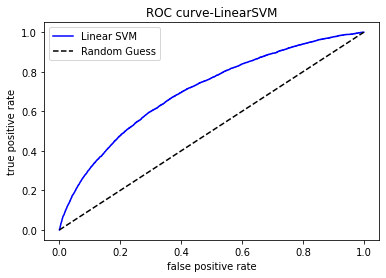

In [50]:
plt.plot(fpr, tpr, "b", label='Linear SVM')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve-LinearSVM")
plt.show()

In [51]:
print("Accuracy Test:", skm.accuracy_score(y_test, linearsvm_rd_pred))
print("Precision Test:", skm.precision_score(y_test, linearsvm_rd_pred))
print("Recall Test:", skm.recall_score(y_test, linearsvm_rd_pred))

Accuracy Test: 0.9182652073316815
Precision Test: 0.05555555555555555
Recall Test: 0.0002014098690835851


In [52]:
auc_OD = roc_auc_score(y_test, decision_scores)
accuracy_OD = skm.accuracy_score(y_test, linearsvm_rd_pred)
recall_OD = skm.recall_score(y_test, linearsvm_rd_pred)

In [54]:
linearsvm_rd_pred_train = linearsvm_rd.best_estimator_.predict(X_train)
decision_scores_train = linearsvm_rd.decision_function(X_train)
auc_OD_train = roc_auc_score(y_train, decision_scores_train)
accuracy_OD_train = skm.accuracy_score(y_train, linearsvm_rd_pred_train)
recall_OD_train = skm.recall_score(y_train, linearsvm_rd_pred_train)

In [58]:
print("Accuracy Test:", skm.accuracy_score(y_train, linearsvm_rd_pred_train))
print("Precision Test:", skm.precision_score(y_train, linearsvm_rd_pred_train))
print("Recall Test:", skm.recall_score(y_train, linearsvm_rd_pred_train))

Accuracy Test: 0.9183199593035659
Precision Test: 0.17105263157894737
Recall Test: 0.0006545820745216516


## Original Data- LinearSVC + RandomizedSearchCV + Weighted Cost Function

In [59]:
weights =  [{0:1,1:4}, {0:1, 1:6}, {0:1,1:8}, {0:1, 1:10}, {0:1, 1:12}]

In [60]:
#Fit model on the training data
linearsvm_weight = LinearSVC(random_state=42)
param_weight = {"C": np.arange(0.01, 10, 0.2), "class_weight": weights}
linearsvm_weight = RandomizedSearchCV(linearsvm_weight, param_weight, cv = 5, verbose = 0, n_jobs = -1)
linearsvm_weight.fit(X_train, y_train)

/Users/amilyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=-1,
                   param_distributions={'C': array([0.01, 0.21, 0.41, 0.61, 0.81, 1.01, 1.21, 1.41, 1.61, 1.81, 2.01,
       2.21, 2.41, 2.61, 2.81, 3.01, 3.21, 3.41, 3.61, 3.81, 4.01, 4.21,
       4.41, 4.61, 4.81, 5.01, 5.21, 5.41, 5.61, 5.81, 6.01, 6.21, 6.41,
       6.61, 6.81, 7.01, 7.21, 7.41, 7.61, 7.81, 8.01, 8.21, 8.41, 8.61,
       8.81, 9.01, 9.21, 9.41, 9.61, 9.81]),
                                        'class_weight': [{0: 1, 1: 4},
                                                         {0: 1, 1: 6},
                                                         {0: 1, 1: 8},
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 12}]})

In [61]:
print(linearsvm_weight.best_estimator_)

LinearSVC(C=3.21, class_weight={0: 1, 1: 4}, random_state=42)


In [62]:
linearsvm_weight_pred = linearsvm_weight.best_estimator_.predict(X_test)

In [63]:
decision_scores_w = linearsvm_weight.decision_function(X_test)
fpr_w, tpr_w, thres_w = roc_curve(y_test, decision_scores_w)
print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores_w)))

AUC: 0.635


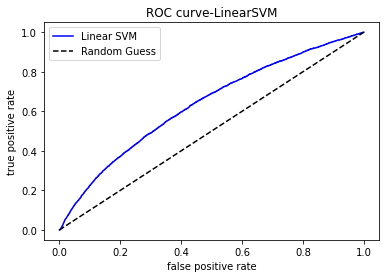

In [64]:
plt.plot(fpr_w, tpr_w, "b", label='Linear SVM')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve-LinearSVM")
plt.show()

In [65]:
print("Accuracy Test:", skm.accuracy_score(y_test, linearsvm_weight_pred))
print("Precision Test:", skm.precision_score(y_test, linearsvm_weight_pred))
print("Recall Test:", skm.recall_score(y_test, linearsvm_weight_pred))

Accuracy Test: 0.9100441410544625
Precision Test: 0.17153748411689962
Recall Test: 0.027190332326283987


In [66]:
auc_OD_w = roc_auc_score(y_test, decision_scores_w)
accuracy_OD_w = skm.accuracy_score(y_test, linearsvm_weight_pred)
recall_OD_w = skm.recall_score(y_test, linearsvm_weight_pred)

In [67]:
linearsvm_w_pred_train = linearsvm_weight.best_estimator_.predict(X_train)
decision_scores_w_train = linearsvm_weight.decision_function(X_train)
auc_OD_w_train = roc_auc_score(y_train, decision_scores_w_train)
accuracy_OD_w_train = skm.accuracy_score(y_train, linearsvm_w_pred_train)
recall_OD_w_train = skm.recall_score(y_train, linearsvm_w_pred_train)

In [68]:
print("Accuracy Test:", skm.accuracy_score(y_train, linearsvm_w_pred_train))
print("Precision Test:", skm.precision_score(y_train, linearsvm_w_pred_train))
print("Recall Test:", skm.recall_score(y_train, linearsvm_w_pred_train))

Accuracy Test: 0.9102750291274881
Precision Test: 0.18956468045693114
Recall Test: 0.03091641490433031


## USM- LinearSVC + RandomizedSearchCV

In [69]:
# run with extreme undersampling
linearsvm_usm = LinearSVC(random_state=42)

param_usm = {"C": np.arange(0.01, 10, 0.2)}
linearsvm_usm_rd = RandomizedSearchCV(linearsvm_usm, param1, cv = 5, verbose = 0, n_jobs = -1)
linearsvm_usm_rd.fit(X_train_usm, y_train_usm)

/Users/amilyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=-1,
                   param_distributions={'C': array([0.01, 0.21, 0.41, 0.61, 0.81, 1.01, 1.21, 1.41, 1.61, 1.81, 2.01,
       2.21, 2.41, 2.61, 2.81, 3.01, 3.21, 3.41, 3.61, 3.81, 4.01, 4.21,
       4.41, 4.61, 4.81, 5.01, 5.21, 5.41, 5.61, 5.81, 6.01, 6.21, 6.41,
       6.61, 6.81, 7.01, 7.21, 7.41, 7.61, 7.81, 8.01, 8.21, 8.41, 8.61,
       8.81, 9.01, 9.21, 9.41, 9.61, 9.81])})

In [70]:
print(linearsvm_usm_rd.best_params_)

{'C': 0.01}


In [71]:
linearsvm_usm_rd_pred = linearsvm_usm_rd.best_estimator_.predict(X_test)

In [72]:
decision_scores_usm = linearsvm_usm_rd.decision_function(X_test)
fpr_usm, tpr_usm, thres_usm = roc_curve(y_test, decision_scores_usm)
print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores_usm)))

AUC: 0.704


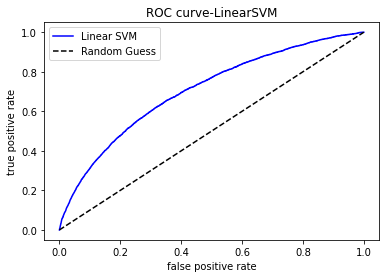

In [73]:
plt.plot(fpr_usm, tpr_usm, "b", label='Linear SVM')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve-LinearSVM")
plt.show()

In [74]:
print("Accuracy Test:", skm.accuracy_score(y_test, linearsvm_usm_rd_pred))
print("Precision Test:", skm.precision_score(y_test, linearsvm_usm_rd_pred))
print("Recall Test:", skm.recall_score(y_test, linearsvm_usm_rd_pred))

Accuracy Test: 0.6637403390164257
Precision Test: 0.14421887172906833
Recall Test: 0.6338368580060423


In [77]:
auc_usm = roc_auc_score(y_test, decision_scores_usm)
accuracy_usm = skm.accuracy_score(y_test, linearsvm_usm_rd_pred)
recall_usm = skm.recall_score(y_test, linearsvm_usm_rd_pred)

In [78]:
linearsvm_usm_pred_train = linearsvm_usm_rd.best_estimator_.predict(X_train)
decision_scores_usm_train = linearsvm_usm_rd.decision_function(X_train)
auc_usm_train = roc_auc_score(y_train, decision_scores_usm_train)
accuracy_usm_train = skm.accuracy_score(y_train, linearsvm_usm_pred_train)
recall_usm_train = skm.recall_score(y_train, linearsvm_usm_pred_train)

In [80]:
print("Accuracy Test:", skm.accuracy_score(y_train, linearsvm_usm_pred_train))
print("Precision Test:", skm.precision_score(y_train, linearsvm_usm_pred_train))
print("Recall Test:", skm.recall_score(y_train, linearsvm_usm_pred_train))

Accuracy Test: 0.6592247985690609
Precision Test: 0.14179493573323057
Recall Test: 0.6299093655589124


## Create Table

In [83]:
data_train = {"Accuracy": [accuracy_OD_train, accuracy_OD_w_train, accuracy_usm_train], "Recall": [recall_OD_train, recall_OD_w_train, recall_usm_train], "AUC": [auc_OD_train, auc_OD_w_train, auc_usm_train]}


In [84]:
df_train = pd.DataFrame(data_train, columns = ["Accuracy", "Recall","AUC"], index = ["Original Data + RandomizedSearchCV", "Original Data + Weighted Cost Function", "Undersampling + RandomizedSearchCV"])
df_train

,Accuracy,Recall,AUC
Original Data + RandomizedSearchCV,0.918320,0.000655,0.698785
Original Data + Weighted Cost Function,0.910275,0.030916,0.629627
Undersampling + RandomizedSearchCV,0.659225,0.629909,0.699494


In [88]:
data_test = {"Accuracy": [accuracy_OD, accuracy_OD_w, accuracy_usm], "Recall": [recall_OD, recall_OD_w, recall_usm], "AUC": [auc_OD, auc_OD_w, auc_usm]}


In [89]:
df_test = pd.DataFrame(data_test, columns = ["Accuracy", "Recall","AUC"], index = ["Original Data + RandomizedSearchCV", "Original Data + Weighted Cost Function", "Undersampling + RandomizedSearchCV"])
df_test

,Accuracy,Recall,AUC
Original Data + RandomizedSearchCV,0.918265,0.000201,0.703843
Original Data + Weighted Cost Function,0.910044,0.027190,0.635207
Undersampling + RandomizedSearchCV,0.663740,0.633837,0.704300


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('ggplot')

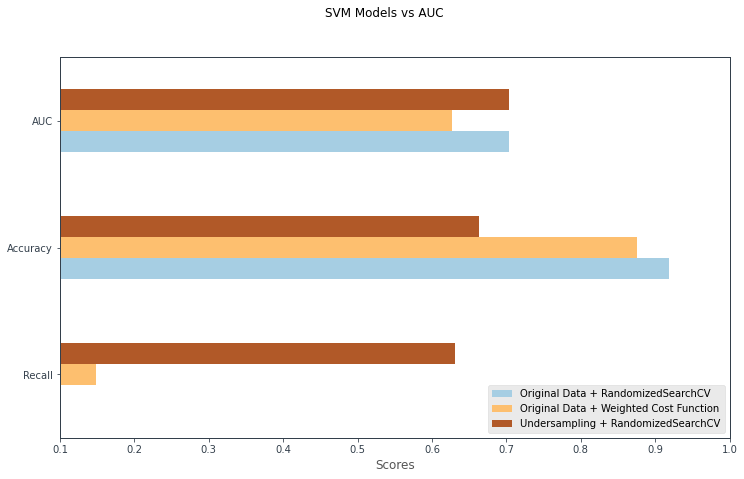

In [219]:
fig, ax = plt.subplots(figsize=(12,7))
fig.suptitle('SVM Models vs AUC')


plot = df.plot(kind='barh', legend = False, ax=ax, colormap='Paired')
ax.set_xlabel('Scores')
plt.xlim(0.1, 1)
plt.legend(loc= 0, fontsize='medium')
ax.set_facecolor('white')

plt.show()

## Random Forest Implementation

## EDA

### Explore Data

In [8]:
# Check the number of rows and columns, and the data types
print("Data shape: \n", data.shape)
print("\n Data type: \n", data.dtypes.value_counts())

Data shape: 
 (307511, 121)

 Data type: 
 float64    65
int64      40
object     16
dtype: int64


In [9]:
# Explore the response variable
print("Missing values in Target: \n", data['TARGET'].isna().any())
print("\n Value counts in Target: \n", data['TARGET'].value_counts())
print("\n The ratio of minor class: \n", data['TARGET'].value_counts()[1]/len(data))

Missing values in Target: 
 False

 Value counts in Target: 
 0    282686
1     24825
Name: TARGET, dtype: int64

 The ratio of minor class: 
 0.08072881945686496


### Univariate Analysis

In [10]:
# Univariate analysis for categorical feature
categorical = data.dtypes[data.dtypes == 'object'].index
data_c = data[categorical]

numerical = data.dtypes[data.dtypes != 'object'].index
data_num = data[numerical]

In [11]:
# Define function to conduct univariate analysis
def draw_histograms(df, variables, n_rows, n_cols, size):
  fig = plt.figure(figsize=size)
  for i, var_name in enumerate(variables):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    df[var_name].hist(bins = 10, ax = ax, grid = False)
    ax.set_title(var_name)
    if df[var_name].dtypes == 'object':
      plt.xticks(rotation = 90)
  plt.subplots_adjust(hspace = 1.5)
  plt.show()

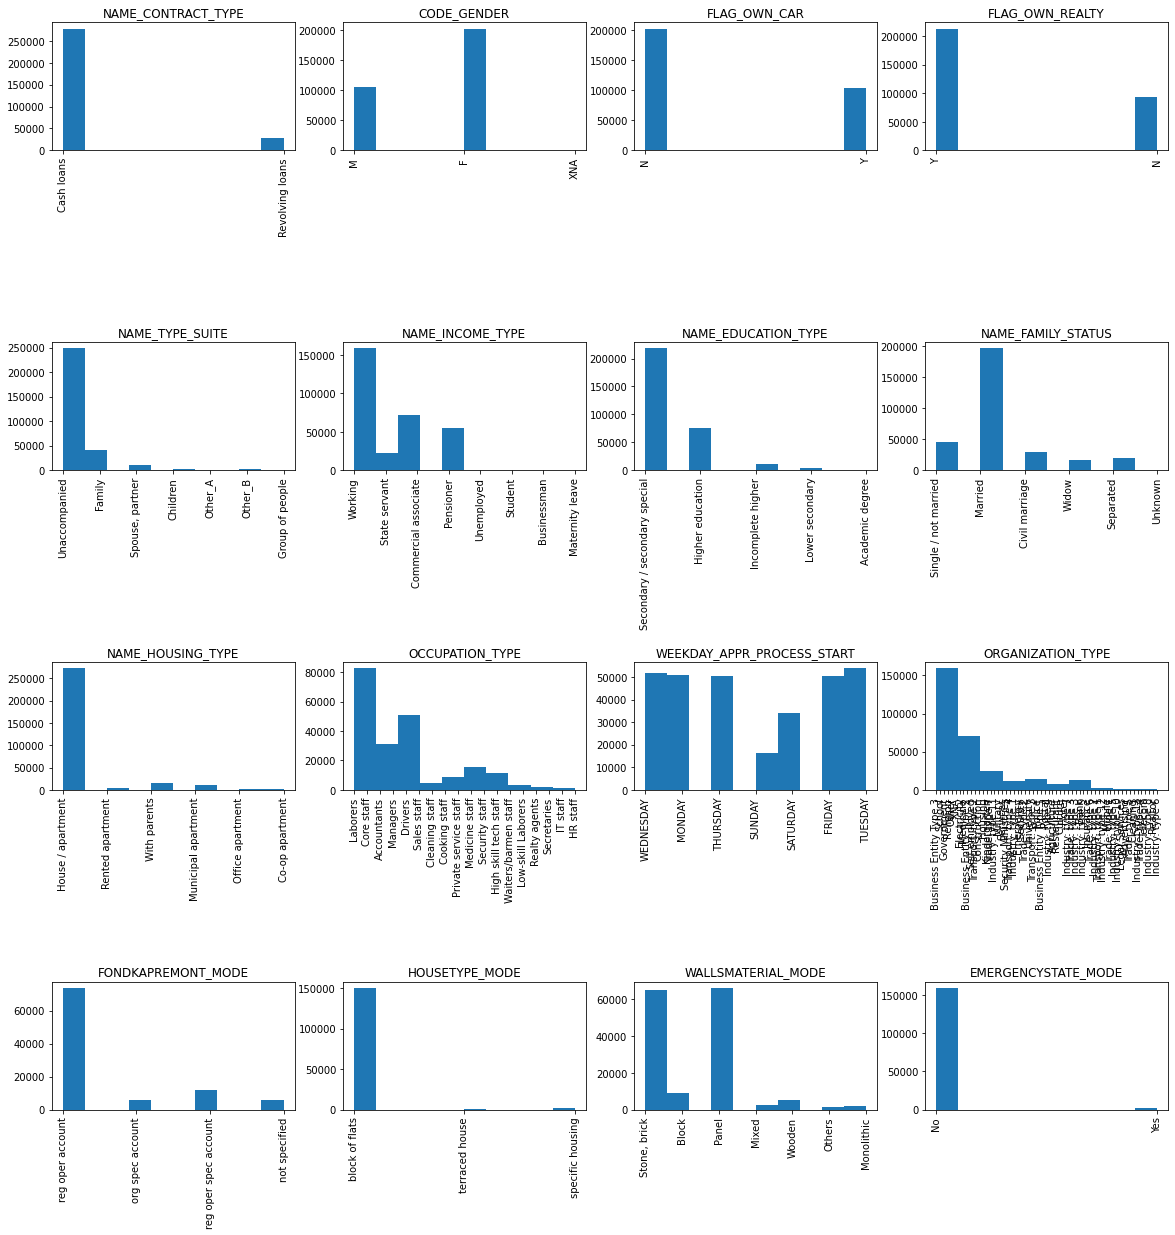

In [12]:
# Draw histogram for categorical variables
draw_histograms(data_c, data_c.columns, 4, 4, [20, 20])

Multiple levels of some categorical variable needs to be combined

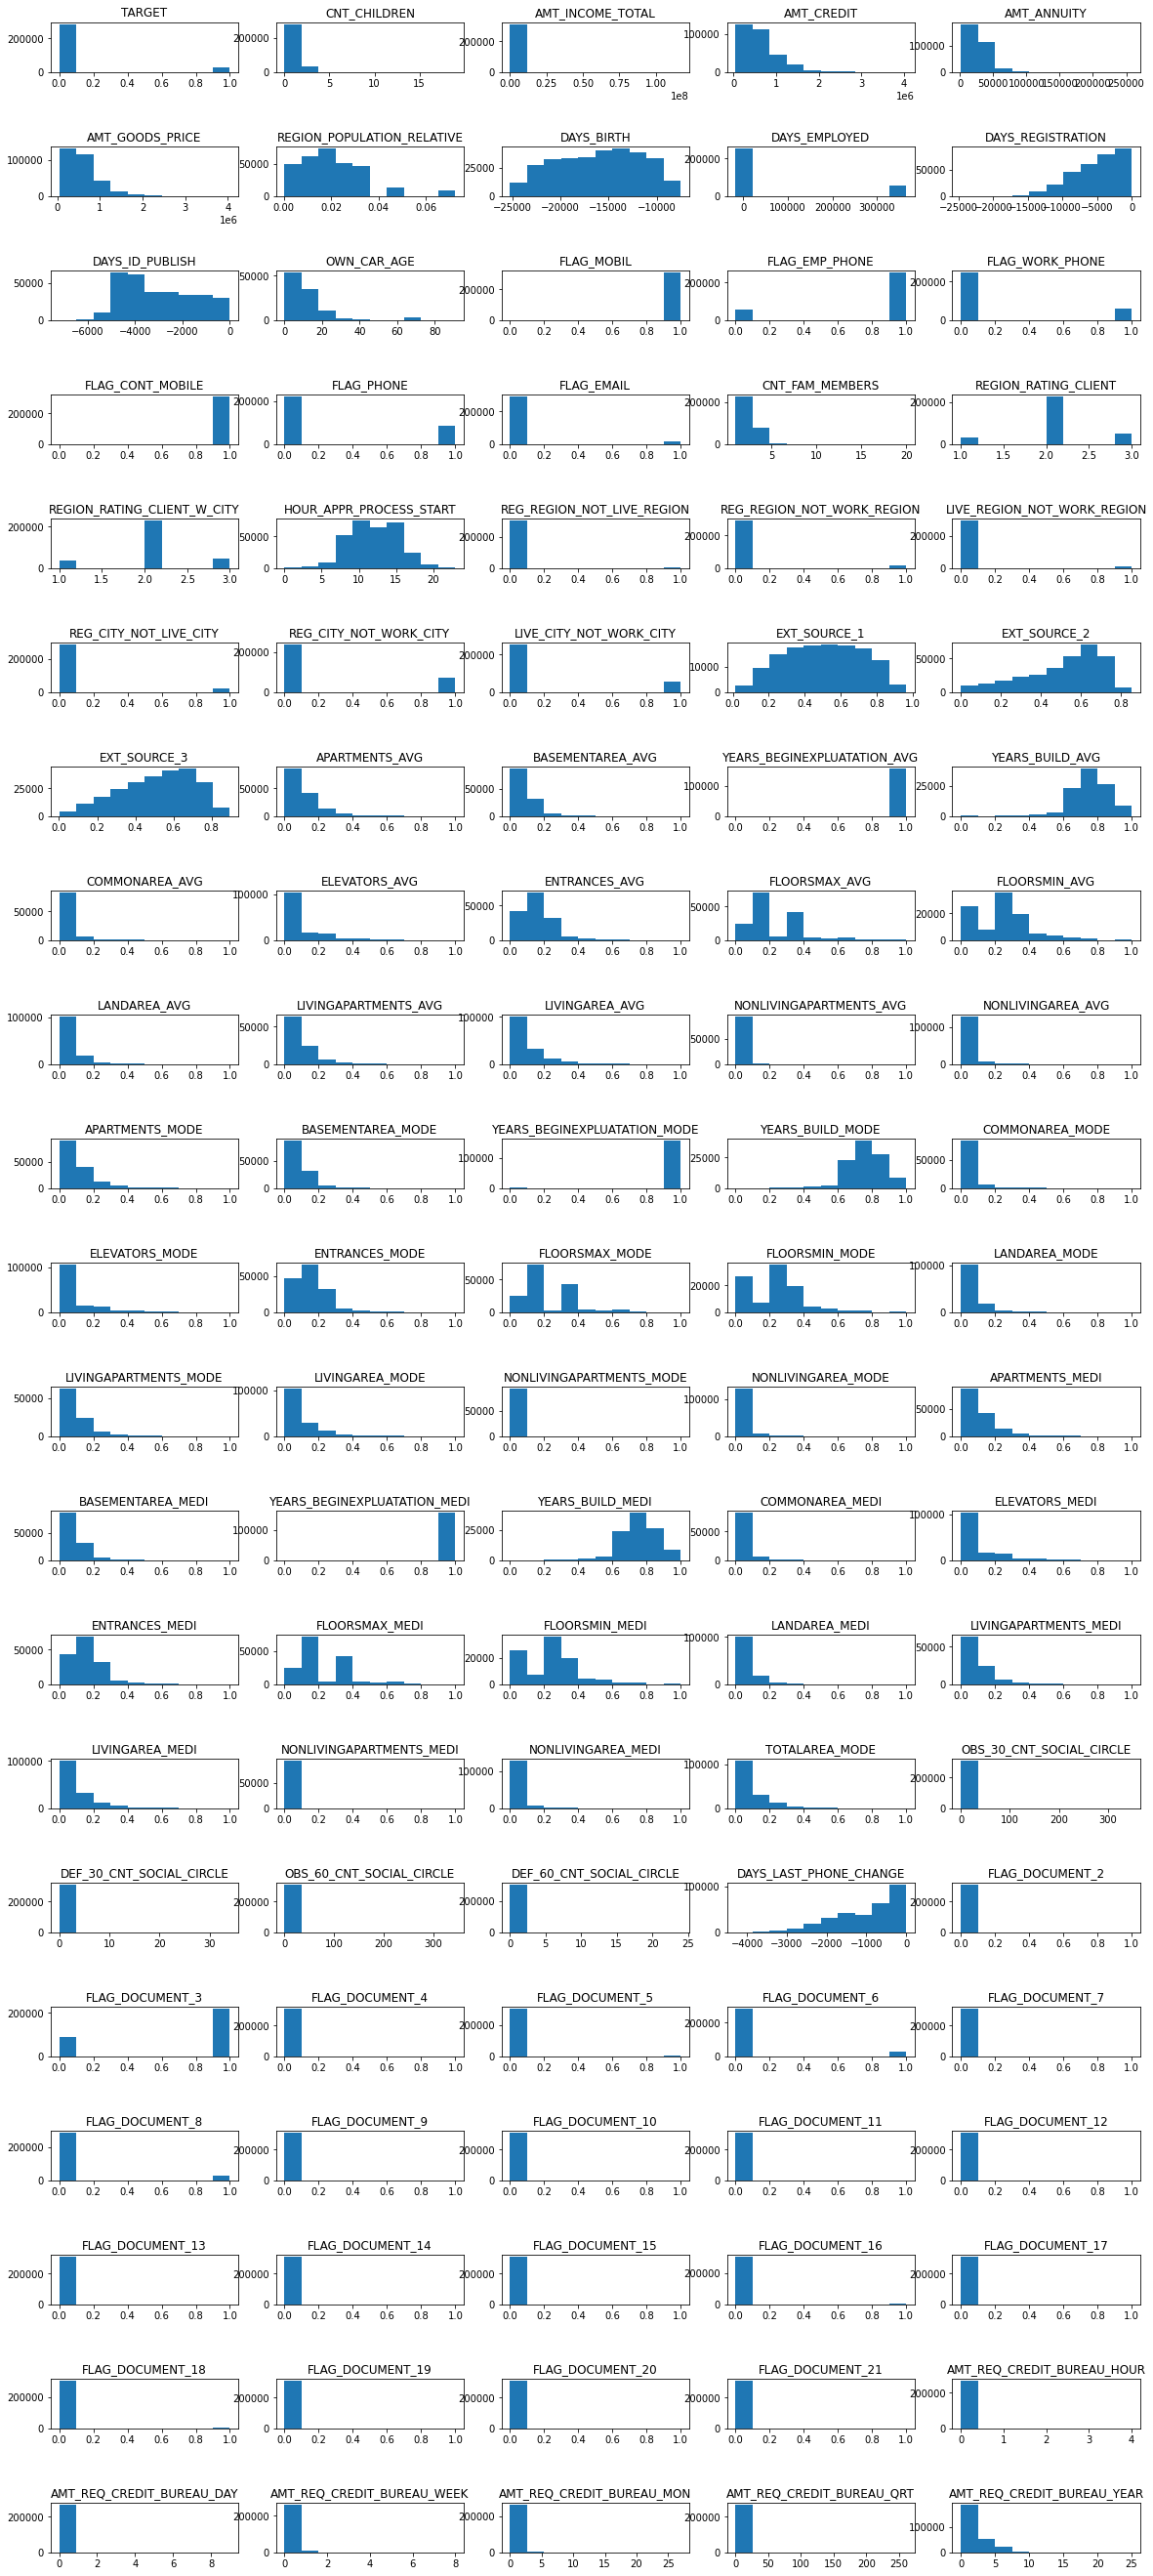

In [13]:
# Draw histogram for numerical variable
draw_histograms(data_num, data_num.columns, 22, 5, [20, 50])

### Bivariate Analysis

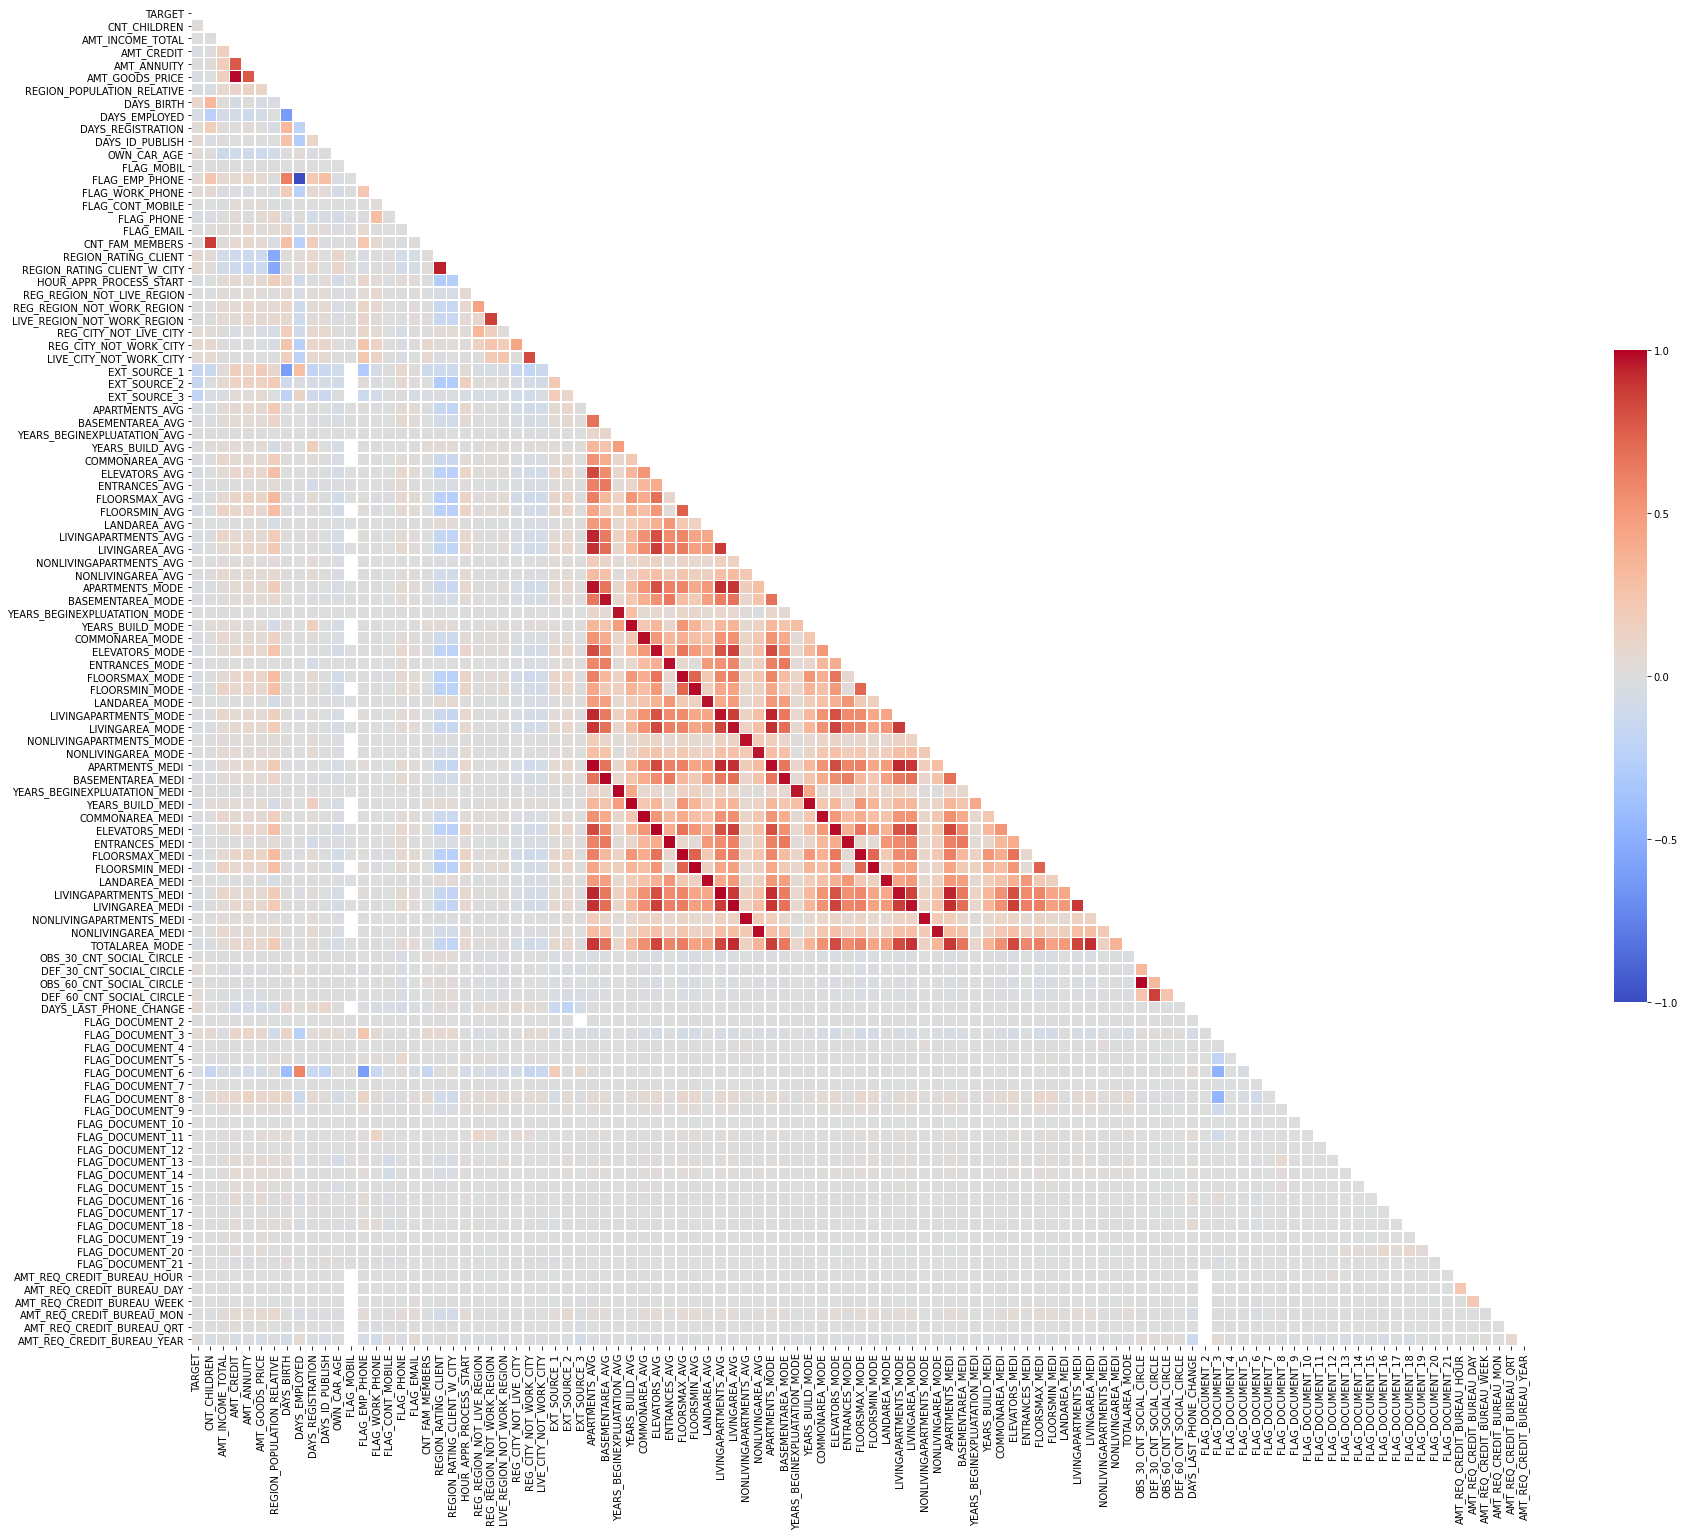

In [14]:
correlation = data.corr()

mask = np.zeros_like(correlation.iloc[:121,:121], dtype=np.bool)              # Create an array of zeros with the same shape and type as a given array.
mask[np.triu_indices_from(mask)] = True                                          # Set the indices for the upper-triangle of array to be True

f, ax = plt.subplots(figsize=(30, 30))

heatmap = sns.heatmap(correlation.iloc[:121,:121],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(correlation.iloc[:121,:121].columns, rotation = 0)
ax.set_xticklabels(correlation.iloc[:121,:121].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

It seems like some features are highly correlated. We will explore later to decide which feature to drop

### Missing Values

In [15]:
# Check missing values for each columns
missing_values = pd.DataFrame(data.isnull().sum()/len(data), columns =['missing value rate'])

# Display all the missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(missing_values.sort_values(ascending = False, by = 'missing value rate'))

,missing value rate
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MODE,0.683550


#### Check columns with missing value rate > 0.15

In [16]:
# Columns with missing value rate above 0.3
missing_values[missing_values['missing value rate'] > 0.15].index

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

##### Column: 'OWN_CAR_AGE'

In [17]:
# Check missing values in column car age
print("Missing values:", data['OWN_CAR_AGE'].isna().sum(axis = 0))

# Check how many of the missing values has N in the column FLAG_OWN_CAR
car = data.loc[data['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE']
print("Missing values with N in the column FLAG_OWN_CAR:", car.shape[0])

Missing values: 202929
Missing values with N in the column FLAG_OWN_CAR: 202924


We can see most na in column OWN_CAR_AGE is because people don't have cars, total 202924 rows. We will just keep this column and encode those na values

##### Column: OCCUPATION TYPE

In [18]:
# Deal with OCCUPATION TYPE
# Choose the subset where columns OCCUPATION TYPE contains na
ocp = data.loc[data['OCCUPATION_TYPE'].isna()]
ocp.shape

(96391, 121)

In [19]:
# Separate data into categorical and numerical variables
categorical = ocp.dtypes[ocp.dtypes == 'object'].index
ocp_c = ocp[categorical]

numerical = ocp.dtypes[ocp.dtypes != 'object'].index
ocp_num = ocp[numerical]

In [20]:
# Plot histogram for categorical variables
# draw_histograms(ocp_c, ocp_c.columns, 4, 4, [20, 20])

In [21]:
# draw_histograms(ocp_num, ocp_num.columns, 22, 5, [20, 50])

In [22]:
# We can see many Pensioner left this column na, total 55357 rows
ocp['NAME_INCOME_TYPE'].value_counts()

Pensioner               55357
Working                 24920
Commercial associate    12297
State servant            3787
Unemployed                 22
Student                     5
Businessman                 2
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

In [23]:
# How many missing values left, if we fill OCCUPATION_TYPE with Retired for Pensioner
ocp.loc[ocp['NAME_INCOME_TYPE'] != 'Pensioner'].shape[0]/len(data)

0.13343912900676724

There will be only 13% missing value in this column if we fill this column with 'Retired' for pensioner. The ratio is below our threshold. So we will keep this column as well.

##### Column: EXT_SOURCE_1

In [24]:
# Deal with 'EXT_SOURCE_1'
# Choose the subset where columns 'EXT_SOURCE_1' contains na
ext1 = data.loc[data['EXT_SOURCE_1'].isna()]
ext1.shape

(173378, 121)

In [25]:
# Separate data into categorical and numerical variables and plot histogram
categorical = ext1.dtypes[ext1.dtypes == 'object'].index
ext1_c = ext1[categorical]

numerical = ext1.dtypes[ext1.dtypes != 'object'].index
ext1_num = ext1[numerical]

In [26]:
# draw_histograms(ext1_c, ext1_c.columns, 4, 4, [20, 20])

In [27]:
# draw_histograms(ext1_num, ext1_num.columns, 22, 5, [20, 50])

From the histograms, We did not see any structural defficiency and particular pattern in the missing values. Assume the missing value in this column is missing at random and will drop it later.

##### Column: EXT_SOURCE_3

In [28]:
# Deal with 'EXT_SOURCE_3'
# Choose the subset where columns 'EXT_SOURCE_3' contains na
ext3 = data.loc[data['EXT_SOURCE_3'].isna()]
ext3.shape

(60965, 121)

In [29]:
# Separate data into categorical and numerical variables and plot histogram
categorical = ext3.dtypes[ext3.dtypes == 'object'].index
ext3_c = ext3[categorical]

numerical = ext3.dtypes[ext3.dtypes != 'object'].index
ext3_num = ext3[numerical]

In [30]:
# draw_histograms(ext3_c, ext3_c.columns, 4, 4, [20, 20])

In [31]:
# draw_histograms(ext3_num, ext3_num.columns, 22, 5, [20, 50])

The same reason for EXT_SOURCE_3, and we will drop it later

##### Columns related to house / apartment

In [32]:
# All the columns related to house
col_lst = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 
'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

In [33]:
# Get the index of rows that have at least one missing value in those columns
na_val = data.isna()
na_idx = na_val[na_val[col_lst].sum(axis = 1)>0].index

In [34]:
# Get all the data that have at least one missing value in those house related columns
house = data.loc[na_idx]

In [35]:
# Separate data into categorical and numerical variables and plot histogram
categorical = house.dtypes[house.dtypes == 'object'].index
hse_c = house[categorical]

numerical = house.dtypes[house.dtypes != 'object'].index
hse_num = house[numerical]

In [36]:
# draw_histograms(hse_c, hse_c.columns, 4, 4, [20, 20])
# draw_histograms(hse_num, hse_num.columns, 22, 5, [20, 50])

We did not see any structural deficiency and specific causes. So let's assume the missing value in those columns are missing at random

## Feature Engineering

### Drop Columns

#### Drop columns with missing value rate greater than 0.15

In [37]:
# Compile the columns that need to be dropped
col_lst.append('EXT_SOURCE_1')
col_lst.append('EXT_SOURCE_3')

In [38]:
new_data = data.drop(col_lst, axis = 1)

In [39]:
# Check missing values for each columns, and also notice that we need to keep columns OWN_CAR_AGE and OCCUPATION_TYPE
missing_values1 = pd.DataFrame(new_data.isnull().sum()/len(new_data), columns =['missing value rate'])
missing_values1.sort_values(ascending = False, by = 'missing value rate')[0:5]

,missing value rate
OWN_CAR_AGE,0.659908
OCCUPATION_TYPE,0.313455
AMT_REQ_CREDIT_BUREAU_YEAR,0.135016
AMT_REQ_CREDIT_BUREAU_QRT,0.135016
AMT_REQ_CREDIT_BUREAU_MON,0.135016


#### Drop columns with too many missing values while the related target is 1 

In [40]:
# Create subset of new_data with TARGET = 1
minor = new_data[new_data['TARGET'] == 1]

In [41]:
# Check the missing values for each columns
minor.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                   17249
OCCUPATION_TYPE                6278
AMT_REQ_CREDIT_BUREAU_HOUR     4292
AMT_REQ_CREDIT_BUREAU_QRT      4292
AMT_REQ_CREDIT_BUREAU_YEAR     4292
AMT_REQ_CREDIT_BUREAU_DAY      4292
AMT_REQ_CREDIT_BUREAU_WEEK     4292
AMT_REQ_CREDIT_BUREAU_MON      4292
NAME_TYPE_SUITE                  70
EXT_SOURCE_2                     52
DEF_60_CNT_SOCIAL_CIRCLE         36
OBS_60_CNT_SOCIAL_CIRCLE         36
DEF_30_CNT_SOCIAL_CIRCLE         36
OBS_30_CNT_SOCIAL_CIRCLE         36
AMT_GOODS_PRICE                  21
dtype: int64

In [42]:
# Check the missing value rate of column AMT_REQ_CREDIT_BUREAU_HOUR for TARGET = 1
minor['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()/len(minor)

0.17289023162134945

In [43]:
# Check the missing value rate of column AMT_REQ_CREDIT_BUREAU_HOUR for TARGET = 0
data[data['TARGET'] == 0]['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()/len(data[data['TARGET'] == 0])

0.1316902853342578

There is no significant difference in the missing value rate between TARGET 1 and TARGET 0, so we will drop those columns.

In [44]:
# Drop columns
cols_lst2 = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_DAY', 
             'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_QRT']

new_data = new_data.drop(cols_lst2, axis = 1)

In [45]:
new_data.isna().sum(axis = 0).sort_values(ascending = False)[0:10]

OWN_CAR_AGE                 202929
OCCUPATION_TYPE              96391
NAME_TYPE_SUITE               1292
DEF_60_CNT_SOCIAL_CIRCLE      1021
OBS_60_CNT_SOCIAL_CIRCLE      1021
DEF_30_CNT_SOCIAL_CIRCLE      1021
OBS_30_CNT_SOCIAL_CIRCLE      1021
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
dtype: int64

#### Drop columns that are highly correlated

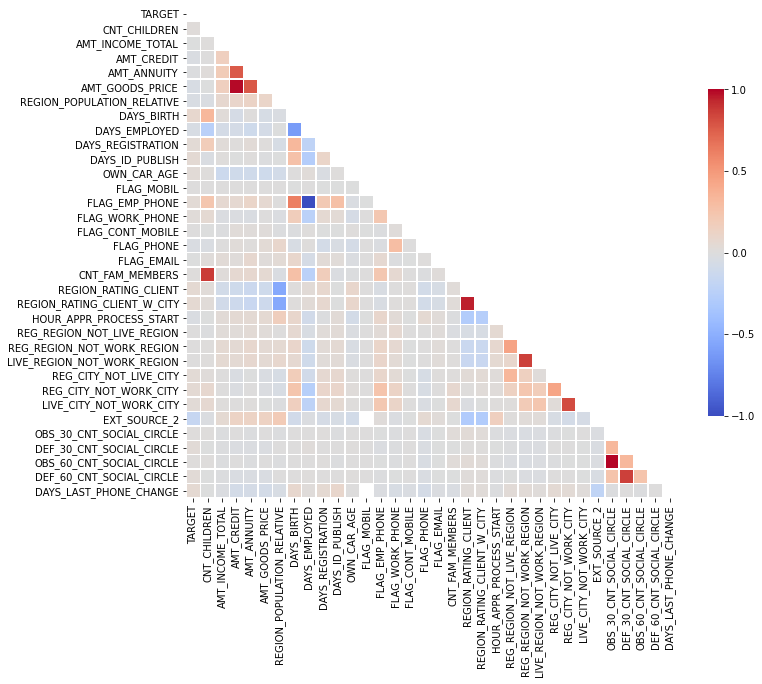

In [46]:
corr_score_new = new_data.corr()

mask = np.zeros_like(corr_score_new.iloc[:34,:34], dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_score_new.iloc[:34,:34],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_score_new.iloc[:34,:34].columns, rotation = 0)
ax.set_xticklabels(corr_score_new.iloc[:34,:34].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [47]:
# Define function to print out the top 5 positive correlated features and 5 negative correlated features
def corr_top5(x):
  pos_corr = x.sort_values(ascending = False)[0:5]
  neg_corr = x.sort_values()[0:5]
  print("Positive Correlation:")
  print(pos_corr)
  print("\nNegative Correlation:")
  print(neg_corr)

In [48]:
corr_top5(corr_score_new['AMT_CREDIT'])

Positive Correlation:
AMT_CREDIT          1.000000
AMT_GOODS_PRICE     0.986968
AMT_ANNUITY         0.770138
AMT_INCOME_TOTAL    0.156870
EXT_SOURCE_2        0.131228
Name: AMT_CREDIT, dtype: float64

Negative Correlation:
REGION_RATING_CLIENT_W_CITY   -0.110915
REGION_RATING_CLIENT          -0.101776
OWN_CAR_AGE                   -0.094191
DAYS_LAST_PHONE_CHANGE        -0.073701
DAYS_EMPLOYED                 -0.066838
Name: AMT_CREDIT, dtype: float64


In [49]:
corr_top5(corr_score_new['CNT_FAM_MEMBERS'])

Positive Correlation:
CNT_FAM_MEMBERS      1.000000
CNT_CHILDREN         0.879161
DAYS_BIRTH           0.278894
FLAG_EMP_PHONE       0.233950
DAYS_REGISTRATION    0.173416
Name: CNT_FAM_MEMBERS, dtype: float64

Negative Correlation:
DAYS_EMPLOYED                -0.233549
FLAG_DOCUMENT_6              -0.156682
DAYS_LAST_PHONE_CHANGE       -0.027108
REGION_POPULATION_RELATIVE   -0.024209
DAYS_ID_PUBLISH              -0.020912
Name: CNT_FAM_MEMBERS, dtype: float64


In [50]:
corr_top5(corr_score_new['FLAG_EMP_PHONE'])

Positive Correlation:
FLAG_EMP_PHONE            1.000000
DAYS_BIRTH                0.619888
DAYS_ID_PUBLISH           0.273611
REG_CITY_NOT_WORK_CITY    0.256427
FLAG_DOCUMENT_3           0.248534
Name: FLAG_EMP_PHONE, dtype: float64

Negative Correlation:
DAYS_EMPLOYED                 -0.999755
FLAG_DOCUMENT_6               -0.597732
REGION_RATING_CLIENT_W_CITY   -0.034712
REGION_RATING_CLIENT          -0.032871
OWN_CAR_AGE                   -0.028282
Name: FLAG_EMP_PHONE, dtype: float64


In [51]:
corr_top5(corr_score_new['REGION_RATING_CLIENT_W_CITY'])

Positive Correlation:
REGION_RATING_CLIENT_W_CITY    1.000000
REGION_RATING_CLIENT           0.950842
OWN_CAR_AGE                    0.088820
DAYS_REGISTRATION              0.074038
FLAG_DOCUMENT_3                0.067083
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

Negative Correlation:
REGION_POPULATION_RELATIVE    -0.531535
EXT_SOURCE_2                  -0.288299
HOUR_APPR_PROCESS_START       -0.264815
AMT_ANNUITY                   -0.141682
LIVE_REGION_NOT_WORK_REGION   -0.140771
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


In [52]:
corr_top5(corr_score_new['LIVE_REGION_NOT_WORK_REGION'])

Positive Correlation:
LIVE_REGION_NOT_WORK_REGION    1.000000
REG_REGION_NOT_WORK_REGION     0.860627
LIVE_CITY_NOT_WORK_CITY        0.236635
REG_CITY_NOT_WORK_CITY         0.185863
FLAG_EMP_PHONE                 0.096447
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

Negative Correlation:
REGION_RATING_CLIENT          -0.146561
REGION_RATING_CLIENT_W_CITY   -0.140771
DAYS_EMPLOYED                 -0.095539
FLAG_DOCUMENT_6               -0.059148
OWN_CAR_AGE                   -0.028980
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64


In [53]:
corr_top5(corr_score_new['LIVE_CITY_NOT_WORK_CITY'])

Positive Correlation:
LIVE_CITY_NOT_WORK_CITY        1.000000
REG_CITY_NOT_WORK_CITY         0.825575
LIVE_REGION_NOT_WORK_REGION    0.236635
FLAG_EMP_PHONE                 0.219219
REG_REGION_NOT_WORK_REGION     0.197097
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64

Negative Correlation:
DAYS_EMPLOYED          -0.218101
FLAG_DOCUMENT_6        -0.133229
EXT_SOURCE_2           -0.058900
FLAG_PHONE             -0.023580
REGION_RATING_CLIENT   -0.019154
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64


In [54]:
corr_top5(corr_score_new['OBS_30_CNT_SOCIAL_CIRCLE'])

Positive Correlation:
OBS_30_CNT_SOCIAL_CIRCLE    1.000000
OBS_60_CNT_SOCIAL_CIRCLE    0.998490
DEF_30_CNT_SOCIAL_CIRCLE    0.329338
DEF_60_CNT_SOCIAL_CIRCLE    0.253499
REGION_RATING_CLIENT        0.034330
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Negative Correlation:
FLAG_PHONE                    -0.033484
REG_REGION_NOT_WORK_REGION    -0.028855
FLAG_DOCUMENT_8               -0.023339
LIVE_REGION_NOT_WORK_REGION   -0.023147
REG_REGION_NOT_LIVE_REGION    -0.020641
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64


In [55]:
corr_top5(corr_score_new['DEF_30_CNT_SOCIAL_CIRCLE'])

Positive Correlation:
DEF_30_CNT_SOCIAL_CIRCLE    1.000000
DEF_60_CNT_SOCIAL_CIRCLE    0.860517
OBS_60_CNT_SOCIAL_CIRCLE    0.331571
OBS_30_CNT_SOCIAL_CIRCLE    0.329338
TARGET                      0.032248
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

Negative Correlation:
EXT_SOURCE_2      -0.030406
FLAG_PHONE        -0.029758
AMT_ANNUITY       -0.022833
AMT_GOODS_PRICE   -0.022244
AMT_CREDIT        -0.021229
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64


##### Define the magnitude of correlation:
The absolute value of correlation:
Weak: 0.0 ~ 0.3, Medium: 0.3 ~ 0.7, Strong: 0.7 ~ 1.0

We will drop columns that have strong correlations.

In [56]:
# Drop highly correlated columns
cols_lst3 = ['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT', 'REG_REGION_NOT_WORK_REGION',
            'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'REG_CITY_NOT_WORK_CITY']

new_data = new_data.drop(cols_lst3, axis = 1)

In [57]:
new_data.shape

(307511, 57)

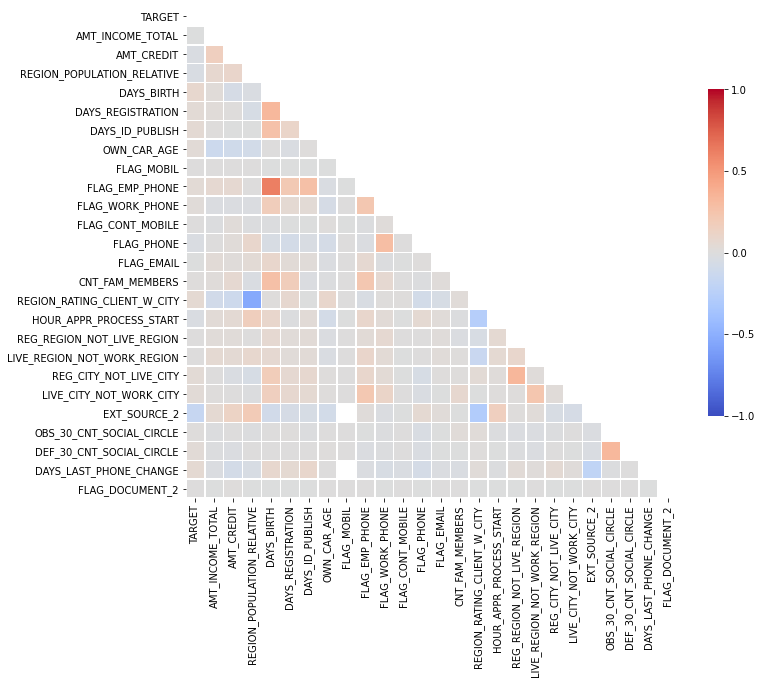

In [58]:
corr_score_new1 = new_data.corr()

mask = np.zeros_like(corr_score_new1.iloc[:26,:26], dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_score_new1.iloc[:26,:26],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_score_new1.iloc[:26,:26].columns, rotation = 0)
ax.set_xticklabels(corr_score_new1.iloc[:26,:26].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Drop Rows

#### Drop rows, which target = 0 and have missing values in columns

In [59]:
# Create subset of new_data with TARGET = 0
major = new_data[new_data['TARGET'] == 0]

In [60]:
# Check the missing values for each columns
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                 185680
OCCUPATION_TYPE              90113
NAME_TYPE_SUITE               1222
OBS_30_CNT_SOCIAL_CIRCLE       985
DEF_30_CNT_SOCIAL_CIRCLE       985
EXT_SOURCE_2                   608
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
DAYS_ID_PUBLISH                  0
FLAG_EMAIL                       0
FLAG_PHONE                       0
FLAG_CONT_MOBILE                 0
FLAG_WORK_PHONE                  0
FLAG_EMP_PHONE                   0
FLAG_MOBIL                       0
dtype: int64

In [61]:
# Drop rows with missing values in NAME_TYPE_SUITE 
drop_idx0 = major[major['NAME_TYPE_SUITE'].isna()].index
new_data = new_data.drop(drop_idx0, axis = 0)

In [62]:
# Drop rows with missing values in OBS_30_CNT_SOCIAL_CIRCLE
drop_idx1 = major[major['OBS_30_CNT_SOCIAL_CIRCLE'].isna()].index
new_data = new_data.drop(drop_idx1, axis = 0)

In [63]:
# Re-run those code to update the major
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE               184218
OCCUPATION_TYPE            89433
EXT_SOURCE_2                 603
DAYS_LAST_PHONE_CHANGE         1
FLAG_DOCUMENT_21               0
DAYS_REGISTRATION              0
CNT_FAM_MEMBERS                0
FLAG_EMAIL                     0
FLAG_PHONE                     0
FLAG_CONT_MOBILE               0
FLAG_WORK_PHONE                0
FLAG_EMP_PHONE                 0
FLAG_MOBIL                     0
DAYS_ID_PUBLISH                0
DAYS_BIRTH                     0
dtype: int64

In [64]:
# Drop rows with missing values in EXT_SOURCE_2
drop_idx2 = major[major['EXT_SOURCE_2'].isna()].index
new_data = new_data.drop(drop_idx2, axis = 0)

In [65]:
# Re-run those code to update the major
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                    183789
OCCUPATION_TYPE                 89199
FLAG_DOCUMENT_21                    0
HOUR_APPR_PROCESS_START             0
REGION_RATING_CLIENT_W_CITY         0
CNT_FAM_MEMBERS                     0
FLAG_EMAIL                          0
FLAG_PHONE                          0
FLAG_CONT_MOBILE                    0
FLAG_WORK_PHONE                     0
FLAG_EMP_PHONE                      0
FLAG_MOBIL                          0
DAYS_ID_PUBLISH                     0
DAYS_REGISTRATION                   0
DAYS_BIRTH                          0
dtype: int64

In [66]:
# Drop rows with missing values in EXT_SOURCE_2
drop_idx2 = major[major['EXT_SOURCE_2'].isna()].index
new_data = new_data.drop(drop_idx2, axis = 0)

In [67]:
# OWN_CAR_AGE and OCCUPATION_TYPE are columns we need to impute
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                    183789
OCCUPATION_TYPE                 89199
FLAG_DOCUMENT_21                    0
HOUR_APPR_PROCESS_START             0
REGION_RATING_CLIENT_W_CITY         0
CNT_FAM_MEMBERS                     0
FLAG_EMAIL                          0
FLAG_PHONE                          0
FLAG_CONT_MOBILE                    0
FLAG_WORK_PHONE                     0
FLAG_EMP_PHONE                      0
FLAG_MOBIL                          0
DAYS_ID_PUBLISH                     0
DAYS_REGISTRATION                   0
DAYS_BIRTH                          0
dtype: int64

##### Except the columns (OWN_CAR_AGE, OCCUPATION_TYPE) we want to keep, there is no missing value in other columns, where the related targets are 0s

### Train Test Split

In [68]:
# Divide train and validation following same distribution 
train0, validation0 = train_test_split(new_data, test_size = 0.2, random_state = 23, stratify = new_data['TARGET'])

In [69]:
# Define a function to get the class proportions
def get_class_proportions(df):
  minor_prop = df[df['TARGET'] == 1].shape[0]/len(df)
  major_prop = df[df['TARGET'] == 0].shape[0]/len(df)
  return {'Target(1)': minor_prop, 'Target(0)': major_prop}

In [70]:
# Print out the class proportion for train and validation
train_class_proportions = get_class_proportions(train0)
validation_class_proportions = get_class_proportions(validation0)

print("Train data class proportions:", train_class_proportions)
print("Validation data class proportions:", validation_class_proportions)

Train data class proportions: {'Target(1)': 0.0814735805710535, 'Target(0)': 0.9185264194289465}
Validation data class proportions: {'Target(1)': 0.08147224364549319, 'Target(0)': 0.9185277563545068}


In [71]:
# Make a copy
train = train0.copy()
validation = validation0.copy()

print(train.shape)
print(validation.shape)

(243760, 57)
(60941, 57)


In [72]:
# Save train and validation csv
train.to_csv('train.csv', index = True)
!cp train.csv "drive/My Drive/"

In [73]:
validation.to_csv('validation.csv', index = True)
!cp validation.csv "drive/My Drive/"

In [74]:
# Reload train and validation
train = pd.read_csv('train.csv', index_col = 0)
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
425016,0,Cash loans,M,N,Y,112500.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.009630,-13672,-7552.0,-4481,NaN,1,1,1,1,1,0,Laborers,2.0,2,THURSDAY,17,0,1,0,1,Business Entity Type 3,0.185145,0.0,0.0,-620.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116242,0,Cash loans,M,N,Y,270000.0,203760.0,Unaccompanied,State servant,Higher education,Civil marriage,House / apartment,0.046220,-11326,-5468.0,-3832,NaN,1,1,0,1,1,0,High skill tech staff,2.0,1,FRIDAY,13,0,0,0,0,Military,0.283480,0.0,0.0,-14.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112522,0,Cash loans,F,Y,N,157500.0,781920.0,Other_A,State servant,Higher education,Married,House / apartment,0.022800,-9490,-4155.0,-1922,0.0,1,1,0,1,0,0,Core staff,2.0,2,SATURDAY,10,0,0,0,0,University,0.590467,2.0,1.0,-610.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
401317,0,Cash loans,F,N,Y,49500.0,540000.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.031329,-22595,-10137.0,-4618,NaN,1,0,0,1,1,0,NaN,2.0,2,SATURDAY,9,0,0,0,0,XNA,0.659662,0.0,0.0,-2402.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
440895,0,Cash loans,M,N,N,225000.0,1762110.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.046220,-12034,-5469.0,-2788,NaN,1,1,0,1,1,0,Laborers,2.0,1,WEDNESDAY,21,0,1,0,1,Telecom,0.696256,0.0,0.0,-1230.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
validation = pd.read_csv('validation.csv', index_col = 0)
validation.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420412,0,Cash loans,F,N,N,121500.0,592560.0,Unaccompanied,Working,Secondary / secondary special,Widow,Municipal apartment,0.007114,-16706,-7222.0,-244,NaN,1,1,0,1,1,0,Cleaning staff,1.0,2,WEDNESDAY,17,0,0,0,0,Other,0.780284,0.0,0.0,-852.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400448,1,Revolving loans,M,Y,Y,315000.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008866,-12493,-6529.0,-4461,6.0,1,1,0,0,0,0,Laborers,4.0,2,WEDNESDAY,12,0,0,0,0,Transport: type 2,0.325944,2.0,0.0,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
389953,0,Cash loans,F,Y,Y,180000.0,808650.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.005313,-19513,-11742.0,-2388,26.0,1,0,0,1,1,0,NaN,2.0,2,FRIDAY,11,0,0,0,0,XNA,0.639844,0.0,0.0,-547.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
381118,0,Cash loans,F,Y,N,90000.0,1005120.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006852,-11200,-40.0,-1731,13.0,1,1,0,1,0,0,Laborers,2.0,3,SUNDAY,7,0,0,0,1,Business Entity Type 3,0.224186,0.0,0.0,-427.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
314845,0,Cash loans,F,N,Y,153000.0,269550.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.010032,-14855,-957.0,-4659,NaN,1,1,1,1,1,0,Core staff,4.0,2,TUESDAY,11,0,0,0,0,School,0.561105,1.0,0.0,-2578.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# Check the shape of train and validation set
print("Train shape:", train.shape)
print("Validation shape:", validation.shape)

Train shape: (243760, 57)
Validation shape: (60941, 57)


### Impute Missing Values

#### Input columns: OWN_CAR_AGE, OCCUPATION_TYPE

##### Columns: ONW_CAR_AGE

In [77]:
# Calculate the mean value of car age when 'FLAG_OWN_CAR' = Y for train and validation
mean_train = train['OWN_CAR_AGE'].mean()
mean_validation = validation['OWN_CAR_AGE'].mean()
print("Car age for train:", mean_train)
print("Car age for validation:", mean_validation)

Car age for train: 12.099066321305946
Car age for validation: 11.959967082970278


In [78]:
# Fill values of OWN_CAR_AGE based on the values in FLAG_OWN_CAR for train and validation
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(data['FLAG_OWN_CAR'])
train['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

validation['OWN_CAR_AGE'] = validation['OWN_CAR_AGE'].fillna(data['FLAG_OWN_CAR'])
validation['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

In [79]:
# Check the missing value rate of column OWN_CAR_AGE
print("Missing values rate for train:", train['OWN_CAR_AGE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OWN_CAR_AGE'].isna().sum()/len(validation))

Missing values rate for train: 0.0
Missing values rate for validation: 0.0


##### Column OCCUPATION_TYPE

In [80]:
# If NAME_INCOME_TYPE == Pensioner, fill na in OCCUPATION_TYPE with Retired for train and validation
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'
validation.loc[validation['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'

In [81]:
# Check the missing values rate in OCCUPATION_TYPE
print("Missing values rate for train:", train['OCCUPATION_TYPE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OCCUPATION_TYPE'].isna().sum()/len(validation))

Missing values rate for train: 0.13313915326550704
Missing values rate for validation: 0.13391641095485798


In [82]:
# Most common occupation type in train and validation
print("Most common occupation type for train:", train['OCCUPATION_TYPE'].value_counts().index[0])
print("Most common occupation type for validation:", validation['OCCUPATION_TYPE'].value_counts().index[0])

Most common occupation type for train: Retired
Most common occupation type for validation: Retired


In [83]:
# Fill the na in train and validation
train['OCCUPATION_TYPE'].fillna('Retired', inplace = True)
validation['OCCUPATION_TYPE'].fillna('Retired', inplace = True)

# Checking missing values
print("Missing values for train:", train['OCCUPATION_TYPE'].isna().sum())
print("Missing values for validation:", validation['OCCUPATION_TYPE'].isna().sum())

Missing values for train: 0
Missing values for validation: 0


#### Inpute other columns

In [84]:
missing_train = pd.DataFrame(train.isnull().sum(), columns =['missing value rate'])
print(missing_train.sort_values(ascending = False, by = 'missing value rate')[0:12])

missing_validation = pd.DataFrame(validation.isnull().sum(), columns =['missing value rate'])
print(missing_validation.sort_values(ascending = False, by = 'missing value rate')[0:10])

                          missing value rate
NAME_TYPE_SUITE                           57
EXT_SOURCE_2                              42
OBS_30_CNT_SOCIAL_CIRCLE                  33
DEF_30_CNT_SOCIAL_CIRCLE                  33
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_PHONE_CHANGE                     0
FLAG_DOCUMENT_2                            0
FLAG_DOCUMENT_3                            0
FLAG_DOCUMENT_4                            0
                          missing value rate
NAME_TYPE_SUITE                           13
EXT_SOURCE_2                              10
OBS_30_CNT_SOCIAL_CIRCLE                   3
DEF_30_CNT_SOCIAL_CIRCLE                   3
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_

In [85]:
# Define functions to fill missing values in categorical variables and numerical variables
def fill_missing(x, categorical = False):
  if categorical == True:
    val_train = train[x].value_counts().index[0]
    val_validation = validation[x].value_counts().index[0]
    
    print("For column {}:".format(x))
    print("Most common values for train:", val_train)
    print("Most common values for test:", val_validation)
    
    # Fill the na in train and validation
    train[x].fillna(val_train, inplace = True)
    validation[x].fillna(val_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())
  
  else:
    median_train = train[x].median()
    median_validation = validation[x].median()

    print("For column {}:".format(x))
    print("Median value for train:", median_train)
    print("Median value for validation:", median_validation)

    # Fill missing value for train and validation
    train[x].fillna(median_train, inplace = True)
    validation[x].fillna(median_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())

##### Column: NAME_TYPE_SUITE

In [86]:
# Fill column NAME_TYPE_SUITE
fill_missing('NAME_TYPE_SUITE', categorical = True)

For column NAME_TYPE_SUITE:
Most common values for train: Unaccompanied
Most common values for test: Unaccompanied
Missing values left in train: 0
Missing values left in validation: 0


##### Column: EXT_SOURCE_2 

In [87]:
# Fill column EXT_SOURCE_2
fill_missing('EXT_SOURCE_2')

For column EXT_SOURCE_2:
Median value for train: 0.5657357988357584
Median value for validation: 0.5660312575232652
Missing values left in train: 0
Missing values left in validation: 0


##### Column: OBS_30_CNT_SOCIAL_CIRCLE

In [88]:
# Fill column OBS_30_CNT_SOCIAL_CIRCLE
fill_missing('OBS_30_CNT_SOCIAL_CIRCLE')

For column OBS_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


##### Column: DEF_30_CNT_SOCIAL_CIRCLE

In [89]:
# Fill column DEF_30_CNT_SOCIAL_CIRCLE
fill_missing('DEF_30_CNT_SOCIAL_CIRCLE')

For column DEF_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


In [90]:
print("Check missing values in train:", train.isna().values.any())
print("Check missing values in validation:", validation.isna().values.any())

Check missing values in train: False
Check missing values in validation: False


### Deal with Categorical Variable

#### Reduce levels in some categorical variables

In [91]:
# Columns that are categorical variables
cat_train_idx = train.dtypes[train.dtypes == 'object'].index
cat_train_idx

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

##### Categorical variable: OCCUPATION_TYPE

In [92]:
train['OCCUPATION_TYPE'].value_counts()

Retired                  76312
Laborers                 43794
Sales staff              25489
Core staff               21914
Managers                 16895
Drivers                  14865
High skill tech staff     9016
Accountants               7705
Medicine staff            6757
Security staff            5343
Cooking staff             4692
Cleaning staff            3693
Private service staff     2076
Low-skill Laborers        1676
Waiters/barmen staff      1068
Secretaries               1007
Realty agents              584
HR staff                   447
IT staff                   427
Name: OCCUPATION_TYPE, dtype: int64

In [93]:
# Deal with the levels in data
train.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [94]:
train['OCCUPATION_TYPE'].value_counts()

White collar    90241
Retired         76312
Laborers        43794
Blue collar     33413
Name: OCCUPATION_TYPE, dtype: int64

In [95]:
# Deal with the values in validation
validation.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [96]:
validation['OCCUPATION_TYPE'].value_counts()

White collar    22517
Retired         19167
Laborers        10970
Blue collar      8287
Name: OCCUPATION_TYPE, dtype: int64

##### Categorical Variable: NAME_INCOME_TYPE

In [97]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Unemployed                  15
Student                     14
Businessman                  8
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Group unemployed, student, businessman and maternity leave in a small group - other.
<br> The reason to group these four levels is that only a few records are in those levels. It always happens that only train set contains some levels. For instance, Maternity leave only has 5 records. When doing train test split, only train set contains this 5 records. After doing one hot encoding, this results in the train and validation set in different shape.  

In [98]:
# Deal with train
train.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                   'Student': 'Other',
                                   'Businessman': 'Other',
                                   'Maternity leave': 'Other'}}, inplace = True)

In [99]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Other                       42
Name: NAME_INCOME_TYPE, dtype: int64

In [100]:
# Deal with validation
validation.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                        'Student': 'Other',
                                        'Businessman': 'Other',
                                        'Maternity leave': 'Other'}}, inplace = True)

In [101]:
validation['NAME_INCOME_TYPE'].value_counts()

Working                 31387
Commercial associate    14243
Pensioner               11006
State servant            4296
Other                       9
Name: NAME_INCOME_TYPE, dtype: int64

##### Categorical variable: ORGANIZATION_TYPE

In [102]:
train['ORGANIZATION_TYPE'].value_counts()[0:20]

Business Entity Type 3    53886
XNA                       43865
Self-employed             30488
Other                     13161
Medicine                   8825
Business Entity Type 2     8364
Government                 8333
School                     7037
Trade: type 7              6169
Kindergarten               5529
Construction               5286
Business Entity Type 1     4731
Transport: type 4          4316
Trade: type 3              2757
Industry: type 9           2674
Industry: type 3           2638
Security                   2596
Housing                    2318
Industry: type 11          2155
Military                   2090
Name: ORGANIZATION_TYPE, dtype: int64

The categorical information in this column is messy, we will consider drop this column at this moment

In [103]:
# Drop columns ORGANIZATION_TYPE
train = train.drop('ORGANIZATION_TYPE', axis = 1)
validation = validation.drop('ORGANIZATION_TYPE', axis = 1)

#### One-Hot Encoding

In [104]:
# Conduct one-hot encoding, drop_first should be True to get the dummy variables
train = pd.get_dummies(train, drop_first = True)
validation = pd.get_dummies(validation, drop_first = True)

In [105]:
print("Train shape:", train.shape)
print("validation shape:", validation.shape)

Train shape: (243760, 82)
validation shape: (60941, 81)


In [106]:
# We have one column missing for validation. Match columns in train and validation
col_train = pd.Series(train.columns.value_counts(), name = 'train')
col_validation = pd.Series(validation.columns.value_counts(), name = 'validation')

In [107]:
# Find the column that is included in train but not validation
col_train_validation = pd.concat([col_train, col_validation], axis = 1)
col_train_validation[col_train_validation['validation'].isna()]

,train,validation
CODE_GENDER_XNA,1,NaN


After further exploration, we find that 'CODE_GENDER_XNA' only has four records, we can drop this column as well.

In [108]:
train['CODE_GENDER_XNA'].sort_values(ascending = False)[0:5]

SK_ID_CURR
319880    1
144669    1
196708    1
141289    1
166591    0
Name: CODE_GENDER_XNA, dtype: uint8

In [109]:
# Drop the two rows
train.drop([319880, 144669, 196708, 141289], inplace = True)

In [110]:
# Then drop the column CODE_GENDER_XNA' in train
train.drop('CODE_GENDER_XNA', axis = 1, inplace = True)

In [111]:
print(train.shape)
print(validation.shape)

(243756, 81)
(60941, 81)


Now that train and validation are in the same shape, we can go ahead do the normalization

### Normalize the data

In [112]:
# Prepare X_train, X_validation, y_train, y_validation
X_train_rw = train.drop('TARGET', axis = 1)
X_validation_rw = validation.drop('TARGET', axis = 1)

y_train = train['TARGET']
y_validation = validation['TARGET']

print("X_train shape:", X_train_rw.shape, "y_train shape:", y_train.shape)
print("X_validation shape:", X_validation_rw.shape, "y_validation shape:", y_validation.shape)

X_train shape: (243756, 80) y_train shape: (243756,)
X_validation shape: (60941, 80) y_validation shape: (60941,)


In [113]:
# Standardize the train and validation data
scaler = StandardScaler()
scaler.fit(X_train_rw, y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [114]:
X_train = scaler.transform(X_train_rw)
X_validation = scaler.transform(X_validation_rw)

### RandomForest Modelling

##### Basic random forest

In [ ]:
# Instantiate a random forests classifer
rf = RandomForestClassifier(random_state=20)
# Fitting the data to the data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [ ]:
# predicted probabilities using .predict_proba()
y_pred_prob = rf.predict_proba(X_validation)
# predicted classes using .predict()
y_pred = rf.predict(X_validation)

#### Confusion_matrix

In [ ]:
#Confusion matrix
confusion_matrix(y_validation, y_pred)

array([[55974,     2],
       [ 4960,     5]])

In [ ]:
#Classification report
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55976
           1       0.71      0.00      0.00      4965

    accuracy                           0.92     60941
   macro avg       0.82      0.50      0.48     60941
weighted avg       0.90      0.92      0.88     60941



In [ ]:
# calculating roc_auc_score for our target class = 1
print(roc_auc_score(y_validation, y_pred_prob[:,0]))

0.3237936996736193


In [ ]:
# calculating roc_auc_score for our target class = 0
print(roc_auc_score(y_validation, y_pred_prob[:,1]))

0.6762063003263807


In [ ]:
y_train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_validation)

y_train_proba = rf.predict_proba(X_train)
y_test_proba = rf.predict_proba(X_validation)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred))
print("Precision Train:", skm.precision_score(y_train, y_train_pred))
print("Recall Train:", skm.recall_score(y_train, y_train_pred))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [    15  19845]]
Accuracy Train: 0.9999384630532171
Precision Train: 1.0
Recall Train: 0.9992447129909365
AUC score 1.0

 Test Confusion Matrix: 
 [[55974     2]
 [ 4960     5]]
Accuracy Test: 0.9185769842962865
Precision Test: 0.7142857142857143
Recall Test: 0.0010070493454179255
AUC score 0.6762063003263807


#### RandomForest with GridSearchCV

In [ ]:
param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12]}

# create Random Forest model 
rf=RandomForestClassifier()

# Use 5 cross-fold and for scoring use "roc_auc" 
rf_Grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc')

In [ ]:
#fit our model to our train data
rf_Grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
#To identify the best performing model
rf_Grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Re-running the model with the best estimators

rf_Grid = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_Grid.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#  .predict() to get predicted classes.
y_pred_grid = rf_Grid.predict(X_validation)
y_pred_grid

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# .predict_proba() to get predicted probabilities.
y_predprob_grid = rf_Grid.predict_proba(X_validation)
y_predprob_grid

array([[0.9295983 , 0.0704017 ],
       [0.89855257, 0.10144743],
       [0.95239512, 0.04760488],
       ...,
       [0.92848624, 0.07151376],
       [0.92516974, 0.07483026],
       [0.92696601, 0.07303399]])

In [ ]:
print(classification_report(y_validation, y_pred_grid))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55976
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     60941
   macro avg       0.46      0.50      0.48     60941
weighted avg       0.84      0.92      0.88     60941



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# confusion_matrix
confusion_matrix(y_validation, y_pred_grid)

array([[55976,     0],
       [ 4965,     0]])

In [ ]:
# roc_auc_score for model with GridSearch
print(roc_auc_score(y_validation, y_pred_grid))

0.5


In [ ]:
#predicting the train error score
y_pred_train_grid = rf_Grid.predict(X_train)

In [ ]:
#Classification report
print(classification_report(y_train, y_pred_train_grid))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96    223896
           1       0.00      0.00      0.00     19860

    accuracy                           0.92    243756
   macro avg       0.46      0.50      0.48    243756
weighted avg       0.84      0.92      0.88    243756



In [ ]:
# confusion_matrix for our predicted and actual train target class
confusion_matrix(y_train, y_pred_train_grid)

array([[223896,      0],
       [ 19860,      0]])

In [ ]:
# roc_auc_score for predicted and actual train target class
print(roc_auc_score(y_train, y_pred_train_grid))

0.5


In [ ]:
y_train_gridpred_df = rf.predict(X_train)
y_test_gridpred_df = rf.predict(X_validation)

y_train_gridproba_df = rf.predict_proba(X_train)
y_test_gridproba_df = rf.predict_proba(X_validation)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_gridpred_df))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_gridpred_df))
print("Precision Train:", skm.precision_score(y_train, y_train_gridpred_df))
print("Recall Train:", skm.recall_score(y_train, y_train_gridpred_df))
print("AUC score", skm.roc_auc_score(y_train, y_train_gridproba_df[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_gridpred_df))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_gridpred_df))
print("Precision Test:", skm.precision_score(y_validation, y_test_gridpred_df))
print("Recall Test:", skm.recall_score(y_validation, y_test_gridpred_df))
print("AUC score", skm.roc_auc_score(y_validation, y_test_gridproba_df[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [    15  19845]]
Accuracy Train: 0.9999384630532171
Precision Train: 1.0
Recall Train: 0.9992447129909365
AUC score 1.0

 Test Confusion Matrix: 
 [[55974     2]
 [ 4960     5]]
Accuracy Test: 0.9185769842962865
Precision Test: 0.7142857142857143
Recall Test: 0.0010070493454179255
AUC score 0.6762063003263807


### Undersampling the majority class

In [115]:
# extreme undersampling major class 
under = RandomUnderSampler(sampling_strategy=1)
X_train_usm, y_train_usm = under.fit_sample(X_train.astype('float'), y_train)
print("Before usm: ", Counter(y_train))
print("After usm: ", Counter(y_train_usm))

Before usm:  Counter({0: 223896, 1: 19860})
After usm:  Counter({0: 19860, 1: 19860})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [116]:
param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12]}

# create Random Forest model 
rf=RandomForestClassifier(random_state=20)

# Use 5 cross-fold and for scoring use "roc_auc" 
rf_Grid_2 = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc')

In [ ]:
#fit our model to our train data
rf_Grid_2.fit(X_train_usm,y_train_usm)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=20,
                                  

In [ ]:
#To identify the best performing parameters
rf_Grid_2.best_params_

{'max_depth': 12, 'max_features': 8, 'n_estimators': 200}

In [ ]:
#To identify the best performing model
rf_Grid_2.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [117]:
#Re-running the model with the best estimators

rf_Grid_2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

rf_Grid_2.fit(X_train_usm,y_train_usm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [118]:
#  .predict() to get predicted classes.
y_pred_grid_2 = rf_Grid_2.predict(X_validation)
y_pred_grid_2

array([0, 1, 0, ..., 0, 0, 1])

In [119]:
# .predict_proba() to get predicted probabilities.
y_predprob_grid_2 = rf_Grid_2.predict_proba(X_validation)
y_predprob_grid_2

array([[0.59182448, 0.40817552],
       [0.47274374, 0.52725626],
       [0.65525788, 0.34474212],
       ...,
       [0.5382035 , 0.4617965 ],
       [0.54216172, 0.45783828],
       [0.48426918, 0.51573082]])

In [120]:
print(classification_report(y_validation, y_pred_grid_2))

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     55976
           1       0.14      0.64      0.23      4965

    accuracy                           0.65     60941
   macro avg       0.55      0.65      0.50     60941
weighted avg       0.89      0.65      0.73     60941



In [121]:
# confusion_matrix
confusion_matrix(y_validation, y_pred_grid_2)

array([[36497, 19479],
       [ 1778,  3187]])

In [122]:
# roc_auc_score for model with GridSearch
print(roc_auc_score(y_validation, y_pred_grid_2))

0.6469524145796336


In [123]:
#predicting the train error score
y_pred_train_grid2 = rf_Grid_2.predict(X_train_usm)

In [124]:
#Classification report
print(classification_report(y_train_usm, y_pred_train_grid2))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77     19860
           1       0.76      0.78      0.77     19860

    accuracy                           0.77     39720
   macro avg       0.77      0.77      0.77     39720
weighted avg       0.77      0.77      0.77     39720



In [ ]:
# confusion_matrix for our predicted and actual train target class
confusion_matrix(y_train_usm, y_pred_train_grid2)

array([[15142,  4718],
       [ 4499, 15361]])

In [ ]:
# roc_auc_score for predicted and actual train target class
print(roc_auc_score(y_train_usm, y_pred_train_grid2))

0.7679506545820746


In [125]:
y_train_gridpred_usm = rf_Grid_2.predict(X_train_usm)
y_test_gridpred_usm = rf_Grid_2.predict(X_validation)

y_train_gridproba_usm = rf_Grid_2.predict_proba(X_train_usm)
y_test_gridproba_usm = rf_Grid_2.predict_proba(X_validation)

In [126]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_gridpred_usm))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_gridpred_usm))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_gridpred_usm))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_gridpred_usm))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_gridproba_usm[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_gridpred_usm))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_gridpred_usm))
print("Precision Test:", skm.precision_score(y_validation, y_test_gridpred_usm))
print("Recall Test:", skm.recall_score(y_validation, y_test_gridpred_usm))
print("AUC score", skm.roc_auc_score(y_validation, y_test_gridproba_usm[:,1]))

Train Confusion Matrix: 
 [[15105  4755]
 [ 4463 15397]]
Accuracy Train: 0.767925478348439
Precision Train: 0.764043271139341
Recall Train: 0.7752769385699899
AUC score 0.8554365401719386

 Test Confusion Matrix: 
 [[36497 19479]
 [ 1778  3187]]
Accuracy Test: 0.6511872138625884
Precision Test: 0.14060707667872585
Recall Test: 0.6418932527693857
AUC score 0.7019666103484719


### Cost sensitive learning

#### Cost Sensitive GridSearchCV RandomForest

In [ ]:
# Conduct Grid Search for weights
balance = [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}]
params = dict(class_weight = balance)

param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12],
'class_weight': [{0: 1, 1: 10},{0: 1, 1: 100}]}

grid_rf = RandomForestClassifier(random_state = 23)
grid1 = GridSearchCV(grid_rf, param_grid, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result1 = grid1.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result1.best_score_)
print("Best parameter:", grid_result1.best_params_)

Best score: 0.6950548140198838
Best parameter: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'max_features': 8, 'n_estimators': 200}


In [ ]:
#fitting the randomforest
grid_rf_impl = RandomForestClassifier(random_state=23,class_weight= {0: 1, 1: 10}, max_depth= 10, max_features= 8, n_estimators= 200)
grid_rf_impl_result = grid_rf_impl.fit(X_train,y_train)

In [ ]:
y_train_pred_gridrf = grid_rf_impl_result.predict(X_train)
y_test_pred_gridrf = grid_rf_impl_result.predict(X_validation)

y_train_proba_gridrf = grid_rf_impl_result.predict_proba(X_train)
y_test_proba_gridrf = grid_rf_impl_result.predict_proba(X_validation)

In [ ]:
print("Results for gridsearchCV")
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_gridrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_gridrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_gridrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_gridrf))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_gridrf[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_gridrf))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_gridrf))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_gridrf))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_gridrf))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_gridrf[:,1]))

Results for gridsearchCV
Train Confusion Matrix: 
 [[175486  48410]
 [  8537  11323]]
Accuracy Train: 0.7663770327704754
Precision Train: 0.18956020959938394
Recall Train: 0.5701409869083585
AUC score 0.7567963704627501

 Test Confusion Matrix: 
 [[43678 12298]
 [ 2485  2480]]
Accuracy Test: 0.757421112223298
Precision Test: 0.1678170253078901
Recall Test: 0.499496475327291
AUC score 0.6986872053207669


#### Cost Sensitive Randomized Search CV random forest

In [ ]:
#randomized search cv

from sklearn.model_selection import RepeatedStratifiedKFold

# Conduct Grid Search for weights
balance = [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}]
params = dict(class_weight = balance)

param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12],
'class_weight': [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}, {0:1, 1:200}]
}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_rf_random = RandomForestClassifier(random_state = 23)
grid1_random = RandomizedSearchCV(grid_rf_random, param_grid, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result1_random = grid1_random.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result1_random.best_score_)
print("Best parameter:", grid_result1_random.best_params_)

Best score: 0.6882527105888796
Best parameter: {'n_estimators': 200, 'max_features': 8, 'max_depth': 6, 'class_weight': {0: 1, 1: 10}}


In [ ]:
#fitting the randomforest
grid_rf_rnd_impl = RandomForestClassifier(random_state=23,class_weight= {0: 1, 1: 10}, max_depth= 6, max_features= 8, n_estimators= 200)
grid_rf_rnd_impl = grid_rf_impl.fit(X_train,y_train)

In [ ]:
y_train_pred_rndrf = grid_rf_rnd_impl.predict(X_train)
y_test_pred_rndrf = grid_rf_rnd_impl.predict(X_validation)

y_train_proba_rndrf = grid_rf_rnd_impl.predict_proba(X_train)
y_test_proba_rndrf = grid_rf_rnd_impl.predict_proba(X_validation)

In [ ]:
print("Results for RandomizedSearchCV")
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_rndrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_rndrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_rndrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_rndrf))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_rndrf[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_rndrf))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_rndrf))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_rndrf))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_rndrf))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_rndrf[:,1]))

Results for RandomizedSearchCV
Train Confusion Matrix: 
 [[175486  48410]
 [  8537  11323]]
Accuracy Train: 0.7663770327704754
Precision Train: 0.18956020959938394
Recall Train: 0.5701409869083585
AUC score 0.7567963704627501

 Test Confusion Matrix: 
 [[43678 12298]
 [ 2485  2480]]
Accuracy Test: 0.757421112223298
Precision Test: 0.1678170253078901
Recall Test: 0.499496475327291
AUC score 0.6986872053207669


#### Weighted Random Forest

In [ ]:
# Calculate the weights for TARGET 0 and TARGET 1
num_0 = train[train["TARGET"] == 0].shape[0]
num_1 = train[train["TARGET"] == 1].shape[0]

print(num_0/num_1)

# The inverse ratio of data distribution for TARGET 1
weight_0 = 1.0
weight_1 = 1/(num_1/num_0)

print("Weight for TARGET 0:", weight_0)
print("Weight for TARGET 1:", weight_1)
# Prepare weights for algorithms
weights = {0:weight_0, 1:weight_1}

In [ ]:
# Weighted Random Forest
wrf = RandomForestClassifier(random_state = 23, class_weight=weights,max_depth = 12, max_features = 8, n_estimators = 200)

wrf.fit(X_train, y_train)

y_train_pred_wrf = wrf.predict(X_train)
y_test_pred_wrf = wrf.predict(X_validation)
y_test_proba_wrf= wrf.predict_proba(X_validation)

In [ ]:
print("Results for weighted Random Forest")
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wrf))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_wrf))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_wrf))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_wrf))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_wrf))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_wrf[:,1]))

Results for weighted Random Forest
Train Confusion Matrix: 
 [[171027  52869]
 [  6225  13635]]
Accuracy Train: 0.7575690444542904
Precision Train: 0.20502526163839768
Recall Train: 0.6865558912386707

 Test Confusion Matrix: 
 [[42313 13663]
 [ 2341  2624]]
Accuracy Test: 0.737385339918938
Precision Test: 0.16111008780008595
Recall Test: 0.5284994964753273
AUC score 0.6984622095989634


In [ ]:
# Conduct Grid Search for weights

param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12],
'class_weight': [{0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}]
}

grid_rf2 = RandomForestClassifier(random_state = 23)
grid2 = RandomizedSearchCV(grid_rf2, param_grid, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result2 = grid2.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result2.best_score_)
print("Best parameter:", grid_result2.best_params_)

Best score: 0.6938971852963735
Best parameter: {'n_estimators': 150, 'max_features': 8, 'max_depth': 10, 'class_weight': {0: 1, 1: 12}}


In [ ]:
wrf_2 = grid_result2.best_estimator_

In [ ]:
y_train_pred_wrf_2 = wrf_2.predict(X_train)
y_test_pred_wrf_2 = wrf_2.predict(X_validation)

y_train_proba_wrf_2 = wrf_2.predict_proba(X_train)
y_test_proba_wrf_2 = wrf_2.predict_proba(X_validation)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wrf_2))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wrf_2))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wrf_2))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wrf_2))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_wrf_2[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_wrf_2))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_wrf_2))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_wrf_2))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_wrf_2))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_wrf_2[:,1]))

Train Confusion Matrix: 
 [[150840  73056]
 [  5944  13916]]
Accuracy Train: 0.6759054136103316
Precision Train: 0.16000551901761487
Recall Train: 0.7007049345417925
AUC score 0.7563718855082012

 Test Confusion Matrix: 
 [[37535 18441]
 [ 1876  3089]]
Accuracy Test: 0.6666119689535781
Precision Test: 0.1434742220157919
Recall Test: 0.6221550855991944
AUC score 0.6975990969227065


### Testing Metrics

In [ ]:
##Creating a dataframe to store the accuracy, precision, recall values
#ROC, precision, recall, acccuracy

#Accuracy Test
#Precision Test: 
#Recall Test:
#AUC score 

Comparison_dict = {'Random_Forest_Default_OD':[0.9185769842962865,0.7142857142857143,0.0010070493454179255,0.6762063003263807],
                       'Random_Forest_GridCV_OD':[0.9185769842962865,0.7142857142857143,0.0010070493454179255,0.6762063003263807],
                       'Random_Forest_GridCV_USM':[0.9185769842962865,0.7142857142857143,0.0010070493454179255,0.6762063003263807],
                       'Random_Forest_GridCV_CSL':[0.757421112223298,0.1678170253078901,0.499496475327291,0.6986872053207669],
                       'Random_Forest_RandomCV_CSL':[0.757421112223298,0.1678170253078901,0.499496475327291,0.6986872053207669],
                       'Random_Forest_Weighted':[0.737385339918938,0.16111008780008595, 0.5284994964753273,0.6984622095989634],
                      'Random_Forest_Weighted2':[0.6666119689535781,0.1434742220157919,0.6221550855991944,0.6975990969227065]}

model_comparison = pd.DataFrame(Comparison_dict)
model_comparison['Metrics'] = ['Test_Accuracy','Test_Precision','Test_Recall','Test_AUC']
#re-arranging the column order
cols = model_comparison.columns.tolist()
cols = cols[-1:] + cols[:-1]
model_comparison = model_comparison[cols]

#pivot
model_comparison = model_comparison.transpose()
model_comparison = model_comparison[1:].reset_index(drop=False)
model_comparison.columns = ['Model','Test_Accuracy','Test_Precision','Test_Recall','Test_AUC']
model_comparison

,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC
0,Random_Forest_Default_OD,0.918577,0.714286,0.00100705,0.676206
1,Random_Forest_GridCV_OD,0.918577,0.714286,0.00100705,0.676206
2,Random_Forest_GridCV_USM,0.918577,0.714286,0.00100705,0.676206
3,Random_Forest_GridCV_CSL,0.757421,0.167817,0.499496,0.698687
4,Random_Forest_RandomCV_CSL,0.757421,0.167817,0.499496,0.698687
5,Random_Forest_Weighted,0.737385,0.16111,0.528499,0.698462
6,Random_Forest_Weighted2,0.666612,0.143474,0.622155,0.697599


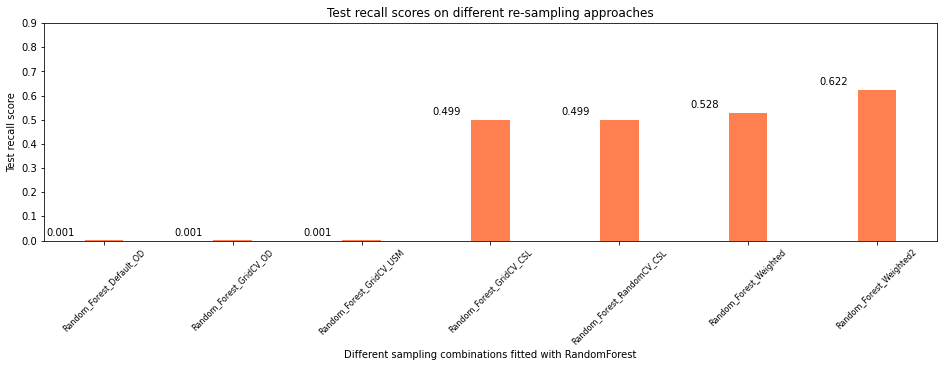

In [ ]:
fig = plt.figure(figsize = [16, 4])
plt.bar(model_comparison['Model'], model_comparison['Test_Recall'], color = 'coral', width=0.3)
plt.xlabel('Different sampling combinations fitted with RandomForest')
plt.ylabel('Test recall score')
plt.title('Test recall scores on different re-sampling approaches')
plt.xticks( rotation = 45, fontsize=8, horizontalalignment="center")
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(model_comparison['Test_Recall']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

GRID_CV_OD, GRID_CV_USM, GRID_CV_CSL, Weighted2

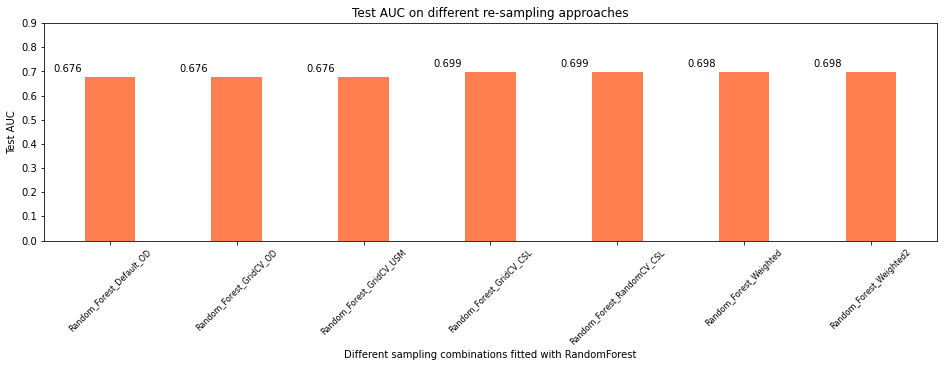

In [ ]:
fig = plt.figure(figsize = [16, 4])
plt.bar(model_comparison['Model'], model_comparison['Test_AUC'], color = 'coral', width=0.4)
plt.xlabel('Different sampling combinations fitted with RandomForest')
plt.ylabel('Test AUC')
plt.title('Test AUC on different re-sampling approaches')
plt.xticks( rotation = 45, fontsize=8, horizontalalignment="center")
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(model_comparison['Test_AUC']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

### Train Metrics

In [ ]:
##Creating a dataframe to store the accuracy, precision, recall values
#ROC, precision, recall, acccuracy

#Accuracy Train:  0.6759054136103316
#Precision Train: 0.16000551901761487
#Recall Train: 0.7007049345417925
#AUC score 0.7563718855082012

Comparison_dict = {'Random_Forest_Default_OD':[0.9999384630532171,1.0,0.9992447129909365,1.0],
                       'Random_Forest_GridCV_OD':[0.9999384630532171,1.0,0.9992447129909365,1.0],
                       'Random_Forest_GridCV_USM':[0.9996223564954683,1.0,0.9992447129909365,1.0],
                       'Random_Forest_GridCV_CSL':[0.7663770327704754,0.18956020959938394,0.5701409869083585,0.7567963704627501],
                       'Random_Forest_RandomCV_CSL':[0.757421112223298,0.1678170253078901,0.499496475327291,0.6986872053207669],
                       'Random_Forest_Weighted':[0.6759054136103316,0.16000551901761487, 0.7007049345417925,0.7563718855082012]}

model_comparison = pd.DataFrame(Comparison_dict)
model_comparison['Metrics'] = ['Train_Accuracy','Train_Precision','Train_Recall','Train_AUC']

#re-arranging the column order
cols = model_comparison.columns.tolist()
cols = cols[-1:] + cols[:-1]
model_comparison = model_comparison[cols]

#pivot
model_comparison = model_comparison.transpose()
model_comparison = model_comparison[1:].reset_index(drop=False)
model_comparison.columns = ['Model','Train_Accuracy','Train_Precision','Train_Recall','Train_AUC']
model_comparison

,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC
0,Random_Forest_Default_OD,0.999938,1,0.999245,1
1,Random_Forest_GridCV_OD,0.999938,1,0.999245,1
2,Random_Forest_GridCV_USM,0.999622,1,0.999245,1
3,Random_Forest_GridCV_CSL,0.766377,0.18956,0.570141,0.756796
4,Random_Forest_RandomCV_CSL,0.757421,0.167817,0.499496,0.698687
5,Random_Forest_Weighted,0.675905,0.160006,0.700705,0.756372


## ANN Implementation

## Impute Missing Values

### Input columns: OWN_CAR_AGE, OCCUPATION_TYPE
Columns: ONW_CAR_AGE

In [ ]:
# Calculate the mean value of car age when 'FLAG_OWN_CAR' = Y for train and validation
mean_train = train['OWN_CAR_AGE'].mean()
mean_validation = validation['OWN_CAR_AGE'].mean()
print("Car age for train:", mean_train)
print("Car age for validation:", mean_validation)

Car age for train: 12.099066321305946
Car age for validation: 11.959967082970278


In [ ]:
# Fill values of OWN_CAR_AGE based on the values in FLAG_OWN_CAR for train and test
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(train['FLAG_OWN_CAR'])
train['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

validation['OWN_CAR_AGE'] = validation['OWN_CAR_AGE'].fillna(validation['FLAG_OWN_CAR'])
validation['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

In [ ]:
# Check the missing value rate of column OWN_CAR_AGE
print("Missing values rate for train:", train['OWN_CAR_AGE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OWN_CAR_AGE'].isna().sum()/len(validation))

Missing values rate for train: 0.0
Missing values rate for validation: 0.0


##### Column OCCUPATION_TYPE

In [ ]:
# If NAME_INCOME_TYPE == Pensioner, fill na in OCCUPATION_TYPE with Retired for train and validation
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'
validation.loc[validation['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'

In [ ]:
# Check the missing values rate in OCCUPATION_TYPE
print("Missing values rate for train:", train['OCCUPATION_TYPE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OCCUPATION_TYPE'].isna().sum()/len(validation))

Missing values rate for train: 0.13313915326550704
Missing values rate for validation: 0.13391641095485798


In [ ]:
# Most common occupation type in train and validation
print("Most common occupation type for train:", train['OCCUPATION_TYPE'].value_counts().index[0])
print("Most common occupation type for validation:", validation['OCCUPATION_TYPE'].value_counts().index[0])

Most common occupation type for train: Retired
Most common occupation type for validation: Retired


In [ ]:
# Fill the na in train and validation
train['OCCUPATION_TYPE'].fillna('Retired', inplace = True)
validation['OCCUPATION_TYPE'].fillna('Retired', inplace = True)

# Checking missing values
print("Missing values for train:", train['OCCUPATION_TYPE'].isna().sum())
print("Missing values for validation:", validation['OCCUPATION_TYPE'].isna().sum())

Missing values for train: 0
Missing values for validation: 0


#### Inpute other columns

In [ ]:
missing_train = pd.DataFrame(train.isnull().sum(), columns =['missing value rate'])
print(missing_train.sort_values(ascending = False, by = 'missing value rate')[0:12])

missing_validation = pd.DataFrame(validation.isnull().sum(), columns =['missing value rate'])
print(missing_validation.sort_values(ascending = False, by = 'missing value rate')[0:10])

                          missing value rate
NAME_TYPE_SUITE                           57
EXT_SOURCE_2                              42
OBS_30_CNT_SOCIAL_CIRCLE                  33
DEF_30_CNT_SOCIAL_CIRCLE                  33
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_PHONE_CHANGE                     0
FLAG_DOCUMENT_2                            0
FLAG_DOCUMENT_3                            0
FLAG_DOCUMENT_4                            0
                          missing value rate
NAME_TYPE_SUITE                           13
EXT_SOURCE_2                              10
OBS_30_CNT_SOCIAL_CIRCLE                   3
DEF_30_CNT_SOCIAL_CIRCLE                   3
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_

In [ ]:
# Define functions to fill missing values in categorical variables and numerical variables
def fill_missing(x, categorical = False):
  if categorical == True:
    val_train = train[x].value_counts().index[0]
    val_validation = validation[x].value_counts().index[0]
    
    print("For column {}:".format(x))
    print("Most common values for train:", val_train)
    print("Most common values for test:", val_validation)
    
    # Fill the na in train and validation
    train[x].fillna(val_train, inplace = True)
    validation[x].fillna(val_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())
  
  else:
    median_train = train[x].median()
    median_validation = validation[x].median()

    print("For column {}:".format(x))
    print("Median value for train:", median_train)
    print("Median value for validation:", median_validation)

    # Fill missing value for train and validation
    train[x].fillna(median_train, inplace = True)
    validation[x].fillna(median_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())

##### Column: NAME_TYPE_SUITE

```
# This is formatted as code
```



In [ ]:
# Fill column NAME_TYPE_SUITE
fill_missing('NAME_TYPE_SUITE', categorical = True)

For column NAME_TYPE_SUITE:
Most common values for train: Unaccompanied
Most common values for test: Unaccompanied
Missing values left in train: 0
Missing values left in validation: 0


##### Column: EXT_SOURCE_2 

In [ ]:
# Fill column EXT_SOURCE_2
fill_missing('EXT_SOURCE_2')

For column EXT_SOURCE_2:
Median value for train: 0.5657357988357584
Median value for validation: 0.5660312575232652
Missing values left in train: 0
Missing values left in validation: 0


##### Column: OBS_30_CNT_SOCIAL_CIRCLE

In [ ]:
# Fill column OBS_30_CNT_SOCIAL_CIRCLE
fill_missing('OBS_30_CNT_SOCIAL_CIRCLE')

For column OBS_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


##### Column: DEF_30_CNT_SOCIAL_CIRCLE

In [ ]:
# Fill column DEF_30_CNT_SOCIAL_CIRCLE
fill_missing('DEF_30_CNT_SOCIAL_CIRCLE')

For column DEF_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


In [ ]:
print("Check missing values in train:", train.isna().values.any())
print("Check missing values in validation:", validation.isna().values.any())

Check missing values in train: False
Check missing values in validation: False


### Deal with Categorical Variable

In [ ]:
# Columns that are categorical variables
cat_train_idx = train.dtypes[train.dtypes == 'object'].index
cat_train_idx

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

##### Categorical variable: OCCUPATION_TYPE

In [ ]:
train['OCCUPATION_TYPE'].value_counts()

Retired                  76312
Laborers                 43794
Sales staff              25489
Core staff               21914
Managers                 16895
Drivers                  14865
High skill tech staff     9016
Accountants               7705
Medicine staff            6757
Security staff            5343
Cooking staff             4692
Cleaning staff            3693
Private service staff     2076
Low-skill Laborers        1676
Waiters/barmen staff      1068
Secretaries               1007
Realty agents              584
HR staff                   447
IT staff                   427
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
# Deal with the levels in data
train.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [ ]:
train['OCCUPATION_TYPE'].value_counts()

White collar    90241
Retired         76312
Laborers        43794
Blue collar     33413
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
# Deal with the values in validation
validation.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [ ]:
validation['OCCUPATION_TYPE'].value_counts()

White collar    22517
Retired         19167
Laborers        10970
Blue collar      8287
Name: OCCUPATION_TYPE, dtype: int64

##### Categorical Variable: NAME_INCOME_TYPE

In [ ]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Unemployed                  15
Student                     14
Businessman                  8
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Group unemployed, student, businessman and maternity leave in a small group - other.
<br> The reason to group these four levels is that only a few records are in those levels. It always happens that only train set contains some levels. For instance, Maternity leave only has 5 records. When doing train test split, only train set contains this 5 records. After doing one hot encoding, this results in the train and validation set in different shape.  

In [ ]:
# Deal with train
train.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                   'Student': 'Other',
                                   'Businessman': 'Other',
                                   'Maternity leave': 'Other'}}, inplace = True)

In [ ]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Other                       42
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
# Deal with validation
validation.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                        'Student': 'Other',
                                        'Businessman': 'Other',
                                        'Maternity leave': 'Other'}}, inplace = True)

In [ ]:
validation['NAME_INCOME_TYPE'].value_counts()

Working                 31387
Commercial associate    14243
Pensioner               11006
State servant            4296
Other                       9
Name: NAME_INCOME_TYPE, dtype: int64

##### Categorical variable: ORGANIZATION_TYPE

In [ ]:
train['ORGANIZATION_TYPE'].value_counts()[0:20]

Business Entity Type 3    53886
XNA                       43865
Self-employed             30488
Other                     13161
Medicine                   8825
Business Entity Type 2     8364
Government                 8333
School                     7037
Trade: type 7              6169
Kindergarten               5529
Construction               5286
Business Entity Type 1     4731
Transport: type 4          4316
Trade: type 3              2757
Industry: type 9           2674
Industry: type 3           2638
Security                   2596
Housing                    2318
Industry: type 11          2155
Military                   2090
Name: ORGANIZATION_TYPE, dtype: int64

In [ ]:
# Drop columns ORGANIZATION_TYPE
train = train.drop('ORGANIZATION_TYPE', axis = 1)
validation = validation.drop('ORGANIZATION_TYPE', axis = 1)

#### One-Hot Encoding

In [ ]:
# Conduct one-hot encoding, drop_first should be True to get the dummy variables
train = pd.get_dummies(train, drop_first = True)
validation = pd.get_dummies(validation, drop_first = True)

In [ ]:
print("Train shape:", train.shape)
print("validation shape:", validation.shape)

Train shape: (243760, 82)
validation shape: (60941, 81)


In [ ]:
# We have one column missing for validation. Match columns in train and validation
def list_diff(list1, list2): 
 list_difference = []
 for item in list1: 
    if item not in list2:
      list_difference.append(item)
 return list_difference
list_diff(list(train.columns),list(validation.columns))

['CODE_GENDER_XNA']

After further exploration, we find that 'CODE_GENDER_XNA' only has four records, we can drop this column as well.

In [ ]:
train['CODE_GENDER_XNA'].sort_values(ascending = False)[0:5]

SK_ID_CURR
319880    1
144669    1
196708    1
141289    1
166591    0
Name: CODE_GENDER_XNA, dtype: uint8

In [ ]:
# Drop the four rows
train.drop([319880, 144669, 196708, 141289], inplace = True)

In [ ]:
# Then drop the column CODE_GENDER_XNA' in train
train.drop('CODE_GENDER_XNA', axis = 1, inplace = True)

In [ ]:
print(train.shape)
print(validation.shape)

(243756, 81)
(60941, 81)


### Normalize the data

In [ ]:
# Prepare X_train, X_validation, y_train, y_validation
X_train_rw = train.drop('TARGET', axis = 1)
X_validation_rw = validation.drop('TARGET', axis = 1)

y_train = train['TARGET']
y_validation = validation['TARGET']

print("X_train shape:", X_train_rw.shape, "y_train shape:", y_train.shape)
print("X_validation shape:", X_validation_rw.shape, "y_validation shape:", y_validation.shape)

X_train shape: (243756, 80) y_train shape: (243756,)
X_validation shape: (60941, 80) y_validation shape: (60941,)


In [ ]:
# Standardize the train and validation data
scaler = StandardScaler()
scaler.fit(X_train_rw, y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
X_train = scaler.transform(X_train_rw)
X_validation = scaler.transform(X_validation_rw)

In [ ]:
X_test=X_validation 
y_test=y_validation

## Oversampling minority class using SMOTE and Undersampling Majority Class using Randomundersampling (USM)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import metrics as skm
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Let's run the data without any undersampling or oversampling using basic Random Forest and see what is the AUC SCORE

### Now we undersample the majority class to the same size of minority class and check AUC Score

In [ ]:
# extreme undersampling major class 
under = RandomUnderSampler(sampling_strategy=1)
X_train_usm, y_train_usm = under.fit_sample(X_train.astype('float'), y_train)
print("Before usm: ", Counter(y_train))
print("After usm: ", Counter(y_train_usm))

Before usm:  Counter({0: 223896, 1: 19860})
After usm:  Counter({0: 19860, 1: 19860})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Run ANN Regression 

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,7)
from keras.models import Sequential
from keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

In [ ]:
y_train=to_categorical(y_train)
y_test= to_categorical(y_test)

In [ ]:
n_cols = X_train.shape[1]
n_cols

80

In [ ]:
#create model
model = Sequential()

#get number of columns in training data
n_cols = X_train.shape[1]

#add layers to model
model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5184      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
#set early stopping monitor so the model stops training when it won't improve anymore
epochs1 = 200
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=70)

### Oringal Data Cost Function Weight Ratio 1:1

In [ ]:
history = model.fit(X_train, y_train, epochs=200,batch_size=128, validation_split=0.25, callbacks=[es])

Epoch 1/200
1429/1429 [==============================] - 9s 6ms/step - loss: 0.3302 - accuracy: 0.8990 - val_loss: 0.2743 - val_accuracy: 0.9191
Epoch 2/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.2756 - accuracy: 0.9179 - val_loss: 0.2657 - val_accuracy: 0.9191
Epoch 3/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.2707 - accuracy: 0.9180 - val_loss: 0.2641 - val_accuracy: 0.9191
Epoch 4/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.2686 - accuracy: 0.9181 - val_loss: 0.2622 - val_accuracy: 0.9191
Epoch 5/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.2675 - accuracy: 0.9182 - val_loss: 0.2678 - val_accuracy: 0.9191
Epoch 6/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.2664 - accuracy: 0.9181 - val_loss: 0.2631 - val_accuracy: 0.9191
Epoch 7/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.2659 - accuracy: 0.9181 - val_loss: 0.2623 - val_ac

Text(0.5, 1.0, 'Loss Curves Original Data Cost Function Weight Ratio 1:1')

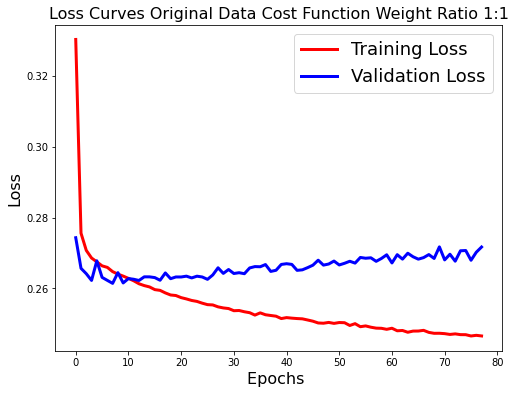

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves Original Data Cost Function Weight Ratio 1:1',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves Original Data Cost Function Weight Ratio 1:1')

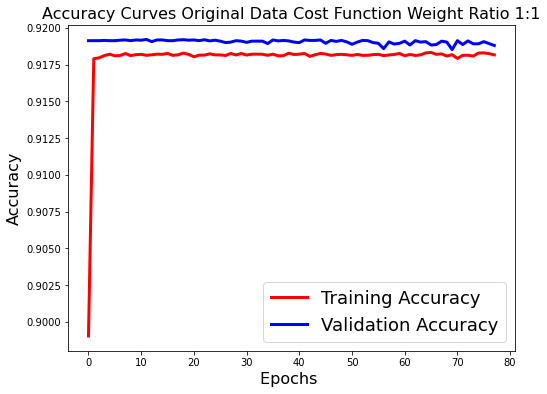

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Original Data Cost Function Weight Ratio 1:1',fontsize=16)

### Original Data Cost Function Weight Ratio 1:10

In [ ]:
#create model
model1 = Sequential()

#add layers to model
model1.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model1.add(BatchNormalization())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(256, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(256, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                5184      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [ ]:
history1 = model1.fit(X_train, y_train, epochs=200,batch_size=128, validation_split=0.25, class_weight = {0: 1., 1: 10.}, callbacks=[es])

Epoch 1/200
1429/1429 [==============================] - 9s 6ms/step - loss: 1.2599 - accuracy: 0.6038 - val_loss: 0.5949 - val_accuracy: 0.6604
Epoch 2/200
1429/1429 [==============================] - 9s 6ms/step - loss: 1.1359 - accuracy: 0.6676 - val_loss: 0.5888 - val_accuracy: 0.6890
Epoch 3/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.1215 - accuracy: 0.6722 - val_loss: 0.5638 - val_accuracy: 0.7570
Epoch 4/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.1125 - accuracy: 0.6775 - val_loss: 0.5668 - val_accuracy: 0.7359
Epoch 5/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.1070 - accuracy: 0.6768 - val_loss: 0.5850 - val_accuracy: 0.7135
Epoch 6/200
1429/1429 [==============================] - 9s 6ms/step - loss: 1.1030 - accuracy: 0.6781 - val_loss: 0.5822 - val_accuracy: 0.6426
Epoch 7/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.0980 - accuracy: 0.6784 - val_loss: 0.5707 - val_ac

Text(0.5, 1.0, 'Loss Curves Original Data Cost Function Weight Ratio 1:10')

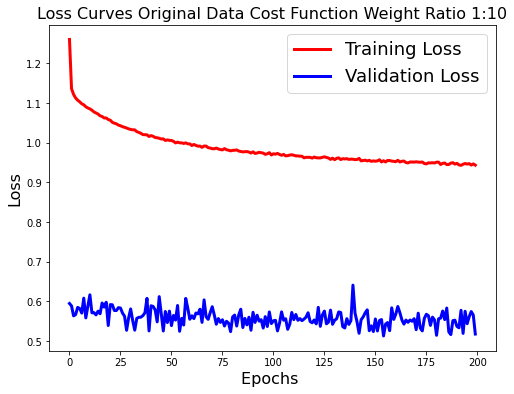

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],'r',linewidth=3.0)
plt.plot(history1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves Original Data Cost Function Weight Ratio 1:10',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves Original Data Cost Function Weight Ratio 1:10')

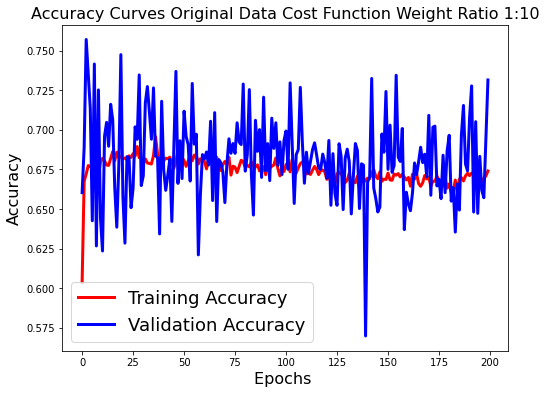

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Original Data Cost Function Weight Ratio 1:10',fontsize=16)

### Run ANN using data with the majority class undersampled to the same size of minority class. Cost Function Weight Ratio 1:1

In [ ]:
y_train_usm=to_categorical(y_train_usm)

In [ ]:
#create model
model2 = Sequential()

#add layers to model
model2.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                5184      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [ ]:
history2 = model2.fit(X_train_usm, y_train_usm, epochs=200,batch_size=32, validation_split=0.25, callbacks=[es])

Epoch 1/200
931/931 [==============================] - 5s 6ms/step - loss: 0.7209 - accuracy: 0.6180 - val_loss: 0.8822 - val_accuracy: 0.1305
Epoch 2/200
931/931 [==============================] - 5s 6ms/step - loss: 0.6217 - accuracy: 0.6656 - val_loss: 0.9982 - val_accuracy: 0.2697
Epoch 3/200
931/931 [==============================] - 5s 6ms/step - loss: 0.6078 - accuracy: 0.6747 - val_loss: 1.0707 - val_accuracy: 0.2444
Epoch 4/200
931/931 [==============================] - 5s 6ms/step - loss: 0.6021 - accuracy: 0.6797 - val_loss: 0.9771 - val_accuracy: 0.2792
Epoch 5/200
931/931 [==============================] - 5s 6ms/step - loss: 0.5967 - accuracy: 0.6819 - val_loss: 1.0244 - val_accuracy: 0.2339
Epoch 6/200
931/931 [==============================] - 5s 6ms/step - loss: 0.5950 - accuracy: 0.6834 - val_loss: 0.9958 - val_accuracy: 0.3322
Epoch 7/200
931/931 [==============================] - 5s 6ms/step - loss: 0.5925 - accuracy: 0.6875 - val_loss: 1.0665 - val_accuracy: 0.2554

Text(0.5, 1.0, 'Loss Curves Extreme undersampling Data Cost Function Weight Ratio 1:1')

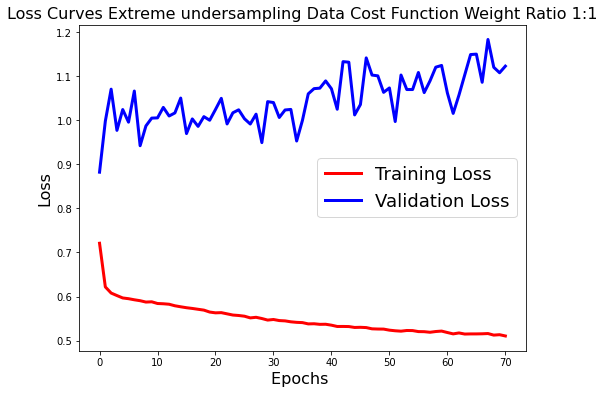

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves Extreme undersampling Data Cost Function Weight Ratio 1:1',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves Extreme undersampling Data Cost Function Weight Ratio 1:1')

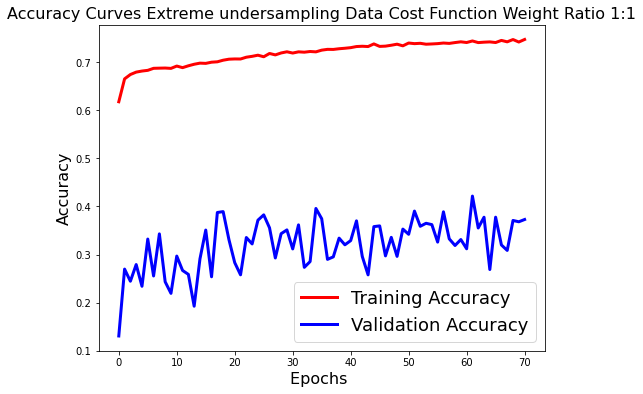

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Extreme undersampling Data Cost Function Weight Ratio 1:1',fontsize=16)

### Original Data Cost Function Weight Ratio 1:12

In [ ]:
#create model
model3 = Sequential()
#add layers to model
model3.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model3.add(BatchNormalization())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                5184      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)              

In [ ]:
history3 = model3.fit(X_train, y_train, epochs=200,batch_size=128, validation_split=0.25, class_weight = {0: 1., 1: 12.}, callbacks=[es])

Epoch 1/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.4215 - accuracy: 0.5089 - val_loss: 0.6454 - val_accuracy: 0.6486
Epoch 2/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.2463 - accuracy: 0.5945 - val_loss: 0.6728 - val_accuracy: 0.5855
Epoch 3/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.2312 - accuracy: 0.6051 - val_loss: 0.6631 - val_accuracy: 0.5539
Epoch 4/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.2197 - accuracy: 0.6056 - val_loss: 0.6529 - val_accuracy: 0.5362
Epoch 5/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.2136 - accuracy: 0.6111 - val_loss: 0.6414 - val_accuracy: 0.6153
Epoch 6/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.2104 - accuracy: 0.6049 - val_loss: 0.6676 - val_accuracy: 0.6448
Epoch 7/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.2068 - accuracy: 0.6130 - val_loss: 0.6635 - val_ac

Text(0.5, 1.0, 'Loss Curves Original Data Cost Function Weight Ratio 1:12')

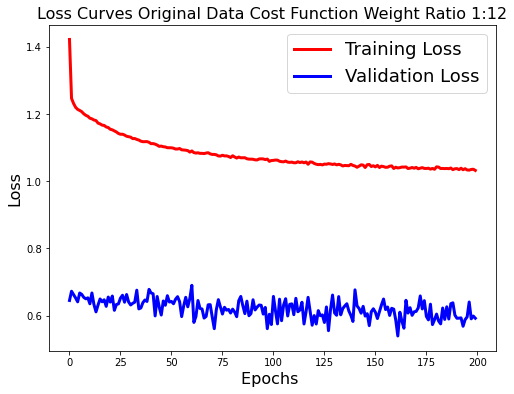

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history3.history['loss'],'r',linewidth=3.0)
plt.plot(history3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves Original Data Cost Function Weight Ratio 1:12',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves Original Data Cost Function Weight Ratio 1:12')

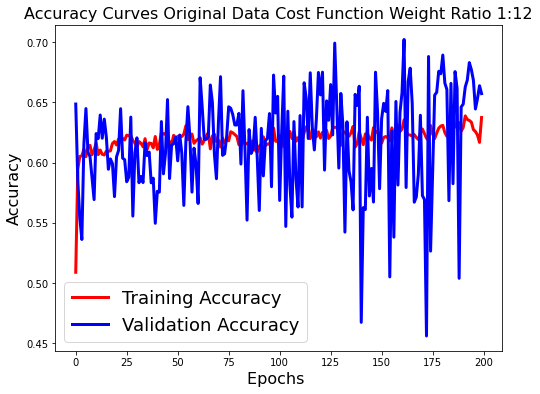

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Original Data Cost Function Weight Ratio 1:12',fontsize=16)

### Original Data Cost Function Weight Ratio 1:8

In [ ]:
#create model
model4 = Sequential()
#add layers to model
model4.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model4.add(BatchNormalization())
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))
model4.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                5184      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)              

In [ ]:
history4 = model4.fit(X_train, y_train, epochs=200,batch_size=128, validation_split=0.25, class_weight = {0: 1., 1: 8.}, callbacks=[es])

Epoch 1/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.1233 - accuracy: 0.7168 - val_loss: 0.4790 - val_accuracy: 0.8335
Epoch 2/200
1429/1429 [==============================] - 8s 6ms/step - loss: 1.0105 - accuracy: 0.7632 - val_loss: 0.4859 - val_accuracy: 0.7540
Epoch 3/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.9979 - accuracy: 0.7610 - val_loss: 0.5588 - val_accuracy: 0.6054
Epoch 4/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.9898 - accuracy: 0.7620 - val_loss: 0.4999 - val_accuracy: 0.7507
Epoch 5/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.9855 - accuracy: 0.7563 - val_loss: 0.4914 - val_accuracy: 0.7923
Epoch 6/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.9820 - accuracy: 0.7566 - val_loss: 0.5412 - val_accuracy: 0.7477
Epoch 7/200
1429/1429 [==============================] - 8s 6ms/step - loss: 0.9778 - accuracy: 0.7584 - val_loss: 0.5197 - val_ac

Text(0.5, 1.0, 'Loss Curves Original Data Cost Function Weight Ratio 1:8')

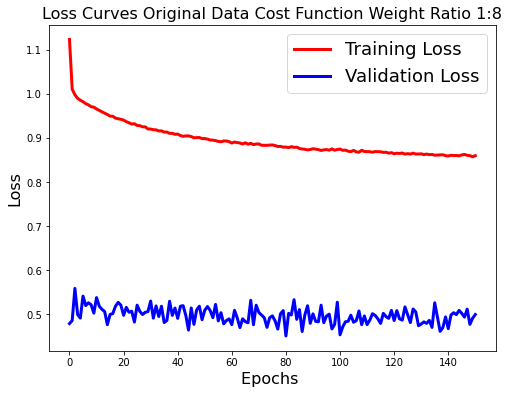

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history4.history['loss'],'r',linewidth=3.0)
plt.plot(history4.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves Original Data Cost Function Weight Ratio 1:8',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves Original Data Cost Function Weight Ratio 1:8')

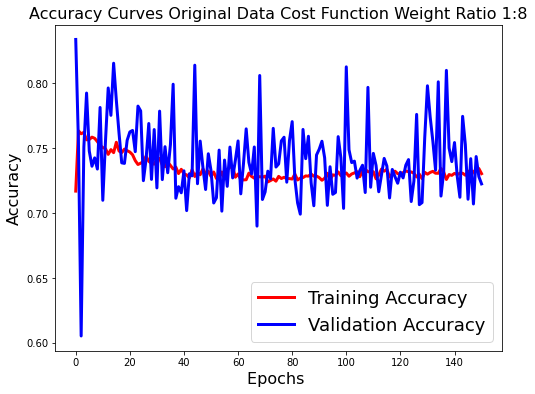

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history4.history['accuracy'],'r',linewidth=3.0)
plt.plot(history4.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves Original Data Cost Function Weight Ratio 1:8',fontsize=16)

### Print out AUC score, precision and recall for both test and train on each model

In [ ]:
y_train1=np.ndarray(shape=(y_train.shape[0]), dtype=float)
for i in range(y_train.shape[0]):
  if y_train[i,0] > y_train[i,1]:
      y_train1[i] = 0
  else:
     y_train1[i] = 1

In [ ]:
y_test1=np.ndarray(shape=(y_test.shape[0]), dtype=float)
for i in range(y_test.shape[0]):
  if y_test[i,0] > y_test[i,1]:
      y_test1[i] = 0
  else:
     y_test1[i] = 1

In [ ]:
y_train_proba_m = model.predict(X_train)
y_test_proba_m = model.predict(X_test)
y_train_pred_m=np.ndarray(shape=(y_train_proba_m.shape[0]), dtype=float)
y_test_pred_m=np.ndarray(shape=(y_test_proba_m.shape[0]), dtype=float)

for i in range(y_train_proba_m.shape[0]):
  if y_train_proba_m[i,0] > y_train_proba_m[i,1]:
      y_train_pred_m[i] = 0
  else:
      y_train_pred_m[i] = 1

for j in range(y_test_proba_m.shape[0]):
  if y_test_proba_m[j,0] > y_test_proba_m[j,1]:
      y_test_pred_m[j] = 0
  else:
      y_test_pred_m[j] = 1

In [ ]:
print('Original Data Cost Function Weight 1:1')
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train1, y_train_pred_m))
print("Accuracy Train:", skm.accuracy_score(y_train1, y_train_pred_m))
print("Precision Train:", skm.precision_score(y_train1, y_train_pred_m))
print("Recall Train:", skm.recall_score(y_train1, y_train_pred_m))
print(" Train AUC score", skm.roc_auc_score(y_train1, y_train_proba_m[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test1, y_test_pred_m))
print("Accuracy Test:", skm.accuracy_score(y_test1, y_test_pred_m))
print("Precision Test:", skm.precision_score(y_test1, y_test_pred_m))
print("Recall Test:", skm.recall_score(y_test1, y_test_pred_m))
print(" Test AUC score", skm.roc_auc_score(y_test1, y_test_proba_m[:,1]))

Original Data Cost Function Weight 1:1
Train Confusion Matrix: 
 [[223812     84]
 [ 19753    107]]
Accuracy Train: 0.9186194391112424
Precision Train: 0.5602094240837696
Recall Train: 0.005387713997985901
 Train AUC score 0.7647083448433168

 Test Confusion Matrix: 
 [[55952    24]
 [ 4947    18]]
Accuracy Test: 0.9184293004709473
Precision Test: 0.42857142857142855
Recall Test: 0.0036253776435045317
 Test AUC score 0.6843035484492634


In [ ]:
y_train_proba_m1 = model1.predict(X_train)
y_test_proba_m1 = model1.predict(X_test)
y_train_pred_m1=np.ndarray(shape=(y_train_proba_m1.shape[0]), dtype=float)
y_test_pred_m1=np.ndarray(shape=(y_test_proba_m1.shape[0]), dtype=float)

for i in range(y_train_proba_m1.shape[0]):
  if y_train_proba_m1[i,0] > y_train_proba_m1[i,1]:
      y_train_pred_m1[i] = 0
  else:
      y_train_pred_m1[i] = 1

for j in range(y_test_proba_m1.shape[0]):
  if y_test_proba_m1[j,0] > y_test_proba_m1[j,1]:
      y_test_pred_m1[j] = 0
  else:
      y_test_pred_m1[j] = 1

In [ ]:
print('Original Data Cost Function Weight 1:10')
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train1, y_train_pred_m1))
print("Accuracy Train:", skm.accuracy_score(y_train1, y_train_pred_m1))
print("Precision Train:", skm.precision_score(y_train1, y_train_pred_m1))
print("Recall Train:", skm.recall_score(y_train1, y_train_pred_m1))
print(" Train AUC score", skm.roc_auc_score(y_train1, y_train_proba_m1[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test1, y_test_pred_m1))
print("Accuracy Test:", skm.accuracy_score(y_test1, y_test_pred_m1))
print("Precision Test:", skm.precision_score(y_test1, y_test_pred_m1))
print("Recall Test:", skm.recall_score(y_test1, y_test_pred_m1))
print(" Test AUC score", skm.roc_auc_score(y_test1, y_test_proba_m1[:,1]))

Original Data Cost Function Weight 1:10
Train Confusion Matrix: 
 [[170820  53076]
 [  6912  12948]]
Accuracy Train: 0.7539014424260326
Precision Train: 0.19611050527081061
Recall Train: 0.6519637462235649
 Train AUC score 0.7845205934205678

 Test Confusion Matrix: 
 [[42055 13921]
 [ 2449  2516]]
Accuracy Test: 0.731379531021808
Precision Test: 0.15306929488349455
Recall Test: 0.5067472306143
 Test AUC score 0.6792872117830387


In [ ]:
y_train_proba_m2 = model2.predict(X_train)
y_test_proba_m2 = model2.predict(X_test)
y_train_pred_m2=np.ndarray(shape=(y_train_proba_m2.shape[0]), dtype=float)
y_test_pred_m2=np.ndarray(shape=(y_test_proba_m2.shape[0]), dtype=float)

for i in range(y_train_proba_m2.shape[0]):
  if y_train_proba_m2[i,0] > y_train_proba_m2[i,1]:
      y_train_pred_m2[i] = 0
  else:
      y_train_pred_m2[i] = 1

for j in range(y_test_proba_m2.shape[0]):
  if y_test_proba_m2[j,0] > y_test_proba_m2[j,1]:
      y_test_pred_m2[j] = 0
  else:
      y_test_pred_m2[j] = 1

In [ ]:
print('Extreme undersampling Data Cost Function Weight Ratio 1:1')
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train1, y_train_pred_m2))
print("Accuracy Train:", skm.accuracy_score(y_train1, y_train_pred_m2))
print("Precision Train:", skm.precision_score(y_train1, y_train_pred_m2))
print("Recall Train:", skm.recall_score(y_train1, y_train_pred_m2))
print(" Train AUC score", skm.roc_auc_score(y_train1, y_train_proba_m2[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test1, y_test_pred_m2))
print("Accuracy Test:", skm.accuracy_score(y_test1, y_test_pred_m2))
print("Precision Test:", skm.precision_score(y_test1, y_test_pred_m2))
print("Recall Test:", skm.recall_score(y_test1, y_test_pred_m2))
print(" Test AUC score", skm.roc_auc_score(y_test1, y_test_proba_m2[:,1]))

Extreme undersampling Data Cost Function Weight Ratio 1:1
Train Confusion Matrix: 
 [[185017  38879]
 [ 10591   9269]]
Accuracy Train: 0.7970511495101659
Precision Train: 0.19251059234028411
Recall Train: 0.46671701913393754
 Train AUC score 0.7247382417669389

 Test Confusion Matrix: 
 [[45918 10058]
 [ 3145  1820]]
Accuracy Test: 0.7833478282273019
Precision Test: 0.15322444856036369
Recall Test: 0.36656596173212486
 Test AUC score 0.6556252456634775


In [ ]:
y_train_proba_m3 = model3.predict(X_train)
y_test_proba_m3 = model3.predict(X_test)
y_train_pred_m3=np.ndarray(shape=(y_train_proba_m3.shape[0]), dtype=float)
y_test_pred_m3=np.ndarray(shape=(y_test_proba_m3.shape[0]), dtype=float)

for i in range(y_train_proba_m3.shape[0]):
  if y_train_proba_m3[i,0] > y_train_proba_m3[i,1]:
      y_train_pred_m3[i] = 0
  else:
      y_train_pred_m3[i] = 1

for j in range(y_test_proba_m3.shape[0]):
  if y_test_proba_m3[j,0] > y_test_proba_m3[j,1]:
      y_test_pred_m3[j] = 0
  else:
      y_test_pred_m3[j] = 1

In [ ]:
print('Original Data Cost Function Weight 1:12')
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train1, y_train_pred_m3))
print("Accuracy Train:", skm.accuracy_score(y_train1, y_train_pred_m3))
print("Precision Train:", skm.precision_score(y_train1, y_train_pred_m3))
print("Recall Train:", skm.recall_score(y_train1, y_train_pred_m3))
print(" Train AUC score", skm.roc_auc_score(y_train1, y_train_proba_m3[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test1, y_test_pred_m3))
print("Accuracy Test:", skm.accuracy_score(y_test1, y_test_pred_m3))
print("Precision Test:", skm.precision_score(y_test1, y_test_pred_m3))
print("Recall Test:", skm.recall_score(y_test1, y_test_pred_m3))
print(" Test AUC score", skm.roc_auc_score(y_test1, y_test_proba_m3[:,1]))

Original Data Cost Function Weight 1:12
Train Confusion Matrix: 
 [[151504  72392]
 [  4812  15048]]
Accuracy Train: 0.683273437371798
Precision Train: 0.17209515096065875
Recall Train: 0.7577039274924471
 Train AUC score 0.7805610413513453

 Test Confusion Matrix: 
 [[37148 18828]
 [ 2019  2946]]
Accuracy Test: 0.6579150325724882
Precision Test: 0.13529898043538166
Recall Test: 0.5933534743202417
 Test AUC score 0.6760358956888588


In [ ]:
y_train_proba_m4 = model4.predict(X_train)
y_test_proba_m4 = model4.predict(X_test)
y_train_pred_m4=np.ndarray(shape=(y_train_proba_m4.shape[0]), dtype=float)
y_test_pred_m4=np.ndarray(shape=(y_test_proba_m4.shape[0]), dtype=float)

for i in range(y_train_proba_m4.shape[0]):
  if y_train_proba_m4[i,0] > y_train_proba_m4[i,1]:
      y_train_pred_m4[i] = 0
  else:
      y_train_pred_m4[i] = 1

for j in range(y_test_proba_m4.shape[0]):
  if y_test_proba_m4[j,0] > y_test_proba_m4[j,1]:
      y_test_pred_m4[j] = 0
  else:
      y_test_pred_m4[j] = 1

In [ ]:
print('Original Data Cost Function Weight 1:8')
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train1, y_train_pred_m4))
print("Accuracy Train:", skm.accuracy_score(y_train1, y_train_pred_m4))
print("Precision Train:", skm.precision_score(y_train1, y_train_pred_m4))
print("Recall Train:", skm.recall_score(y_train1, y_train_pred_m4))
print(" Train AUC score", skm.roc_auc_score(y_train1, y_train_proba_m4[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_test1, y_test_pred_m4))
print("Accuracy Test:", skm.accuracy_score(y_test1, y_test_pred_m4))
print("Precision Test:", skm.precision_score(y_test1, y_test_pred_m4))
print("Recall Test:", skm.recall_score(y_test1, y_test_pred_m4))
print(" Test AUC score", skm.roc_auc_score(y_test1, y_test_proba_m4[:,1]))

Original Data Cost Function Weight 1:8
Train Confusion Matrix: 
 [[168531  55365]
 [  6631  13229]]
Accuracy Train: 0.7456636964833686
Precision Train: 0.19285943376971748
Recall Train: 0.6661127895266868
 Train AUC score 0.7787195244961775

 Test Confusion Matrix: 
 [[41507 14469]
 [ 2417  2548]]
Accuracy Test: 0.7229123250356903
Precision Test: 0.1497326203208556
Recall Test: 0.5131923464249748
 Test AUC score 0.6756610425472231


In [118]:
Comparison_dict = {'Original Data Cost Function Weight 1:1':[0.918,0.429,0.0036,0.684],
                       'Undersampling Data Cost Function Weight Ratio 1:1':[0.783,0.153,0.367,0.656],
                       'Original Data Cost Function Weight 1:8':[0.723,0.150,0.513,0.676],
                       'Original Data Cost Function Weight 1:10':[0.731,0.153,0.507,0.679],
                       'Original Data Cost Function Weight 1:12':[0.658,0.135,0.593,0.676]}

model_comparison = pd.DataFrame(Comparison_dict)
model_comparison['Metrics'] = ['Test_Accuracy','Test_Precision','Test_Recall','Test_AUC']
#re-arranging the column order
cols = model_comparison.columns.tolist()
cols = cols[-1:] + cols[:-1]
model_comparison = model_comparison[cols]

#pivot
model_comparison = model_comparison.transpose()
model_comparison = model_comparison[1:].reset_index(drop=False)
model_comparison.columns = ['Model','Test_Accuracy','Test_Precision','Test_Recall','Test_AUC']
model_comparison

,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC
0,Original Data Cost Function Weight 1:1,0.918,0.429,0.0036,0.684
1,Undersampling Data Cost Function Weight Ratio 1:1,0.783,0.153,0.367,0.656
2,Original Data Cost Function Weight 1:8,0.723,0.15,0.513,0.676
3,Original Data Cost Function Weight 1:10,0.731,0.153,0.507,0.679
4,Original Data Cost Function Weight 1:12,0.658,0.135,0.593,0.676
